# **Проект: Fraud Detection Competition**


**Задача определения фрода:**

https://www.kaggle.com/competitions/fraud-detection-24


In [ ]:
%wget --no-check-certificate 'https://www.dropbox.com/s/5iuef7c9ljj84t6/train_transaction.csv?dl=0' -O train_transaction.csv
%wget --no-check-certificate 'https://www.dropbox.com/s/cmy01z5fw7ohlmd/train_identity.csv?dl=0' -O train_identity.csv
%wget --no-check-certificate 'https://www.dropbox.com/s/7thqkuxnwsa7njj/test_transaction.csv?dl=0' -O test_transaction.csv
%wget --no-check-certificate 'https://www.dropbox.com/s/b40nvbb9e2usd5w/test_identity.csv?dl=0' -O test_identity.csv
%wget --no-check-certificate 'https://www.dropbox.com/s/arkyoz0bel8z4d2/sample_submission.csv?dl=0' -O sample_submission.csv

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from wordcloud import WordCloud
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
import pandas as pd
import os
import time
from scipy.stats import zscore
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
import hdbscan
import h2o
from h2o.automl import H2OAutoML

In [5]:
INPUT_DIR = '.'

train_transaction = pd.read_csv(os.path.join(INPUT_DIR, 'C:\\Users\\ksbal\\Desktop\\HW7\\train_transaction.csv'))
train_identity = pd.read_csv(os.path.join(INPUT_DIR, 'C:\\Users\\ksbal\\Desktop\\HW7\\train_identity.csv'))
test_transaction = pd.read_csv(os.path.join(INPUT_DIR, 'C:\\Users\\ksbal\\Desktop\\HW7\\test_transaction.csv'))
test_identity = pd.read_csv(os.path.join(INPUT_DIR, 'C:\\Users\\ksbal\\Desktop\\HW7\\test_identity.csv'))
sample_submission = pd.read_csv(os.path.join(INPUT_DIR, 'C:\\Users\\ksbal\\Desktop\\HW7\\sample_submission.csv'))

In [6]:
df_train = train_transaction.merge(train_identity, how='left', on='TransactionID')
df_test = test_transaction.merge(test_identity, how='left', on='TransactionID')

In [7]:
df_train.drop(['TransactionID', 'TransactionDT'], axis=1, inplace=True)
df_test.drop(['TransactionID', 'TransactionDT'], axis=1, inplace=True)
df_train.shape, df_test.shape

((417559, 432), (172981, 431))

In [8]:
# Было
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 417559 entries, 0 to 417558
Columns: 432 entries, isFraud to DeviceInfo
dtypes: float64(399), int64(2), object(31)
memory usage: 1.3+ GB


In [9]:
def convert_to_int_if_possible(number):
    try:
        if pd.isna(number):  # Проверяем на NaN
            return number
        str_number = str(number)
        if '.' in str_number:
            integer_part, fractional_part = str_number.split('.')
            if all(char == '0' for char in fractional_part):
                return int(integer_part)
            else:
                return number
        else:
            return int(str_number)
    except Exception as e:
        print(f"Ошибка при обработке значения {number}: {e}")
        return number

In [10]:
# Возьмем функцию из ноутбука выше, чтобы перевести типы данных в более компактный формат и работать уже с ними
def reduce_mem_usage(df):
    NAlist = [] # Список столбцов с обработанными пропущенными значениями
    for col in tqdm(df.columns):
        if df[col].dtype != object:  # Исключаем строки
            # Вычисляем минимум и максимум
            col_max_value = df[col].max()
            col_min_value = df[col].min()

            int_min = int(col_min_value)

            # Преобразуем в целые числа, если это возможно
            df[col] = pd.to_numeric(df[col], errors='coerce')
            df[col] = df[col].apply(convert_to_int_if_possible)

            # Обработка NaN
            if not np.isfinite(df[col]).all():
                NAlist.append(col)
                df[col] = df[col].fillna(int_min - 1)

            # Преобразование в целочисленный тип
            if pd.api.types.is_integer_dtype(df[col]):
                if col_min_value-1 >= 0:
                    if col_max_value < 255:
                        df[col] = df[col].astype(np.uint8)
                    elif col_max_value < 65535:
                        df[col] = df[col].astype(np.uint16)
                    elif col_max_value < 4294967295:
                        df[col] = df[col].astype(np.uint32)
                    else:
                        df[col] = df[col].astype(np.uint64)
                else:
                    if col_min_value > np.iinfo(np.int8).min and col_max_value < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif col_min_value > np.iinfo(np.int16).min and col_max_value < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif col_min_value > np.iinfo(np.int32).min and col_max_value < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif col_min_value > np.iinfo(np.int64).min and col_max_value < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)

            # Преобразование в float32
            else:
                df[col] = df[col].astype(np.float32)

            # Восстановление NaN значений
            if col in NAlist:
                df[col] = df[col].replace(int_min - 1, np.nan)

    return df, NAlist

In [11]:
# Применение функции reduce_mem_usage
df_train, NAlist = reduce_mem_usage(df_train)

100%|██████████| 432/432 [01:16<00:00,  5.61it/s]


In [99]:
# Стало
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 417559 entries, 0 to 417558
Columns: 432 entries, isFraud to DeviceInfo
dtypes: float32(354), int16(13), int8(32), object(31), uint16(1), uint8(1)
memory usage: 686.9+ MB


**Объем занимаемой памяти уменьшился почти в 2 раза!**

In [59]:
object_cols = []
for idx, col in tqdm(enumerate(df_train.columns.drop('isFraud'))):
    if df_train[col].dtype == 'O':
      object_cols.append(idx)

431it [00:00, 399236.98it/s]


In [60]:
X_train = df_train.drop('isFraud', axis=1)
X_train = X_train.fillna('')
y_train = df_train['isFraud'].values

cb1 = CatBoostClassifier(iterations=3)
cb1.fit(X_train, y_train, object_cols, )

Learning rate set to 0.5
0:	learn: 0.2082395	total: 174ms	remaining: 348ms
1:	learn: 0.1360790	total: 318ms	remaining: 159ms
2:	learn: 0.1180984	total: 487ms	remaining: 0us


In [61]:
predictions = cb1.predict_proba(df_test.fillna(''))

In [62]:
sub = pd.DataFrame({'TransactionID': sample_submission['TransactionID'], 'isFraud': predictions[:, 0]})
sub.head()

TransactionID   isFraud
0        3404559  0.978714
1        3404560  0.935724
2        3404561  0.946864
3        3404562  0.978714
4        3404563  0.970637

In [63]:
# Сохранение submission
sub.to_csv('submission_baseline.csv', index=False)


Я провожу разведочный анализ данных (EDA), чтобы лучше понять структуру датасета и подготовить его к дальнейшему моделированию.

В ходе анализа я:

* Изучаю признаки: смотрю на их типы, распределения, диапазоны значений, наличие необычных паттернов. Оцениваю, как каждый признак связан с целевой переменной — визуально (например, boxplot’ами, scatter plot’ами) и количественно (корреляция, статистические тесты).
* Анализирую целевую переменную: проверяю её распределение (нормальное? скошенное?), наличие выбросов, баланс классов (если задача классификации) или масштаб (если регрессия). Это помогает понять, нужны ли преобразования, например логарифмирование или стратификация при разбиении.
* Оцениваю взаимосвязи: строю матрицу корреляций (например, через Pearson или Spearman), чтобы выявить мультиколлинеарность между признаками, а также силу и направление связи каждого признака с целевой переменной. При необходимости дополняю анализ визуализациями — heatmap, pairplot и т.д.
* Принимаю решения по обработке данных на основе выводов:
     - удаляю дубликаты, если они есть и не несут смысловой нагрузки;
     - обрабатываю пропуски — либо удаляю строки/столбцы, либо заполняю (медианой, модой, моделью);
     - кодирую категориальные признаки (one-hot, label encoding и пр.);
     - корректирую или убираю аномалии, если они искажают картину;
     - при необходимости нормализую или стандартизирую признаки, создаю новые (feature engineering).


Все шаги сопровождаю выводами: почему я принял то или иное решение, как это влияет на данные и что это даёт для последующего обучения модели. EDA — не просто «посмотреть данные», а осмысленный этап, формирующий стратегию всей дальнейшей работы.

Проведем EDA на тренировочном датасете. С целевой переменной isFraud.

In [100]:
df_train.head()

isFraud  TransactionAmt ProductCD  card1  card2  card3       card4  card5  \
0        0            68.5         W  13926    NaN  150.0    discover  142.0   
1        0            29.0         W   2755  404.0  150.0  mastercard  102.0   
2        0            59.0         W   4663  490.0  150.0        visa  166.0   
3        0            50.0         W  18132  567.0  150.0  mastercard  117.0   
4        0            50.0         H   4497  514.0  150.0  mastercard  102.0   

    card6  addr1  ...                id_31  id_32      id_33           id_34  \
0  credit  315.0  ...                  NaN    NaN        NaN             NaN   
1  credit  325.0  ...                  NaN    NaN        NaN             NaN   
2   debit  330.0  ...                  NaN    NaN        NaN             NaN   
3   debit  476.0  ...                  NaN    NaN        NaN             NaN   
4  credit  420.0  ...  samsung browser 6.2   32.0  2220x1080  match_status:2   

  id_35  id_36  id_37  id_38  DeviceType                     DeviceInfo  
0   NaN    NaN    NaN    NaN         NaN                            NaN  
1   NaN    NaN    NaN    NaN         NaN                            NaN  
2   NaN    NaN    NaN    NaN         NaN                            NaN  
3   NaN    NaN    NaN    NaN         NaN                            NaN  
4     T      F      T      T      mobile  SAMSUNG SM-G892A Build/NRD90M  

[5 rows x 432 columns]

Посмотрим, если ли в датасете полные дубликаты и удалим их.

In [19]:
# Подсчет количества дубликатов
duplicate_count = df_train.duplicated().sum()
print(f'Количество полных дубликатов: {duplicate_count}')

Количество полных дубликатов: 270


In [20]:
df_train = df_train.drop_duplicates()
print(f'Размер датафрейма после удаления дубликатов: {df_train.shape}')

Размер датафрейма после удаления дубликатов: (417289, 432)


**Анализ признаков**

In [103]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 417289 entries, 0 to 417558
Columns: 432 entries, isFraud to DeviceInfo
dtypes: float32(354), int16(13), int8(32), object(31), uint16(1), uint8(1)
memory usage: 689.7+ MB


У нас 401 признаков численного типа и 31 типа object.

In [104]:
# Смотрим на количество пропусков в каждом столбце
df_train.isna().sum()

isFraud                0
TransactionAmt         0
ProductCD              0
card1                  0
card2               6560
                   ...  
id_36             309016
id_37             309016
id_38             309016
DeviceType        309165
DeviceInfo        325330
Length: 432, dtype: int64

Как видно, пропусков достаточно. Их обработка будет ниже.

**Статистика числовых признаков**

In [105]:
df_train.describe()

isFraud  TransactionAmt          card1          card2  \
count  417289.000000   417289.000000  417289.000000  410729.000000   
mean        0.035278      134.708206    9864.198011     363.493530   
std         0.184481      238.232468    4900.802606     158.158676   
min         0.000000        0.251000    1000.000000     100.000000   
25%         0.000000       42.950001    6019.000000     215.000000   
50%         0.000000       68.970001    9633.000000     361.000000   
75%         0.000000      125.000000   14128.000000     512.000000   
max         1.000000    31937.390625   18396.000000     600.000000   

               card3          card5          addr1          addr2  \
count  416468.000000  414309.000000  369342.000000  369342.000000   
mean      153.347824     199.679276     290.443420      86.762688   
std        11.566636      40.788082     101.868134       2.931181   
min       100.000000     100.000000     100.000000      10.000000   
25%       150.000000     166.000000     204.000000      87.000000   
50%       150.000000     226.000000     299.000000      87.000000   
75%       150.000000     226.000000     330.000000      87.000000   
max       231.000000     237.000000     540.000000     102.000000   

               dist1         dist2  ...          id_17         id_18  \
count  159461.000000  29286.000000  ...  107259.000000  34269.000000   
mean      124.800949    239.833099  ...     187.936432     14.172546   
std       381.813049    538.292786  ...      30.118252      1.479054   
min         0.000000      0.000000  ...     100.000000     10.000000   
25%         3.000000      7.000000  ...     166.000000     13.000000   
50%         9.000000     36.000000  ...     166.000000     15.000000   
75%        25.000000    225.000000  ...     225.000000     15.000000   
max     10286.000000  11623.000000  ...     229.000000     29.000000   

               id_19          id_20        id_21        id_22        id_24  \
count  107226.000000  107209.000000  3950.000000  3954.000000  3624.000000   
mean      352.299622     400.498657   371.863037    15.991148    12.790563   
std       140.265671     150.423920   200.186905     6.891239     2.189355   
min       100.000000     100.000000   100.000000    10.000000    11.000000   
25%       266.000000     256.000000   252.000000    14.000000    11.000000   
50%       341.000000     469.000000   252.000000    14.000000    11.000000   
75%       427.000000     521.000000   500.000000    14.000000    15.000000   
max       671.000000     661.000000   854.000000    44.000000    26.000000   

             id_25        id_26         id_32  
count  3930.000000  3948.000000  62116.000000  
mean    328.534363   148.645645     26.635328  
std      98.821075    32.355820      3.787343  
min     100.000000   100.000000      0.000000  
25%     321.000000   119.000000     24.000000  
50%     321.000000   147.000000     24.000000  
75%     371.000000   169.000000     32.000000  
max     548.000000   216.000000     32.000000  

[8 rows x 401 columns]

Статистика показывает, что у нас достаточно много пустых значений. Также можно заметить на видимых признаках, что есть выбросы (достаточно большие). Подробнее выбросы посмотрим ниже.

In [21]:
num_cols = df_train.select_dtypes(include=['number']).columns.tolist()

In [22]:
# Посмотрим на выбросы для числовых столбцов
def find_outliers_iqr(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data < lower_bound) | (data > upper_bound)]

outliers_count = {}
for col in num_cols:
    outliers = find_outliers_iqr(df_train[col])
    outliers_count[col] = len(outliers)

# Сортировка признаков по количеству выбросов
sorted_outliers_count = sorted(outliers_count.items(), key=lambda x: x[1], reverse=True)
top_3_features = [feature for feature, count in sorted_outliers_count[:3]]

# Выведем топ-20
for num in range(len(sorted_outliers_count[:20])):
    if sorted_outliers_count[num][1] != 0:
        print(f'Столбец {sorted_outliers_count[num][0]} с {sorted_outliers_count[num][1]} выбросами')

Столбец V97 с 92027 выбросами
Столбец V128 с 92027 выбросами
Столбец V291 с 88232 выбросами
Столбец V287 с 83677 выбросами
Столбец V312 с 83677 выбросами
Столбец V314 с 79204 выбросами
Столбец V62 с 77209 выбросами
Столбец V20 с 76922 выбросами
Столбец V308 с 75685 выбросами
Столбец V19 с 74246 выбросами
Столбец V61 с 73277 выбросами
Столбец V83 с 72640 выбросами
Столбец V289 с 70143 выбросами
Столбец V315 с 70143 выбросами
Столбец V82 с 68792 выбросами
Столбец V288 с 68268 выбросами
Столбец V313 с 68268 выбросами
Столбец V279 с 67838 выбросами
Столбец V306 с 67838 выбросами
Столбец C14 с 65369 выбросами


Выбросов тоже большое количество. И, как можно заметить, больше всего выбросов в колонках 'V...'. В описании признаков написано, что V1-V45: сгенерированные вручную признаки на основе ранжирования, подсчета и других методов. И возникает вопрос, а нужны  ли нам вообще эти данные, особенно с таким большим количеством выбросов? Разберемся ниже

Нарисуем BoxPlot для Топ-3 признака с самым большим числом выбросов.

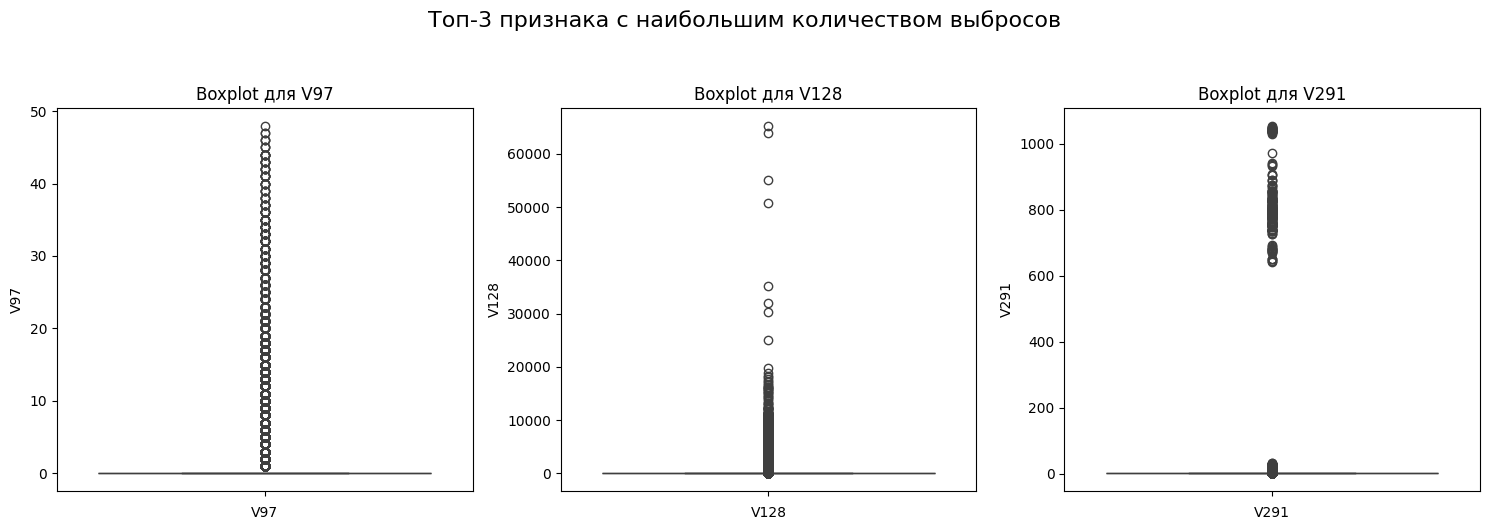

In [108]:
plt.figure(figsize=(15, 5))
for i, col in enumerate(top_3_features):
    plt.subplot(1, 3, i + 1)
    sns.boxplot(data=df_train[col])
    plt.title(f'Boxplot для {col}')
    plt.xlabel(col)

plt.suptitle('Топ-3 признака с наибольшим количеством выбросов', y=1.05, fontsize=16)
plt.tight_layout()
plt.show()

**Анализ категориальных признаков**

Посмотрим на анализ частот только для тех категориальных признаков, которые содержат в себе <= 4 уникальных значений.

In [23]:
object_cols_name = df_train.select_dtypes(include=['object']).columns.tolist()

In [24]:
object_cols_name4 = [col for col in object_cols_name if len(df_train[col].unique()) <= 4]

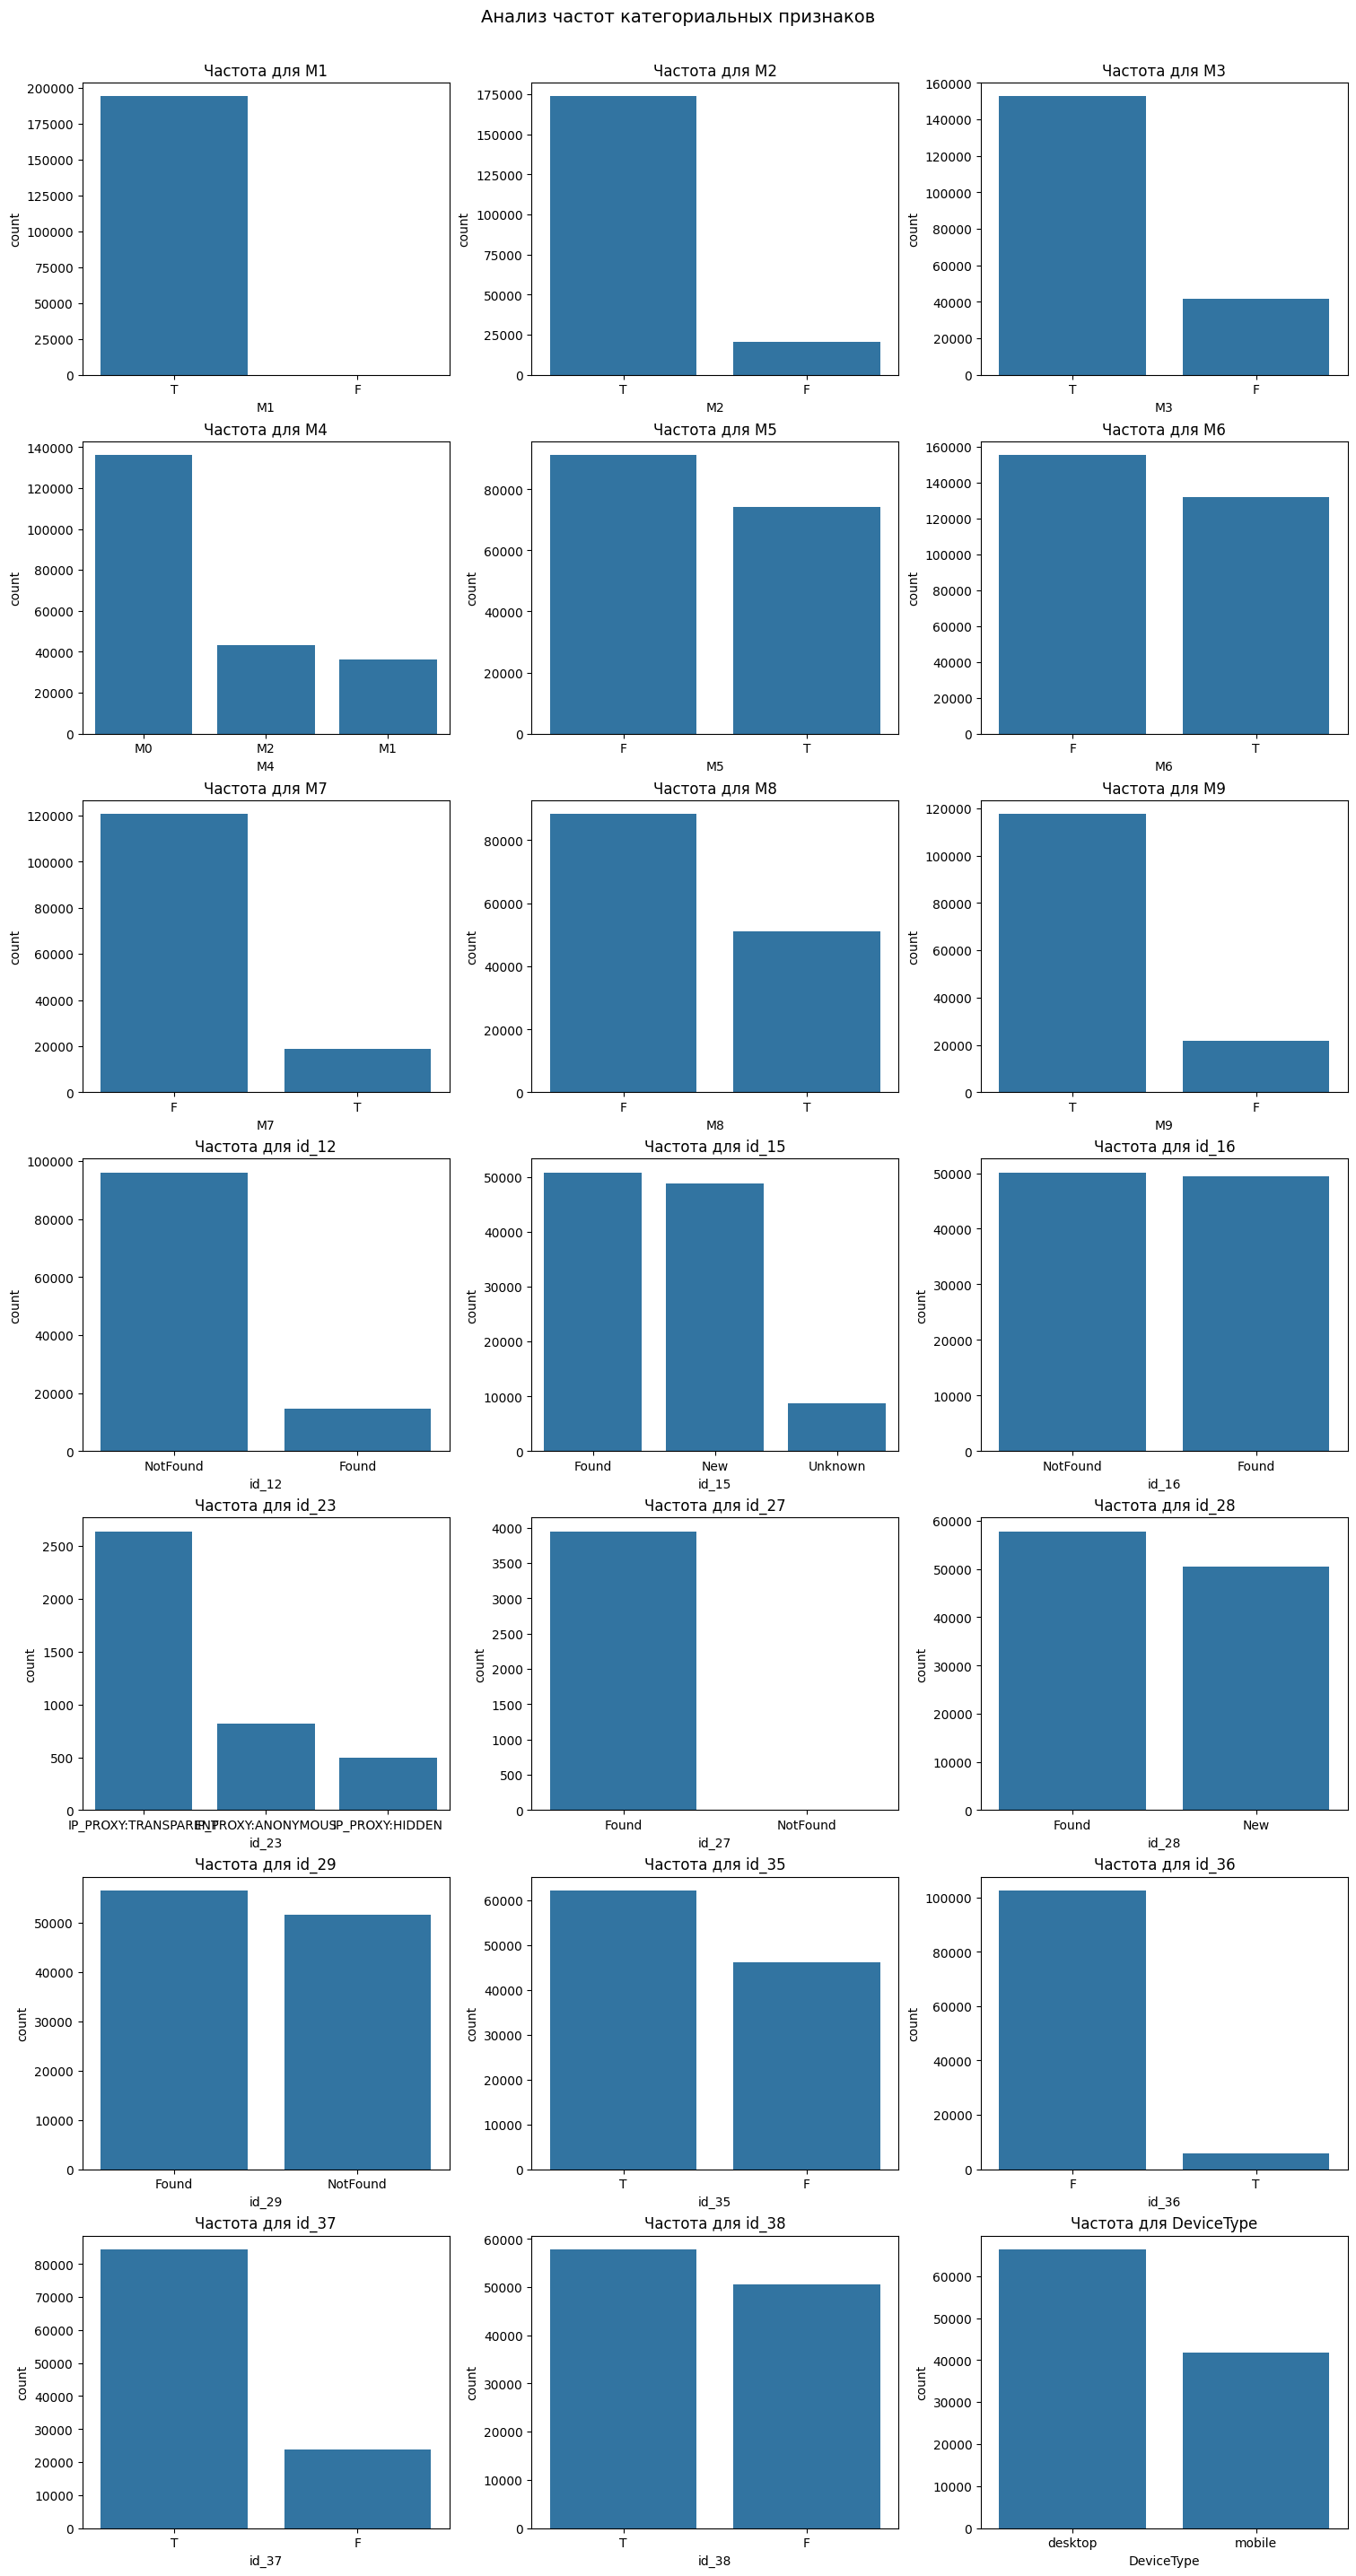

In [111]:
plots = len(object_cols_name4)
cols = 3
rows = (plots + cols - 1) // cols

# Создаем сетку графиков
fig, axes = plt.subplots(nrows=rows,
                         ncols=cols,
                         figsize=(15, rows * 4),
                         constrained_layout=True)
axes = axes.flatten()
for i in range(plots, len(axes)):
    axes[i].remove()

for i, col in enumerate(object_cols_name4):
    sns.countplot(data=df_train, x=col, order=df_train[col].value_counts().index, ax=axes[i])
    axes[i].set_title(f'Частота для {col}')
    axes[i].set_xlabel(col)


plt.suptitle('Анализ частот категориальных признаков', y=1.02, fontsize=14)
plt.show()

Как видно, некоторые признаки имеют доминирующие категории. Насколько они важны, посмотрим ниже.

Для остальных категориальных признаков построим облачный график.

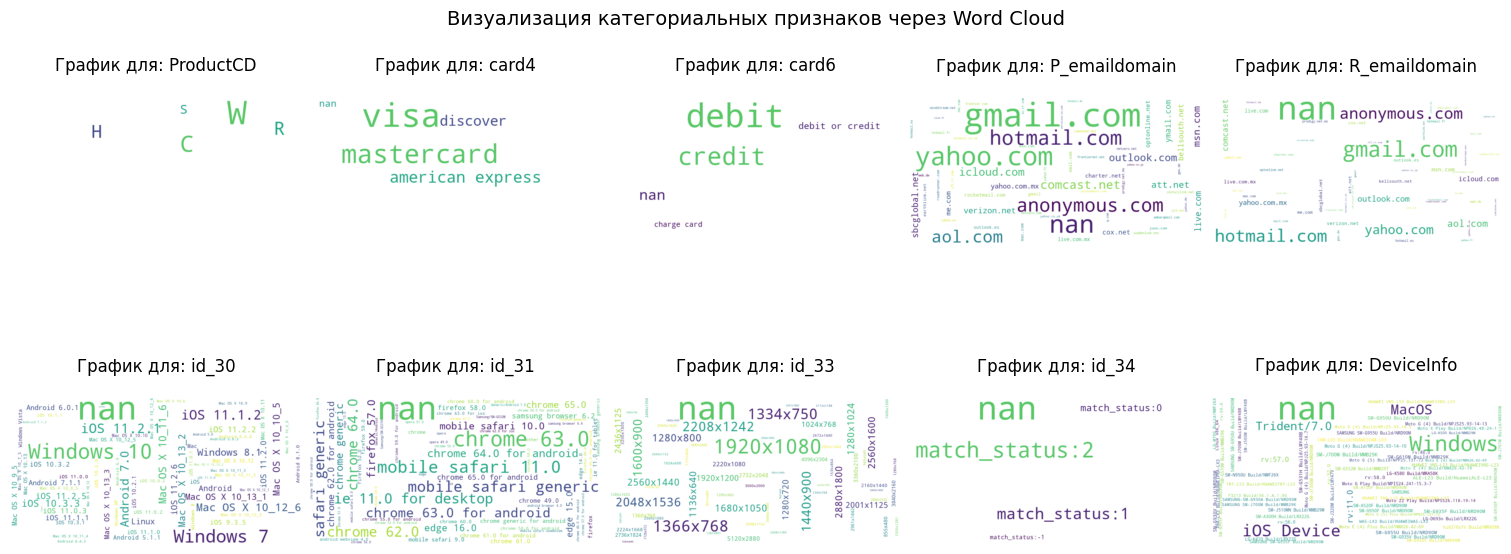

In [25]:
object_cols = [col for col in object_cols_name if len(df_train[col].unique()) > 4]
# Определяем количество строк и столбцов для графиков
plots = len(object_cols)
cols = 5
rows = (plots + cols - 1) // cols

# Создаем сетку графиков
fig, axes = plt.subplots(nrows=rows,
                         ncols=cols,
                         figsize=(15, rows * 3),
                         constrained_layout=True)
axes = axes.flatten()
for i in range(plots, len(axes)):
    axes[i].remove()

for i, col in enumerate(object_cols):
    frequencies = df_train[col].astype(str).value_counts().to_dict()

    wc = WordCloud(
        width=800,
        height=400,
        background_color='white',
        max_words=70,          # Ограничиваем количество отображаемых категорий
        margin=1,           # Минимальное расстояние между словами
        relative_scaling=0.4,
        prefer_horizontal=0.7,
        min_font_size=6,
        max_font_size=90,
        random_state=42
    ).generate_from_frequencies(frequencies)

    ax = axes[i]
    ax.imshow(wc, interpolation='bilinear')
    ax.axis('off')
    ax.set_title(f'График для: {col}', pad=20, fontsize=12)

plt.suptitle('Визуализация категориальных признаков через Word Cloud', y=1.02, fontsize=14)
plt.show()

На данном облачном графике визуально уже видно признаки, которые содержат в себе большое количество пустых значений ==> их можно было бы удалить, но для начала ниже убедимся в том, насколько они важны, и сколько информации в себе содержат, а потом уже решим, что делать.

**Анализ целевой переменной**

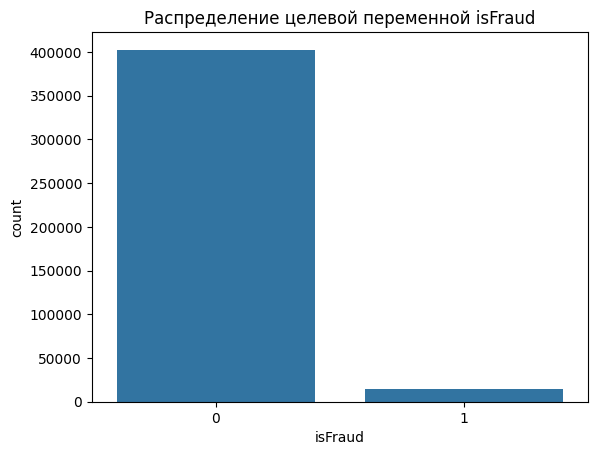

In [26]:
sns.countplot(data=df_train, x='isFraud')
plt.title('Распределение целевой переменной isFraud')
plt.show()

In [27]:
print(df_train['isFraud'].value_counts(normalize=True))

isFraud
0    0.964722
1    0.035278
Name: proportion, dtype: float64


Классы сильно несбалансированы (96% транзакций не являются мошенническими). Это может повлиять на обучение модели, поэтому следует сделать балансировку классов (но это тоже ниже).

**Анализ взаимосвязей**

In [28]:
def analyze_numerical_features(df, target_column='isFraud'):
    '''
    Анализирует числовые признаки и их корреляцию с целевой переменной.
    '''
    numerical_features = numerical_features = df.select_dtypes(include=['number']).columns.tolist()
    if target_column in numerical_features:
        numerical_features.remove(target_column)
    correlations = df[numerical_features].corrwith(df[target_column])

    # Создаем DataFrame с корреляциями
    correlation_df = pd.DataFrame({
        'Feature': correlations.index,
        'Correlation': correlations.values
    })

    correlation_df['Abs_Correlation'] = correlation_df['Correlation'].abs()
    correlation_df = correlation_df.sort_values(by='Abs_Correlation', ascending=False).drop(columns=['Abs_Correlation'])

    return correlation_df


def analyze_categorical_features(df, target_column='isFraud', categorical_features=object_cols_name):
    '''
    Анализирует категориальные признаки и их связь с целевой переменной.

    '''
    influence_scores = []

    for feature in categorical_features:
        grouped = df.groupby(feature)[target_column].mean()

        influence_scores.append({
            'Feature': feature,
            'Mean_Target': grouped.mean()
        })

    influence_df = pd.DataFrame(influence_scores)
    influence_df = influence_df.sort_values(by='Mean_Target', ascending=False)

    return influence_df

In [29]:
numerical_analysis = analyze_numerical_features(df_train)
categorical_analysis = analyze_categorical_features(df_train)

c:\Users\ksbal\Desktop\HW7\venv\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\ksbal\Desktop\HW7\venv\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Посмотрим на топ-10 корреляции числовых признаков

In [30]:
numerical_analysis.head(10)

Feature  Correlation
294    V257     0.369940
281    V244     0.359898
279    V242     0.354488
283    V246     0.351318
238    V201     0.326478
237    V200     0.313537
270    V233     0.310821
225    V188     0.307764
226    V189     0.303891
269    V232     0.288306

Выяснилось, что признаки 'V...' нам все же нужны так как они наиболее значимы для предсказания.

Теперь посмотрим на топ-10 для категориальных признаков.

In [31]:
categorical_analysis.head(10)

Feature  Mean_Target
22       id_31     0.129933
25       id_35     0.080237
17       id_23     0.079724
30  DeviceInfo     0.079575
15       id_15     0.079435
29  DeviceType     0.079214
28       id_38     0.075785
20       id_29     0.073639
16       id_16     0.073304
19       id_28     0.073195

Категориальные признаки, которые чаще всего связаны с мошенническими действиями.

**Отбор признаков**

У нас слишком много признаков, их количество нужно уменьшить.

In [109]:
def add_analysis_columns_num(numerical_analysis, df):
    '''
    Добавляет столбцы с информацией о выбросах, пустых значениях и сбалансированности данных.
    '''

    # Анализ числовых признаков
    numerical_analysis['Outliers_Count'] = numerical_analysis['Feature'].apply(lambda col: len(find_outliers_iqr(df[col])))
    numerical_analysis['Missing_Values'] = numerical_analysis['Feature'].apply(lambda col: df[col].isnull().sum())
    numerical_analysis['Missing_Values%'] = numerical_analysis['Feature'].apply(lambda col: df[col].isnull().sum()/len(df[col]) * 100)

    return numerical_analysis

In [110]:
def add_analysis_columns_cat(categorical_analysis, df):
     # Сбалансированность данных для категориальных признаков
    def calculate_balance(feature):
        value_counts = df[feature].value_counts(normalize=True)
        return value_counts.min() / value_counts.max()

    categorical_analysis['Balance_Ratio'] = categorical_analysis['Feature'].apply(calculate_balance)
     # Анализ категориальных признаков
    categorical_analysis['Missing_Values'] = categorical_analysis['Feature'].apply(lambda col: df[col].isnull().sum())
    categorical_analysis['Missing_Values%'] = categorical_analysis['Feature'].apply(lambda col: df[col].isnull().sum()/len(df[col]) * 100)

    return categorical_analysis

In [111]:
numerical_analysis = add_analysis_columns_num(numerical_analysis, df_train)
categorical_analysis = add_analysis_columns_cat(categorical_analysis, df_train)

In [112]:
# Показывает признак, корреляцию, кол-во выбросов, кол-во пропусков
numerical_analysis.head()

Feature  Correlation  Outliers_Count  Missing_Values  Missing_Values%
294    V257     0.369940           10745          315788        75.676090
281    V244     0.359898            5797          315788        75.676090
279    V242     0.354488            5838          315788        75.676090
283    V246     0.351318            8188          315788        75.676090
238    V201     0.326478           16979          309980        74.284249

In [113]:
# Показывает признак, связь с целевой переменной, баланс данных,  кол-во пропусков
categorical_analysis.head()

Feature  Mean_Target  Balance_Ratio  Missing_Values  Missing_Values%
22       id_31     0.129933       0.000046          309328        74.128002
25       id_35     0.080237       0.742068          309016        74.053234
17       id_23     0.079724       0.188994          413335        99.052455
30  DeviceInfo     0.079575       0.000027          325330        77.962755
15       id_15     0.079435       0.170966          309016        74.053234

Как можно заметить, категориальные признаки можно вообще не включать в тренировочный датасет тк помимо небольшого влияния на целевую переменную, у них еще и пропущенных значений много (в топ-5 от 74% пропусков).\
Теперь посмотрим, на топ-50 значений категориальных признаков, где наибольший 'Correlation' и наименьшие 'Outliers_Count', 'Missing_Values%'.

In [114]:
top_features = numerical_analysis.sort_values(by=['Correlation', 'Outliers_Count', 'Missing_Values%'], ascending=[False, True, True])
top_features50 = top_features.head(50)
top_features50

Feature  Correlation  Outliers_Count  Missing_Values  Missing_Values%
294    V257     0.369940           10745          315788        75.676090
281    V244     0.359898            5797          315788        75.676090
279    V242     0.354488            5838          315788        75.676090
283    V246     0.351318            8188          315788        75.676090
238    V201     0.326478           16979          309980        74.284249
237    V200     0.313537           16060          309980        74.284249
270    V233     0.310821           13816          315788        75.676090
225    V188     0.307764           11300          309980        74.284249
226    V189     0.303891           11840          309980        74.284249
269    V232     0.288306           14677          315788        75.676090
268    V231     0.287529           12969          315788        75.676090
193    V156     0.287344             520          351796        84.305122
195    V158     0.286554            1044          351796        84.305122
186    V149     0.284188             497          351796        84.305122
254    V217     0.283804           23990          315788        75.676090
82      V45     0.279097           24185          123047        29.487238
295    V258     0.269148           12870          315788        75.676090
81      V44     0.258356           16884          123047        29.487238
208    V171     0.255530           30653          309980        74.284249
265    V228     0.251738           14242          315788        75.676090
124     V87     0.247932           26131           68647        16.450709
123     V86     0.245467           16937           68647        16.450709
184    V147     0.244588            5599          351796        84.305122
192    V155     0.240424             399          351796        84.305122
256    V219     0.238840            8894          315788        75.676090
194    V157     0.236782             839          351796        84.305122
207    V170     0.234949           28435          309980        74.284249
185    V148     0.234539             376          351796        84.305122
89      V52     0.234450           50783          123047        29.487238
214    V177     0.217938           13167          309991        74.286885
88      V51     0.216409           49571          123047        29.487238
77      V40     0.208350           47193          123047        29.487238
267    V230     0.203022           16620          315788        75.676090
191    V154     0.201636             269          351796        84.305122
236    V199     0.200540           10531          309991        74.286885
177    V140     0.200232            5309          351796        84.305122
116     V79     0.196080           47644           68647        16.450709
76      V39     0.194653           47073          123047        29.487238
75      V38     0.188657           27692          123047        29.487238
80      V43     0.188353           46868          123047        29.487238
183    V146     0.188192            5469          351796        84.305122
55      V18     0.183547           47935           61512        14.740863
54      V17     0.182797           47904           61512        14.740863
118     V81     0.181733           48996           68647        16.450709
131     V94     0.181521           49818           68647        16.450709
111     V74     0.180497           51466           62885        15.069892
130     V93     0.180465           53768           68647        16.450709
79      V42     0.178810           46743          123047        29.487238
280    V243     0.178602            7682          315788        75.676090
190    V153     0.177182             191          351796        84.305122

Сначала удалим все выбросы и посмотрим что у нас получилось.

In [115]:
signs_name = top_features50['Feature']
df_train_new = df_train[signs_name].copy()
df_train_new.head()

V257  V244  V242  V246  V201  V200  V233  V188  V189  V232  ...  V146  V18  \
0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN  0.0   
1   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN  0.0   
2   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN  0.0   
3   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN  0.0   
4   1.0   1.0   1.0   1.0   1.0   1.0   0.0   1.0   1.0   0.0  ...   0.0  NaN   

   V17  V81  V94  V74  V93  V42  V243  V153  
0  0.0  0.0  0.0  0.0  0.0  NaN   NaN   NaN  
1  0.0  0.0  0.0  0.0  0.0  0.0   NaN   NaN  
2  0.0  0.0  0.0  0.0  0.0  0.0   NaN   NaN  
3  0.0  0.0  0.0  0.0  0.0  0.0   NaN   NaN  
4  NaN  NaN  NaN  NaN  NaN  NaN   1.0   0.0  

[5 rows x 50 columns]

In [117]:
def remove_outliers_iqr(df):
    df_cleaned = df.copy()
    for col in df.columns:
        Q1 = df_cleaned[col].quantile(0.01)
        Q3 = df_cleaned[col].quantile(0.99)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        df_cleaned = df_cleaned[(df_cleaned[col] >= lower_bound) & (df_cleaned[col] <= upper_bound)]

    return df_cleaned

In [118]:
df_train_new_r = remove_outliers_iqr(df_train_new)
df_train_new_r.shape

(1203, 50)

Выбросы лучше не удалять, иначе у нас не останется данных :)\
Скорей всего благодаря выбросам эти признаки больше подходят для предсказания целевой переменной.

Теперь посмотрим, что будет, если будем работать с пропусками так:
* Если пропусков [0; 75%] заполняем средним
* Если пропусков > 75% попробуем предсказать значения

In [122]:
df_test_new = df_test[signs_name].copy()

In [123]:
df_test_new

V257  V244  V242  V246  V201  V200  V233  V188  V189  V232  ...  V146  \
0        NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
1        NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
2        NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
3        NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
4        NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
...      ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
172976   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
172977   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
172978   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
172979   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
172980   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   

        V18  V17  V81  V94  V74  V93  V42  V243  V153  
0       0.0  0.0  0.0  0.0  0.0  0.0  0.0   NaN   NaN  
1       0.0  0.0  0.0  0.0  1.0  0.0  0.0   NaN   NaN  
2       0.0  0.0  0.0  0.0  0.0  0.0  NaN   NaN   NaN  
3       0.0  0.0  0.0  0.0  0.0  0.0  0.0   NaN   NaN  
4       0.0  0.0  0.0  0.0  0.0  0.0  0.0   NaN   NaN  
...     ...  ...  ...  ...  ...  ...  ...   ...   ...  
172976  0.0  0.0  0.0  0.0  0.0  0.0  NaN   NaN   NaN  
172977  0.0  0.0  0.0  0.0  0.0  0.0  0.0   NaN   NaN  
172978  0.0  0.0  0.0  0.0  0.0  0.0  0.0   NaN   NaN  
172979  0.0  0.0  0.0  0.0  1.0  0.0  0.0   NaN   NaN  
172980  0.0  0.0  0.0  0.0  0.0  0.0  0.0   NaN   NaN  

[172981 rows x 50 columns]

In [124]:
# Для статистики на новых данных
def analyze_numerical(df_new, df_original, target='isFraud'):
    analysis_data = []
    numerical_columns = df_new.select_dtypes(include=['number']).columns

    for col in numerical_columns:
        correlation = df_new[[col]].join(df_original[target]).corr().iloc[0, 1]
        analysis_data.append({'Feature': col, 'Correlation': correlation})
    analysis = pd.DataFrame(analysis_data)
    return analysis

In [126]:
analysis = analyze_numerical(df_train_new, df_train)
analysis = add_analysis_columns_num(analysis, df_train_new)

Теперь заполним средним значением данные с пропусками < 75%. Данные тестовой выборки заполним тренировочными.

In [127]:
def fill_missing_with_mean(df_train_new, df_test_new, analysis):
    '''
    Заполняет пропуски средним значением для признаков, где Missing_Values% <= 75%.
    '''
    for _, row in analysis.iterrows():
        feature = row['Feature']
        missing_values_percent = row['Missing_Values%']

        if feature in df_train_new.columns and feature in df_test_new.columns:
            if missing_values_percent <= 75:
                mean_value = df_train_new[feature].mean()

                df_train_new[feature] = df_train_new[feature].fillna(mean_value)
                df_test_new[feature] = df_test_new[feature].fillna(mean_value)

    return df_train_new, df_test_new

In [128]:
df_train_new, df_test_new = fill_missing_with_mean(df_train_new, df_test_new, analysis)

C:\Users\ksbal\AppData\Local\Temp\ipykernel_4648\636239997.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_new[feature] = df_train_new[feature].fillna(mean_value)


In [129]:
analysis = analyze_numerical(df_train_new, df_train)
analysis = add_analysis_columns_num(analysis, df_train_new)
analysis.sort_values(by=['Correlation', 'Outliers_Count', 'Missing_Values%'], ascending=[False, True, True])

Feature  Correlation  Outliers_Count  Missing_Values  Missing_Values%
0     V257     0.417483            6609          312799        87.919961
1     V244     0.406858            4303          312799        87.919961
16    V258     0.404770            7736          312799        87.919961
2     V242     0.403995            4051          312799        87.919961
3     V246     0.389292            5898          312799        87.919961
6     V233     0.376324            8453          312799        87.919961
9     V232     0.375479            9057          312799        87.919961
4     V201     0.358839           10195          307718        86.491819
10    V231     0.344174            7983          312799        87.919961
8     V189     0.340154            7747          307718        86.491819
5     V200     0.337225            9587          307718        86.491819
34    V199     0.334167            6032          307729        86.494911
24    V219     0.328453            5645          312799        87.919961
14    V217     0.322036            4754          312799        87.919961
7     V188     0.320660            7326          307718        86.491819
48    V243     0.316850            5078          312799        87.919961
29    V177     0.274393            7682          307729        86.494911
32    V230     0.269453            3831          312799        87.919961
18    V171     0.268709            4644          307718        86.491819
26    V170     0.254274           15193          307718        86.491819
15     V45     0.251770           23619               0         0.000000
19    V228     0.251176           10381          312799        87.919961
20     V87     0.240128           37184               0         0.000000
21     V86     0.237585           28053               0         0.000000
17     V44     0.233574           81962               0         0.000000
28     V52     0.216314           48930               0         0.000000
30     V51     0.199507           47718               0         0.000000
36     V79     0.190948           57487               0         0.000000
31     V40     0.190787           43644               0         0.000000
41     V18     0.183547           47935               0         0.000000
42     V17     0.182797           47904               0         0.000000
43     V81     0.180623           56647               0         0.000000
46     V93     0.179862           61399               0         0.000000
37     V39     0.178700           43529               0         0.000000
44     V94     0.176570           59659               0         0.000000
45     V74     0.173078           54510               0         0.000000
38     V38     0.171677           27139               0         0.000000
39     V43     0.170810           43374               0         0.000000
47     V42     0.164754           43257               0         0.000000
12    V158     0.139323              40          349236        98.161489
35    V140     0.131271             480          349236        98.161489
11    V156     0.109905               5          349236        98.161489
25    V157     0.103782              23          349236        98.161489
13    V149     0.100229               4          349236        98.161489
23    V155     0.088976               4          349236        98.161489
27    V148     0.079071               3          349236        98.161489
49    V153     0.070034               0          349236        98.161489
33    V154     0.069865               0          349236        98.161489
22    V147     0.040603             421          349236        98.161489
40    V146     0.023231             413          349236        98.161489

Теперь предскажем оставшиеся пропущенные значения на df_train_new и заполним пропуски также в df_test_new.

In [130]:
def predict_missing_values(df_train, df_train_new, df_test_new):
    # Определяем признаки, которые нужно обработать (все признаки из df_train_new)
    high_missing_features = df_train_new.columns.tolist()

    for feature in high_missing_features:
        if feature not in df_train.columns:
            print(f"Признак {feature} отсутствует в df_train. Пропускаем.")
            continue

        # Определяем тип признака (числовой или категориальный)
        is_numeric = pd.api.types.is_numeric_dtype(df_train[feature])

        # Заполняем пропуски в df_train модой или медианой
        if is_numeric:
            fill_value = df_train[feature].median()
        else:
            fill_value = df_train[feature].mode()[0]  # Берем первую моду, если их несколько

        df_train[feature].fillna(fill_value, inplace=True)

        # Выбираем признаки для обучения модели (те, которые есть в df_train_new)
        available_features = [col for col in df_train.columns if col != feature and col in df_train_new.columns]

        X = df_train[available_features]
        y = df_train[feature]

        # Удаляем строки с пропусками в целевом признаке (уже заполнены выше)
        mask = y.notnull()
        X_train, y_train = X[mask], y[mask]

        # Разделяем данные на обучающую и валидационную выборки
        X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
            X_train, y_train, test_size=0.2, random_state=42
        )

        # Обучаем модель
        if is_numeric:
            model = RandomForestRegressor(random_state=42)
        else:
            # Для категориальных признаков используем Label Encoding
            le = LabelEncoder()
            y_train_encoded = le.fit_transform(y_train.astype(str))
            model = RandomForestClassifier(random_state=42)
            model.fit(X_train_split, y_train_encoded)

        model.fit(X_train_split, y_train_split if is_numeric else y_train_encoded)

        # Функция для предсказания пропущенных значений
        def fill_missing_values(df, model, available_features, is_numeric, le=None):
            missing_mask = df[feature].isnull()
            if missing_mask.sum() > 0:
                X_missing = df.loc[missing_mask, available_features]
                predicted_values = model.predict(X_missing)
                if not is_numeric:
                    predicted_values = le.inverse_transform(predicted_values)  # Декодируем обратно
                df.loc[missing_mask, feature] = predicted_values

        # Предсказываем пропущенные значения в df_train_new
        fill_missing_values(df_train_new, model, available_features, is_numeric, le if not is_numeric else None)

        # Предсказываем пропущенные значения в df_test_new
        fill_missing_values(df_test_new, model, available_features, is_numeric, le if not is_numeric else None)

    return df_train_new, df_test_new

In [131]:
df_train_new, df_test_new = predict_missing_values(df_train, df_train_new, df_test_new)

C:\Users\ksbal\AppData\Local\Temp\ipykernel_4648\163106516.py:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_train[feature].fillna(fill_value, inplace=True)
C:\Users\ksbal\AppData\Local\Temp\ipykernel_4648\163106516.py:56: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1. 1. 1. ... 1. 1. 1.]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  df.loc[missing_mask, feature] = predicted_values
C:\Users\

Посмотрим остались ли пустые строки в нашем датафрейме

In [132]:
# Посмотрим на тренировочные данные
missing_values = df_train_new.isna().sum()
missing_values = missing_values[missing_values > 0]
missing_values

Series([], dtype: int64)

In [133]:
# Посмотрим на тестовые данные
missing_values = df_test_new.isna().sum()
missing_values = missing_values[missing_values > 0]
missing_values

Series([], dtype: int64)

Отлично! Пропускво нет. Теперь добавим в тренировочный датасет целевую переменную и сохраним наши получившиеся датасеты.

In [134]:
df_train_new['isFraud'] = df_train.loc[df_train_new.index, 'isFraud']
df_train_new.head()

C:\Users\ksbal\AppData\Local\Temp\ipykernel_4648\3524538045.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_new['isFraud'] = df_train.loc[df_train_new.index, 'isFraud']


V257  V244  V242  V246  V201  V200  V233  V188  V189  V232  ...  V18  V17  \
0   1.0   1.0   1.0   1.0   1.0   1.0   0.0   1.0   1.0   0.0  ...  0.0  0.0   
1   1.0   1.0   1.0   1.0   1.0   1.0   0.0   1.0   1.0   0.0  ...  0.0  0.0   
2   1.0   1.0   1.0   1.0   1.0   1.0   0.0   1.0   1.0   0.0  ...  0.0  0.0   
3   1.0   1.0   1.0   1.0   1.0   1.0   0.0   1.0   1.0   0.0  ...  0.0  0.0   
5   1.0   1.0   1.0   1.0   1.0   1.0   0.0   1.0   1.0   0.0  ...  0.0  0.0   

   V81  V94  V74  V93      V42  V243  V153  isFraud  
0  0.0  0.0  0.0  0.0  0.15523   1.0   1.0        0  
1  0.0  0.0  0.0  0.0  0.00000   1.0   1.0        0  
2  0.0  0.0  0.0  0.0  0.00000   1.0   1.0        0  
3  0.0  0.0  0.0  0.0  0.00000   1.0   1.0        0  
5  0.0  0.0  0.0  0.0  0.00000   1.0   1.0        0  

[5 rows x 51 columns]

In [135]:
df_train_new.to_csv('df_train_new.csv', index=False)
df_test_new.to_csv('df_test_new.csv', index=False)

Посмотрим на распределение признаков

In [136]:
def check_predicted_distribution(df_train, df_train_new):
    '''
    Проверяет распределение предсказанных значений и сравнивает его с исходным.

    '''
     # Список признаков (исключая целевую переменную)
    signs = df_train_new.columns.drop('isFraud').tolist()
    
    for feature in signs:
        # Исходные данные (без пропусков)
        original_data = df_train[feature].dropna()

        # Предсказанные данные (без пропусков)
        predicted_data = df_train_new.loc[df_train_new[feature].notnull(), feature]

        # Создание графика
        plt.figure(figsize=(14, 6))  # Увеличиваем размер графика для лучшего масштаба

        # Гистограмма исходных данных
        plt.subplot(1, 2, 1)
        sns.histplot(
            original_data, 
            kde=True, 
            color='blue', 
            bins=30, 
            stat='density'  # Нормализация для сравнения плотностей
        )
        plt.title(f'Распределение исходных данных ({feature})', fontsize=14)
        plt.xlabel(feature, fontsize=12)
        plt.ylabel('Плотность', fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.6)  # Добавляем сетку для удобства

        # Гистограмма предсказанных данных
        plt.subplot(1, 2, 2)
        sns.histplot(
            predicted_data, 
            kde=True, 
            color='orange', 
            bins=30, 
            stat='density'  # Нормализация для сравнения плотностей
        )
        plt.title(f'Распределение предсказанных данных ({feature})', fontsize=14)
        plt.xlabel(feature, fontsize=12)
        plt.ylabel('Плотность', fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.6)  # Добавляем сетку для удобства

        plt.tight_layout()  # Устраняем наложение элементов графика
        plt.show()

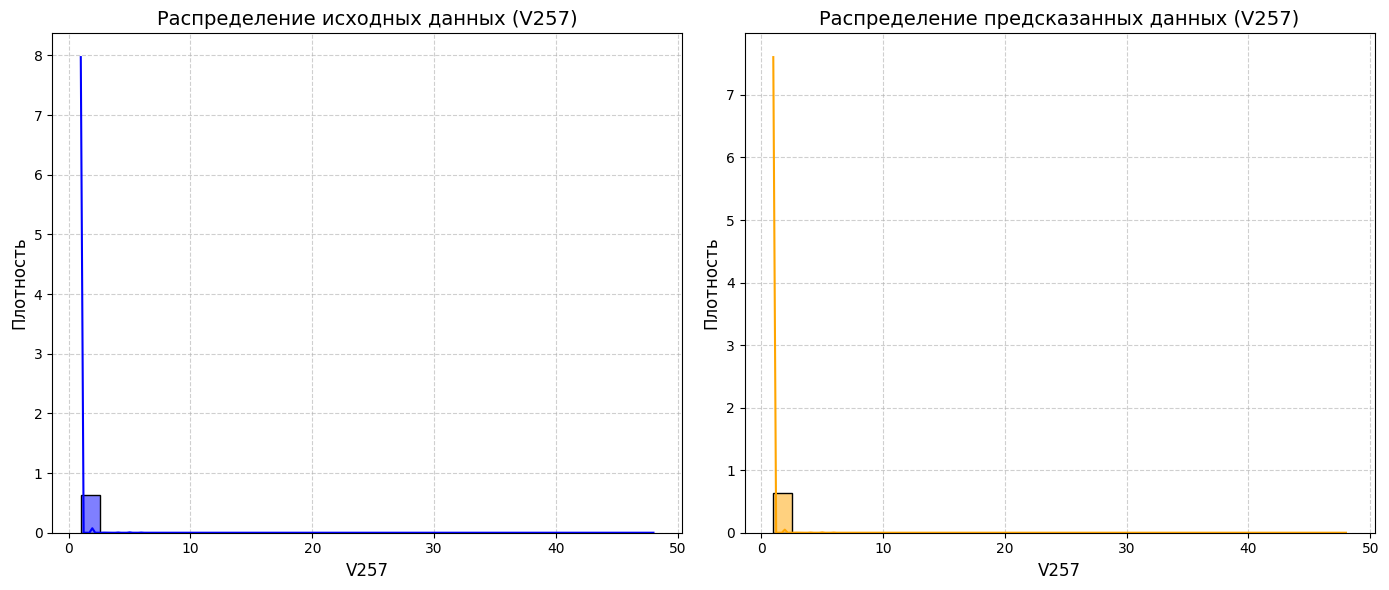

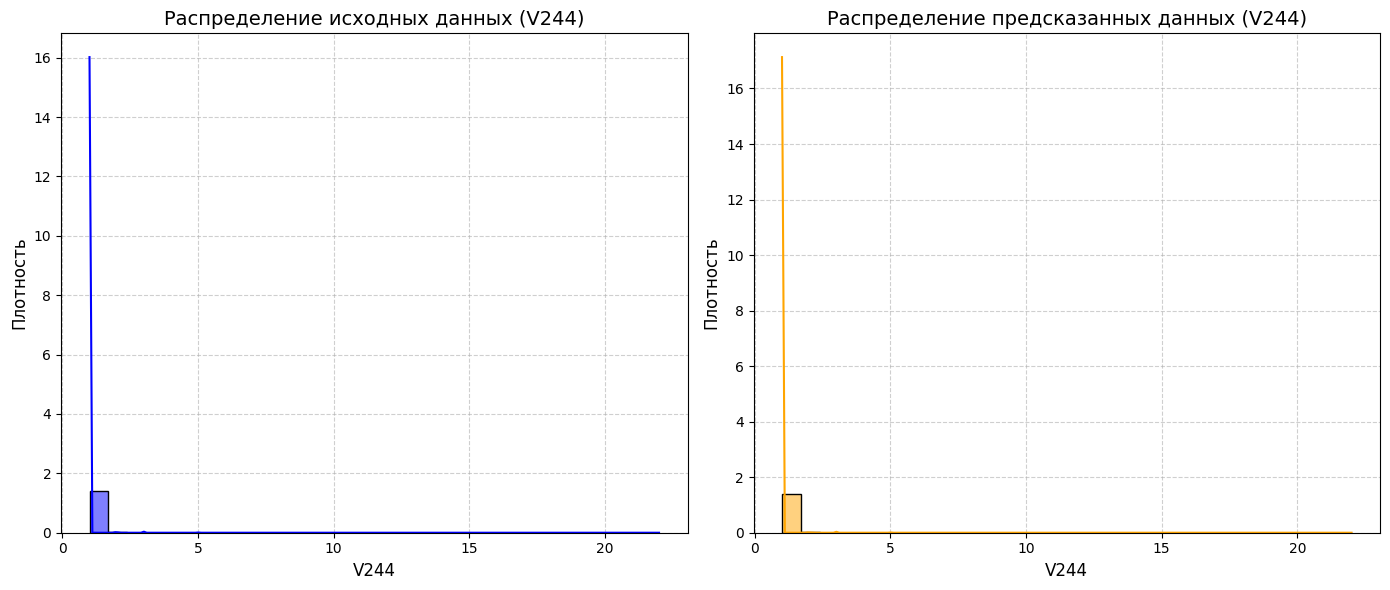

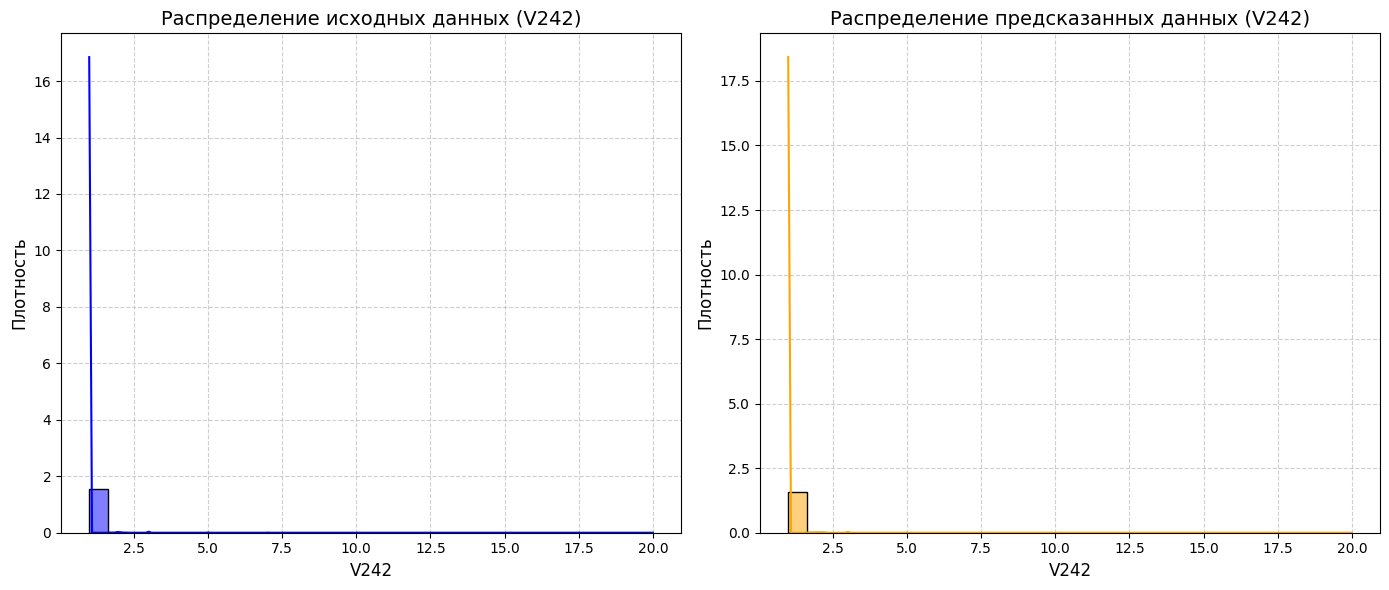

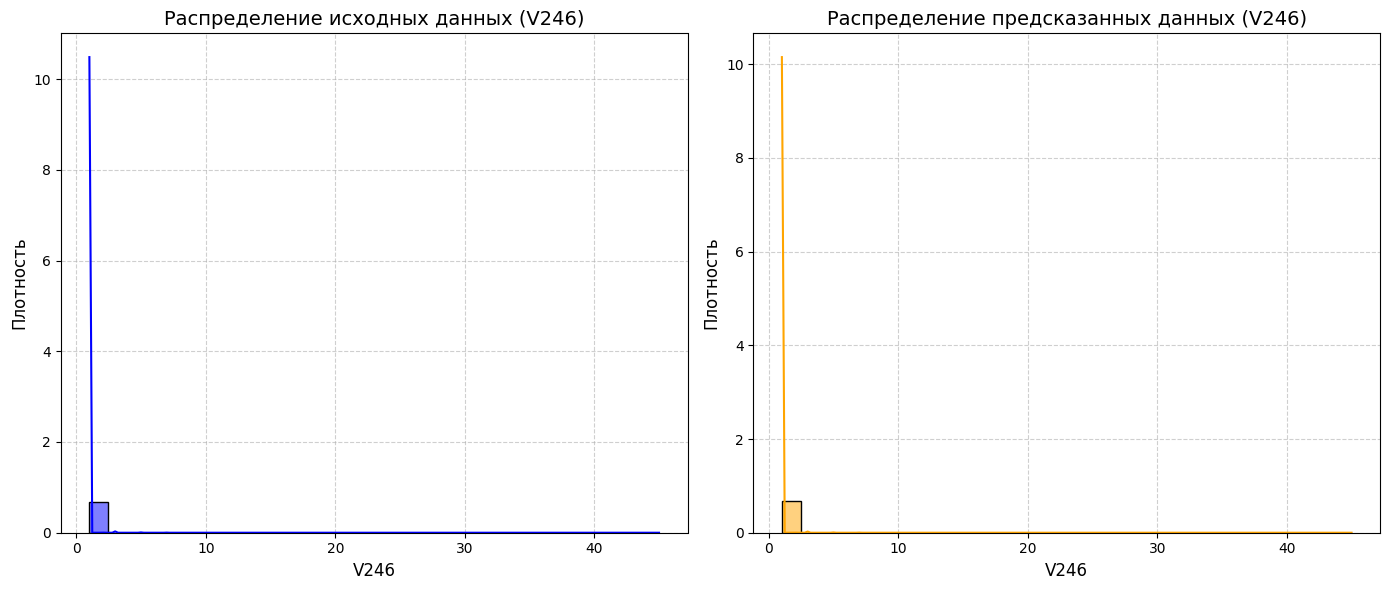

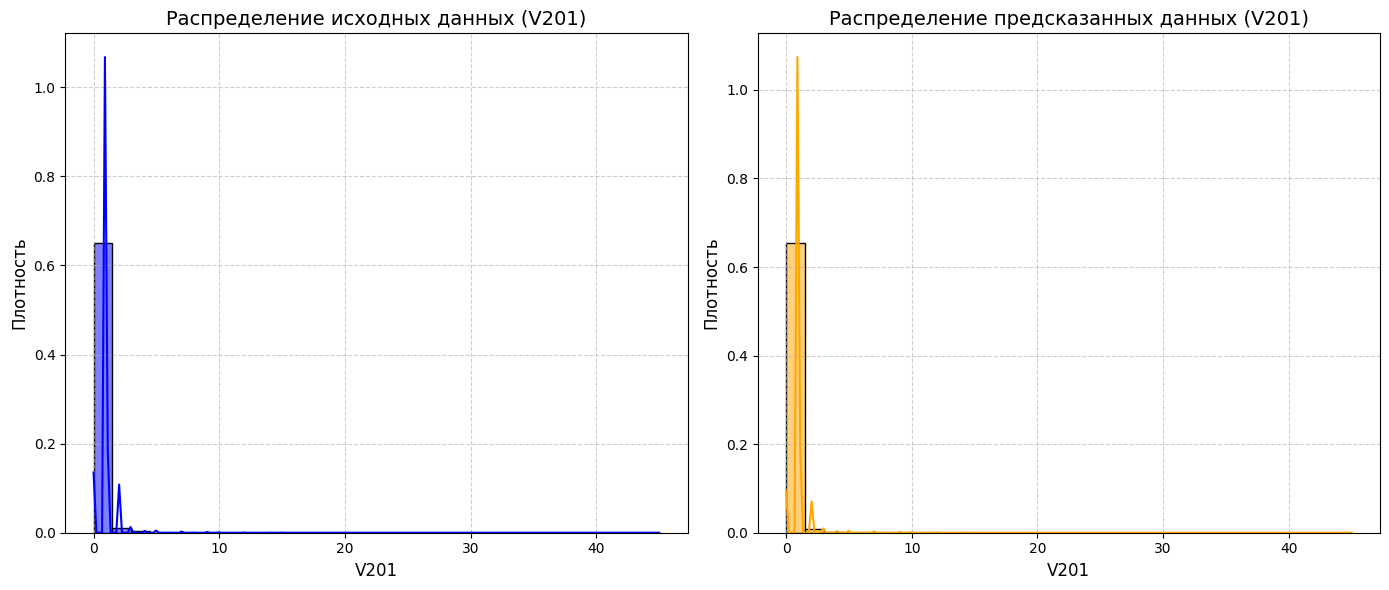

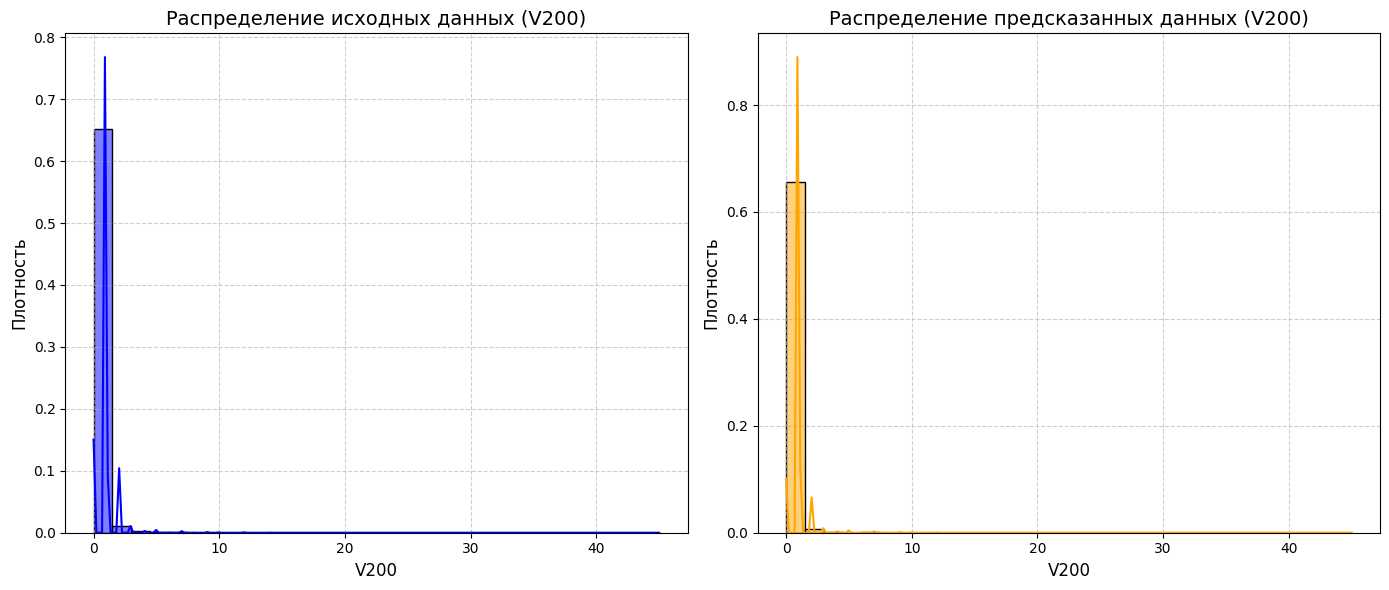

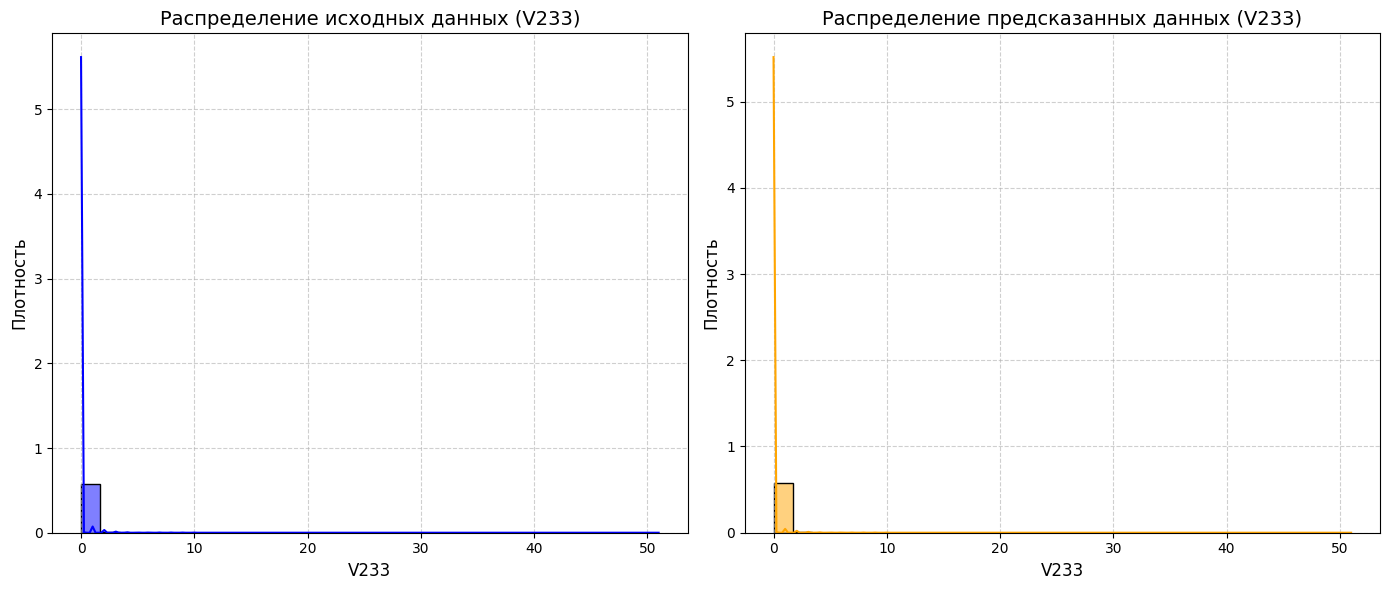

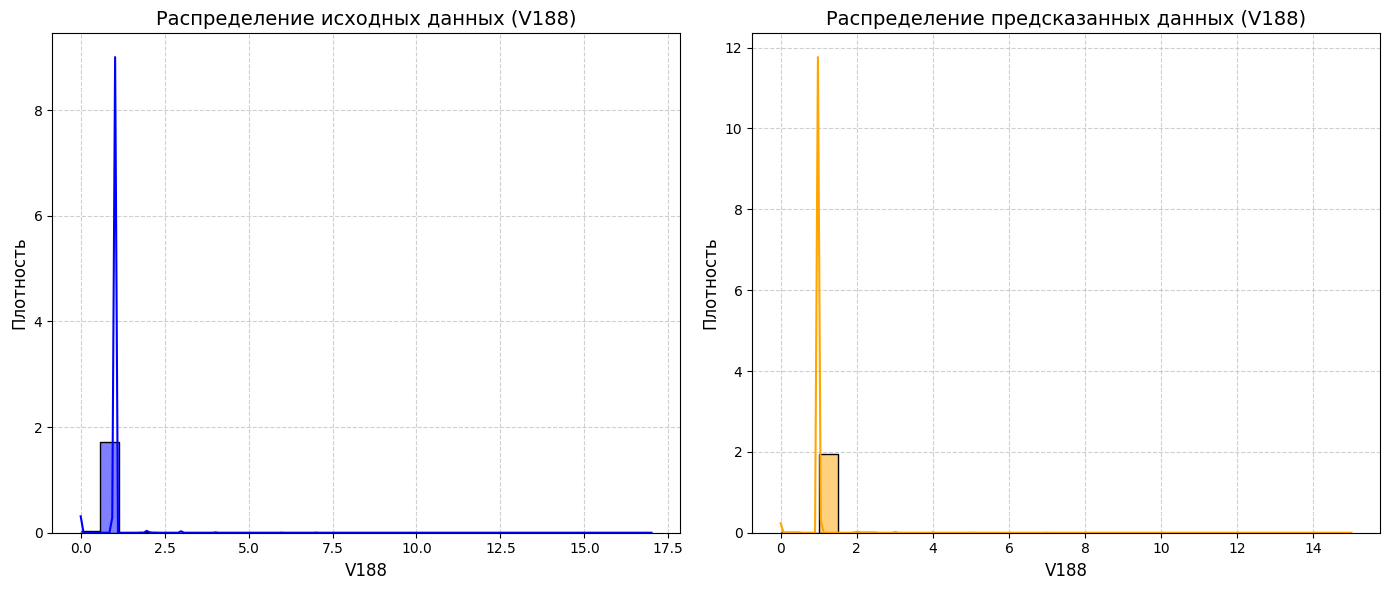

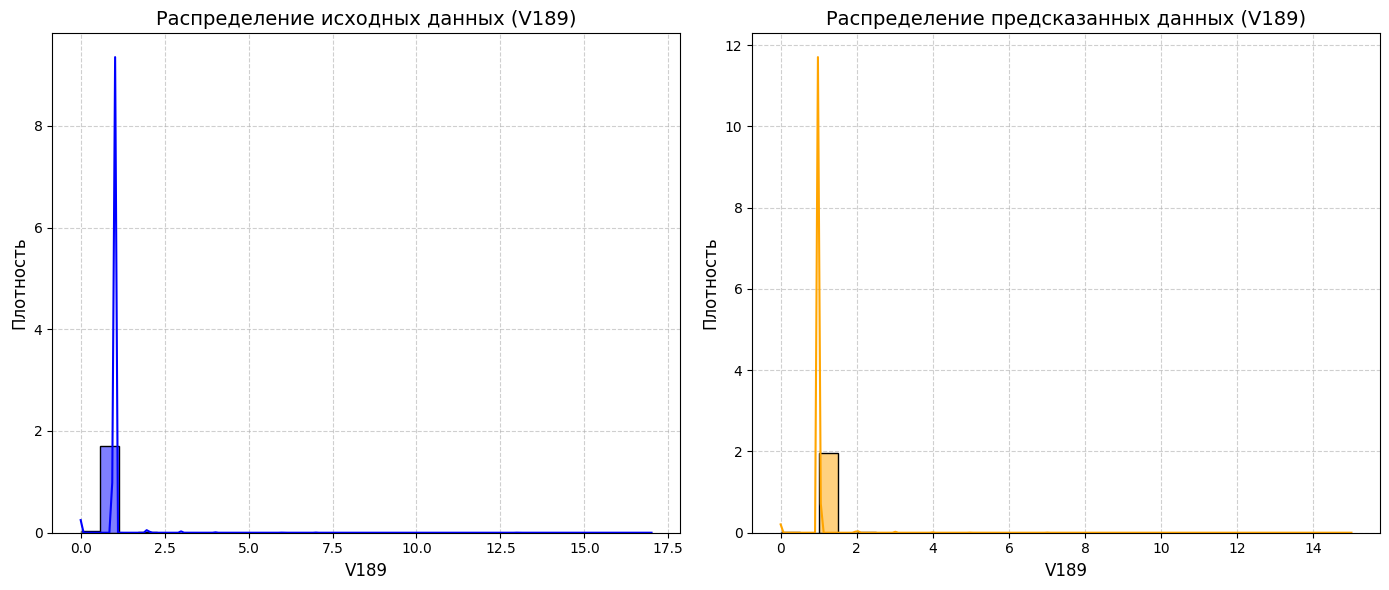

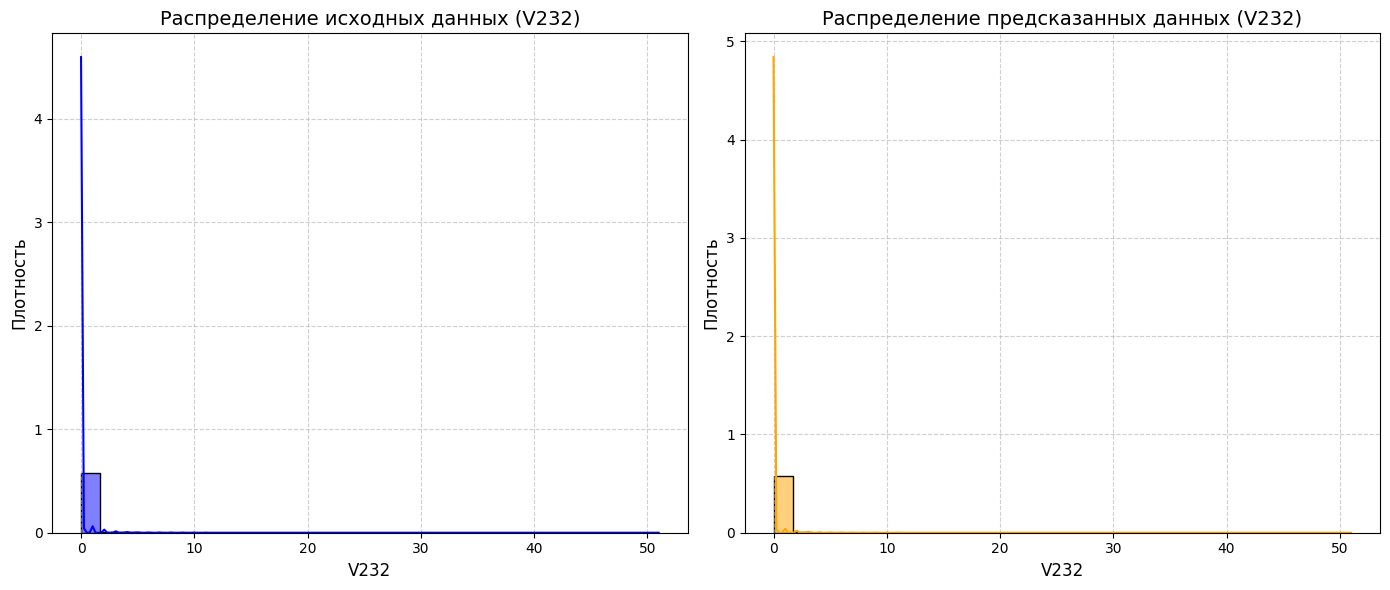

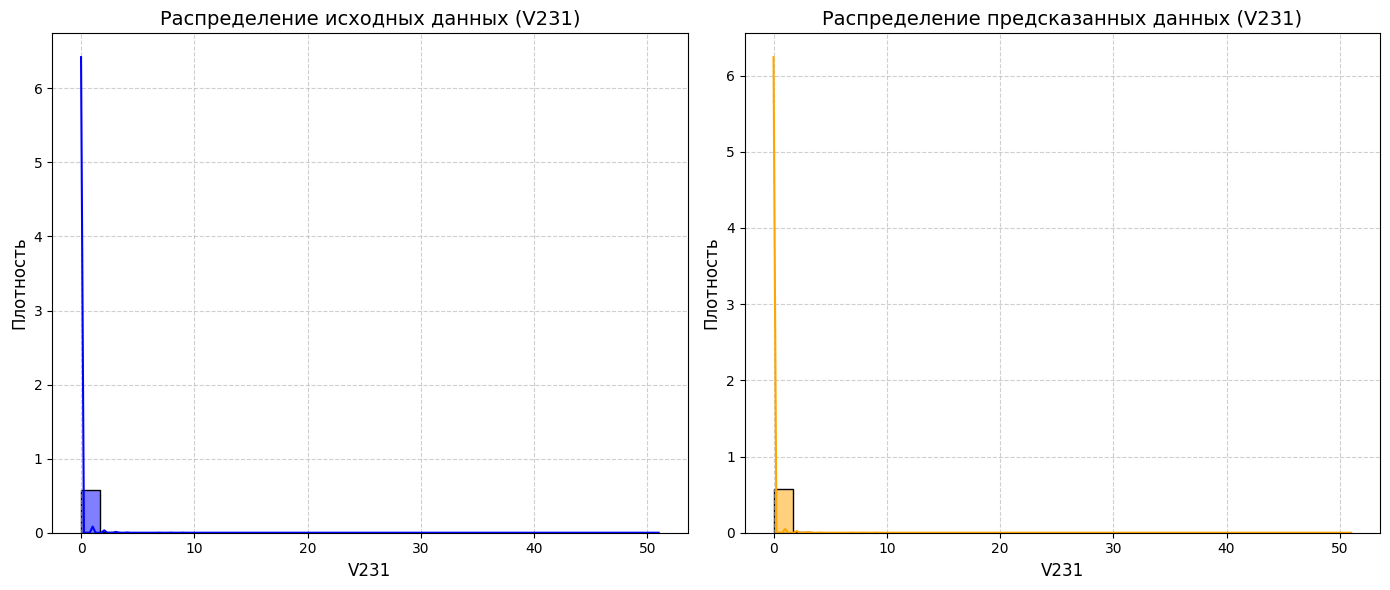

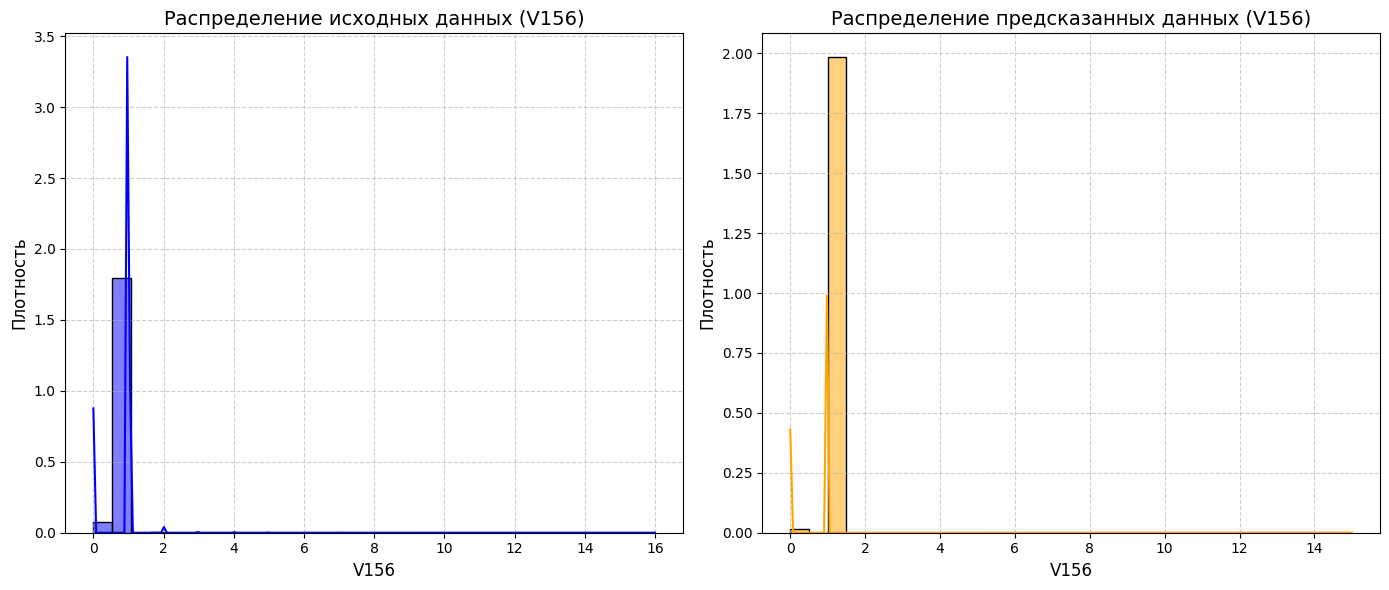

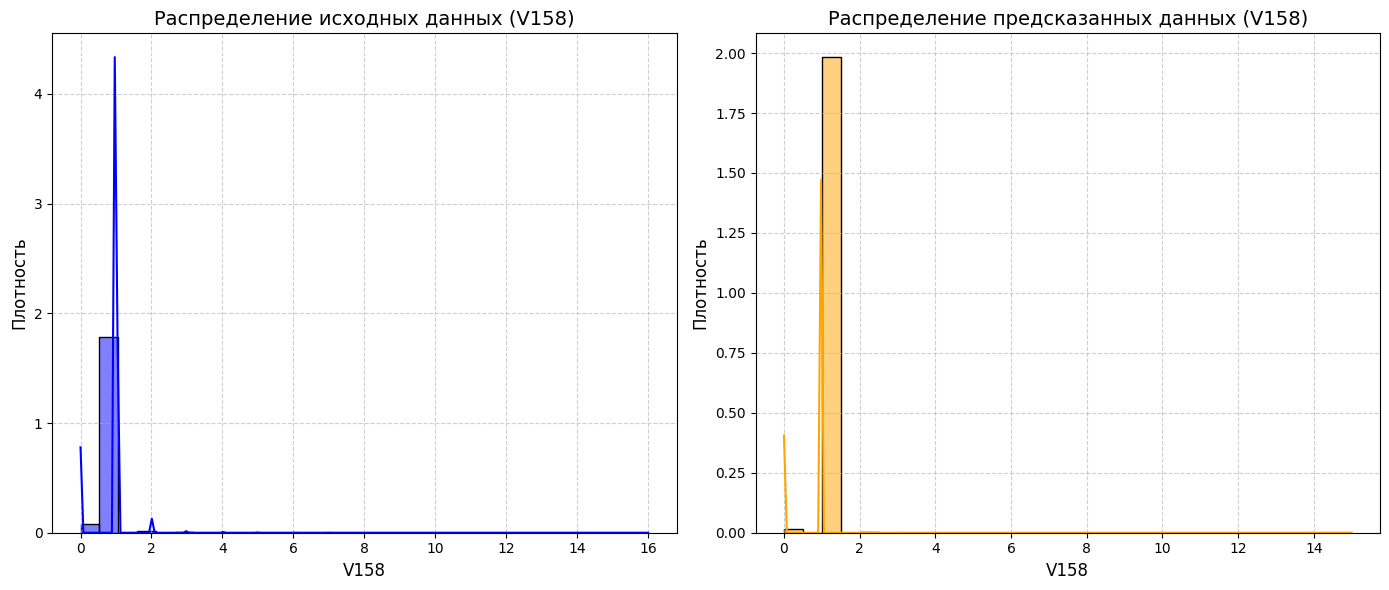

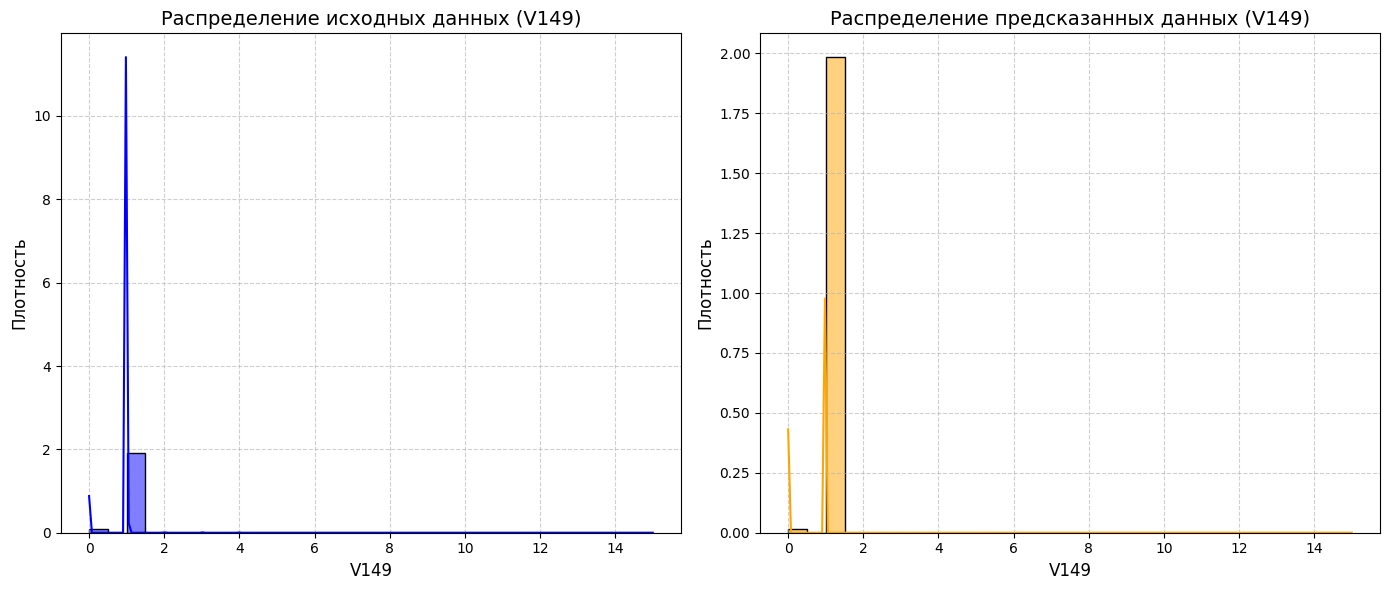

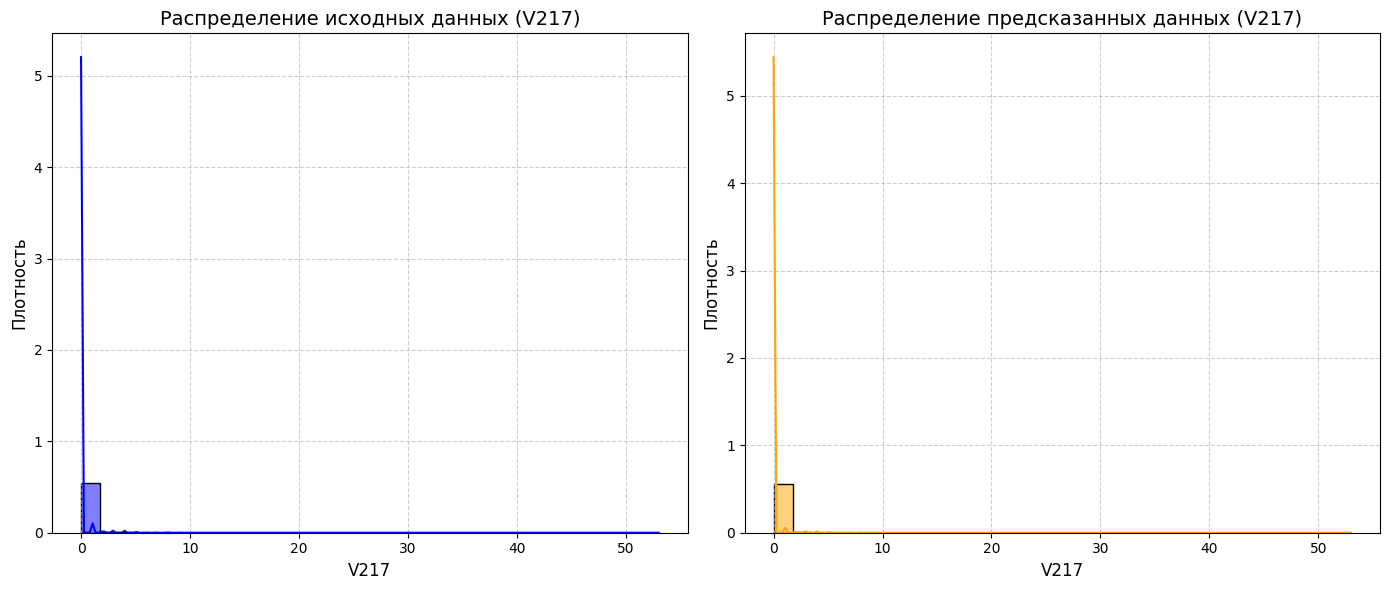

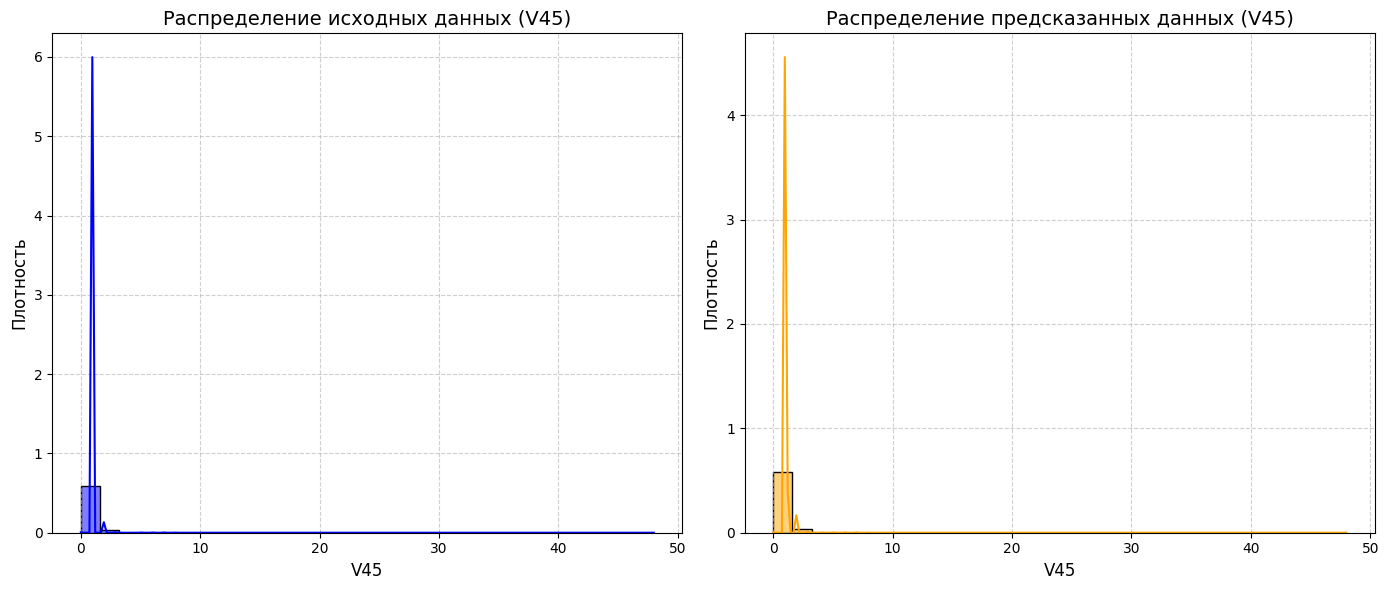

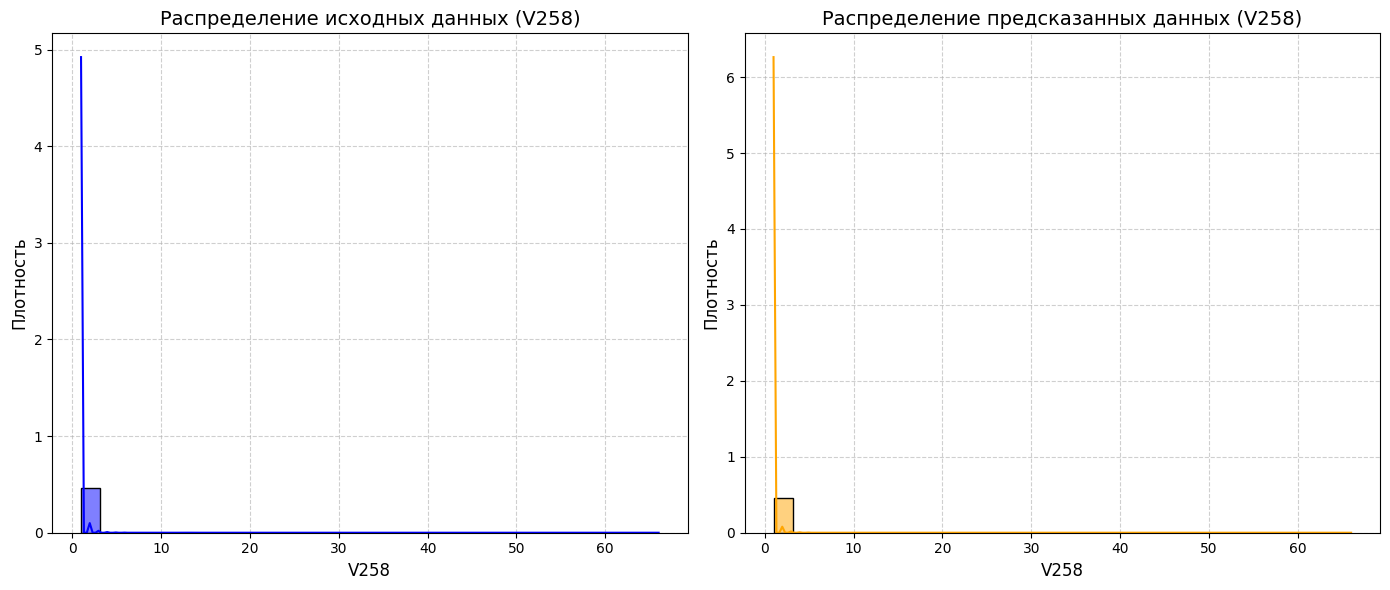

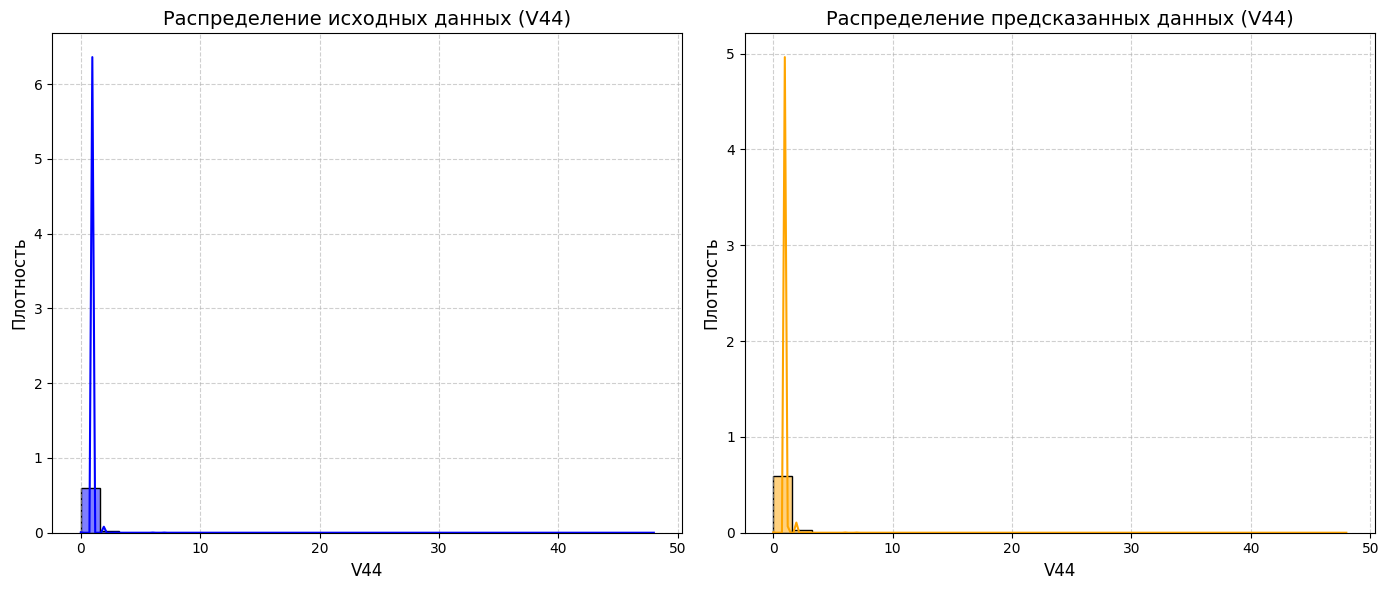

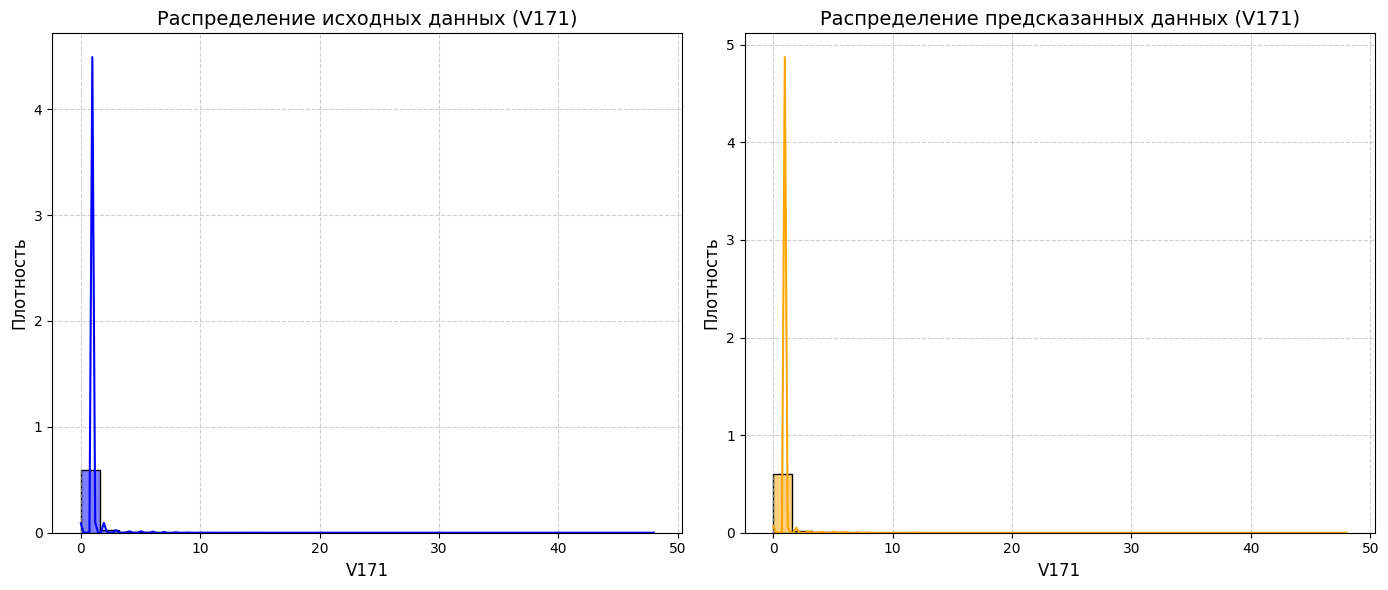

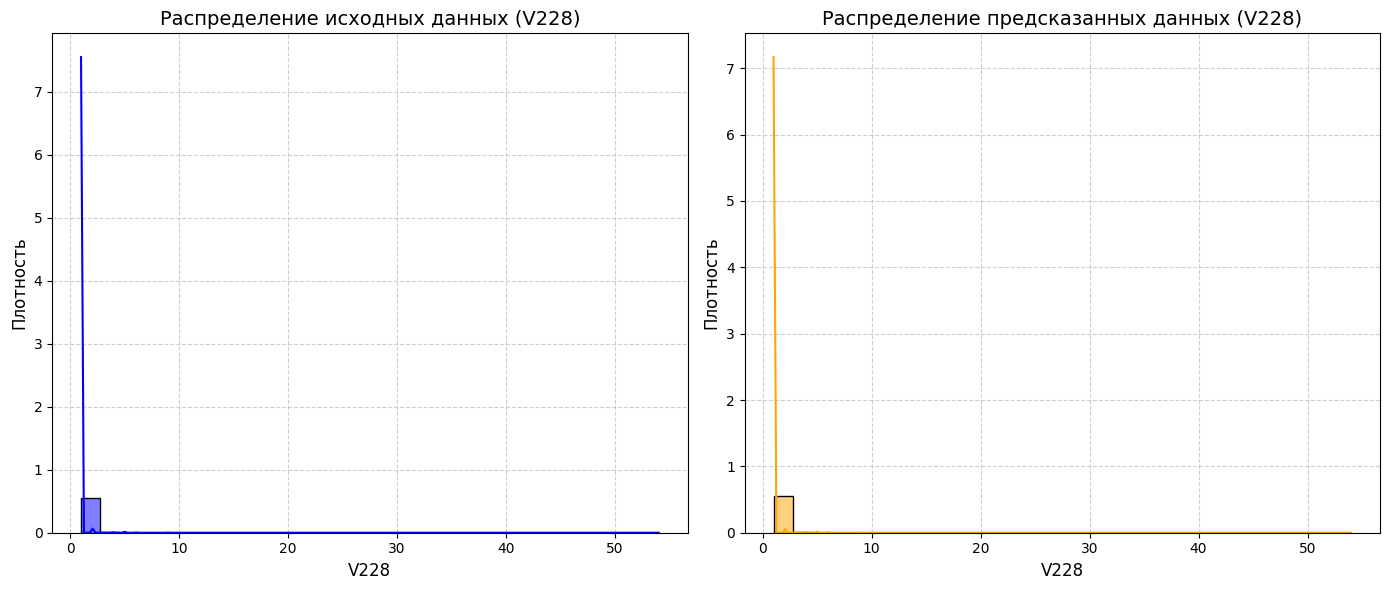

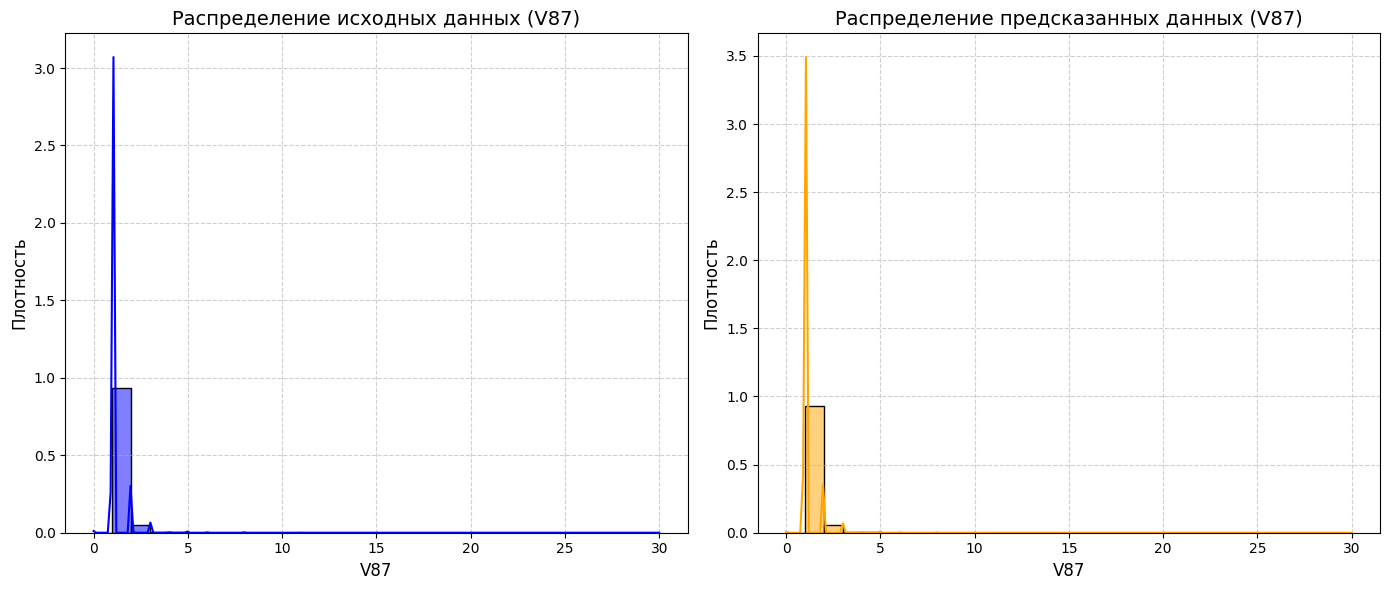

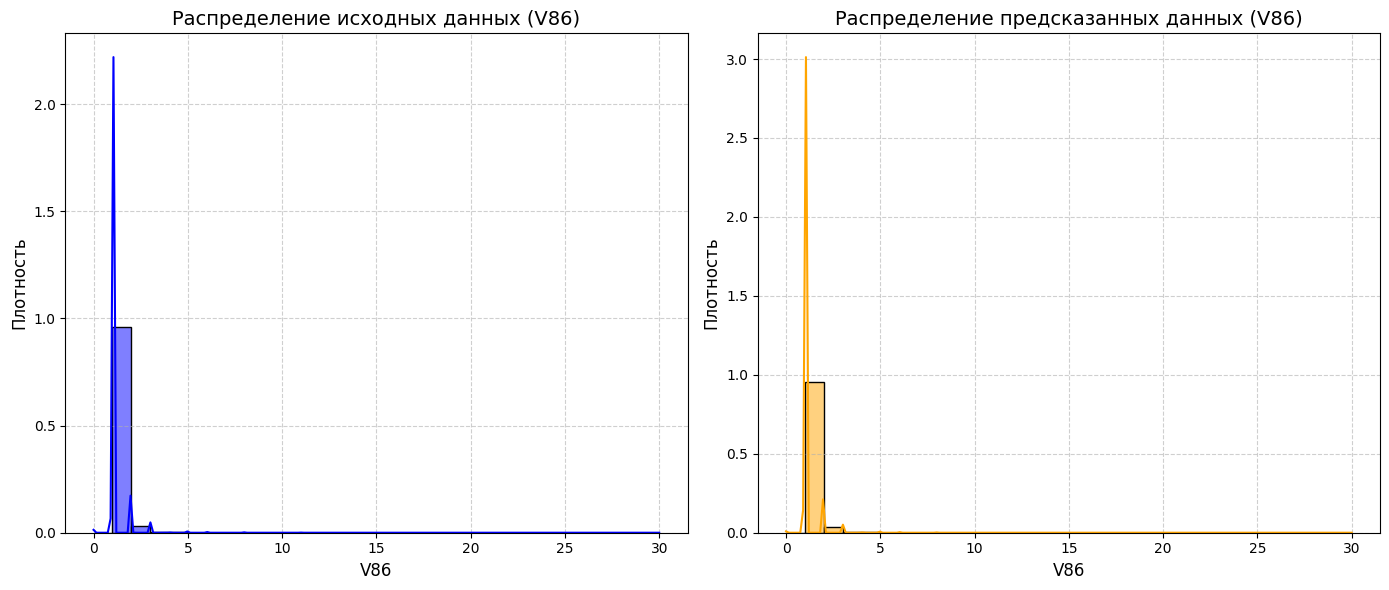

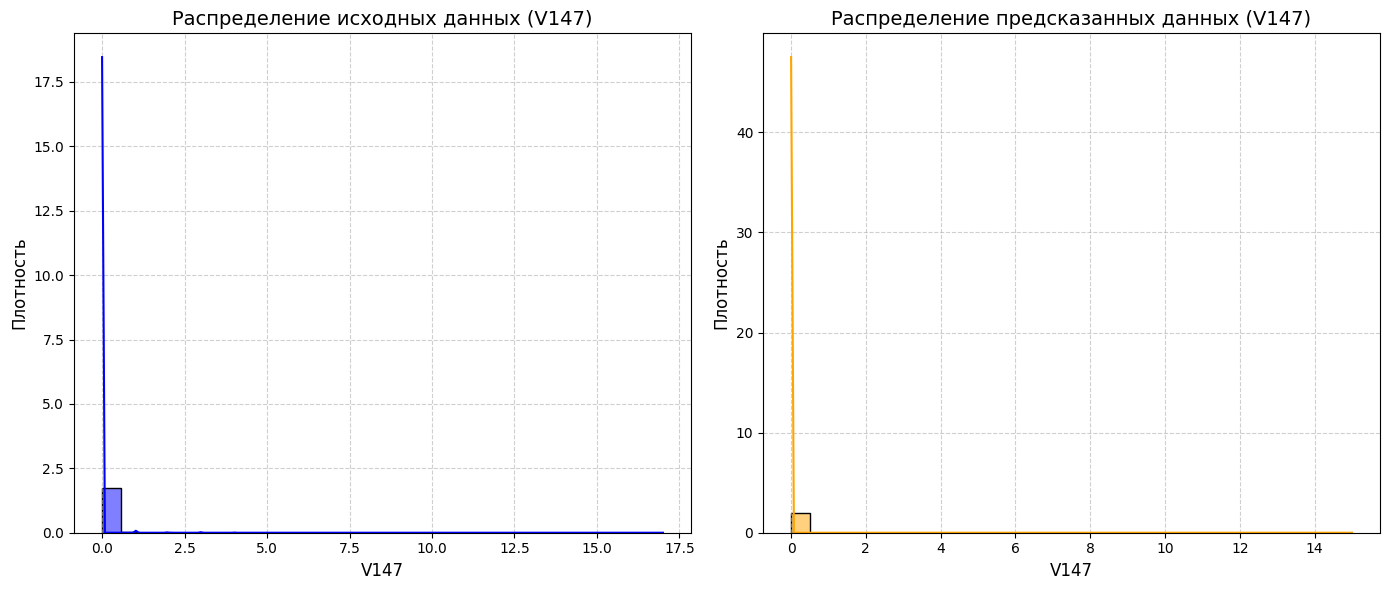

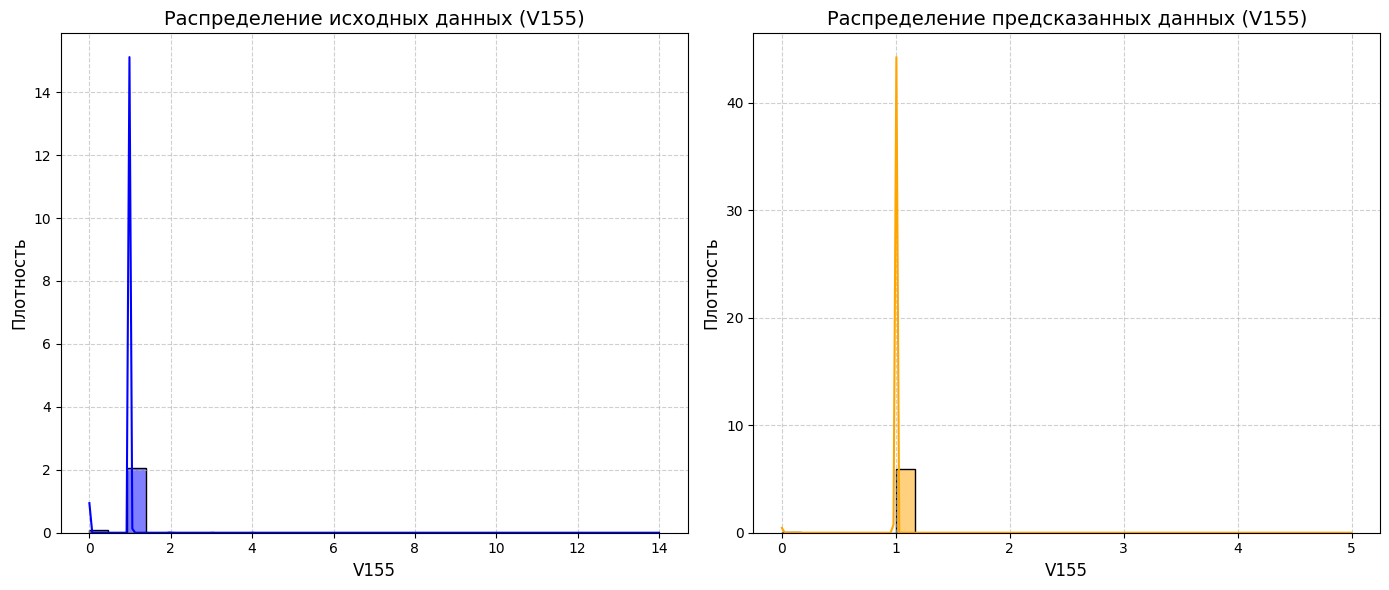

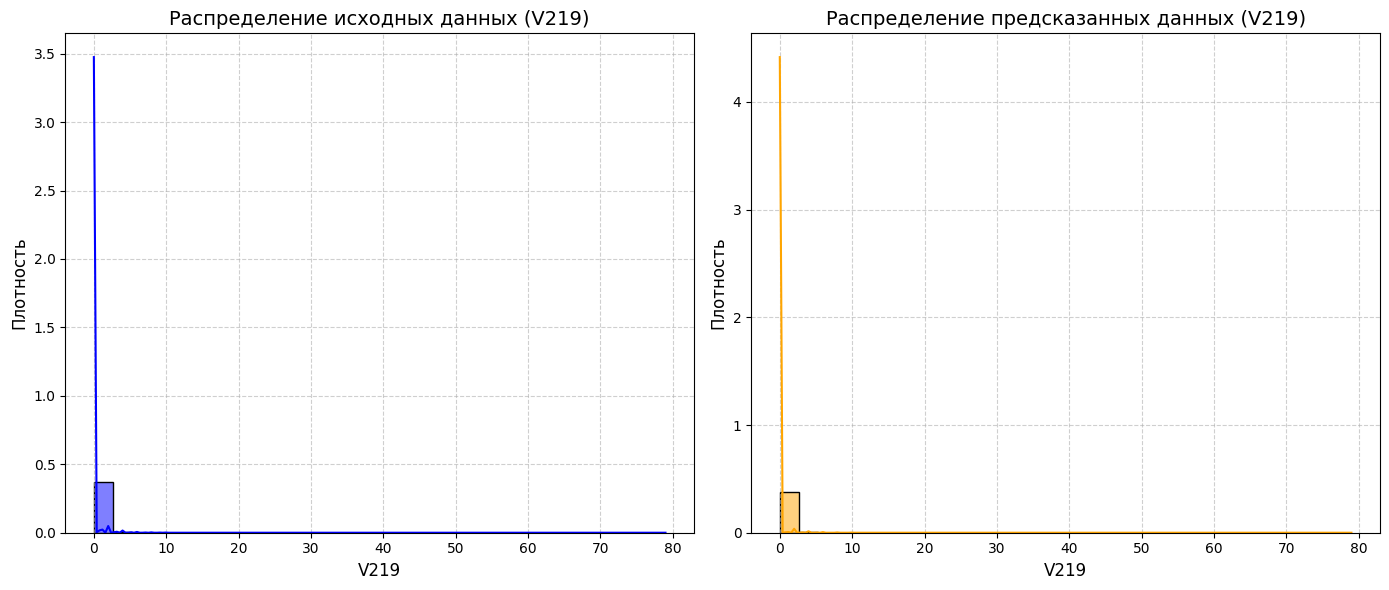

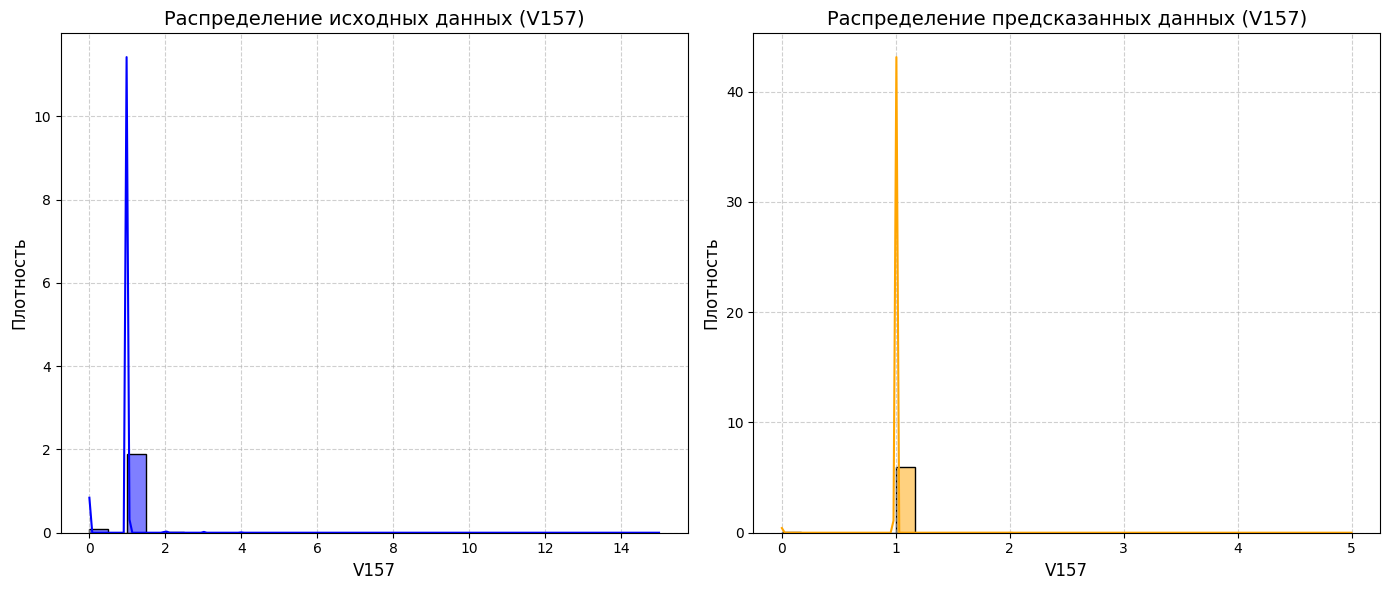

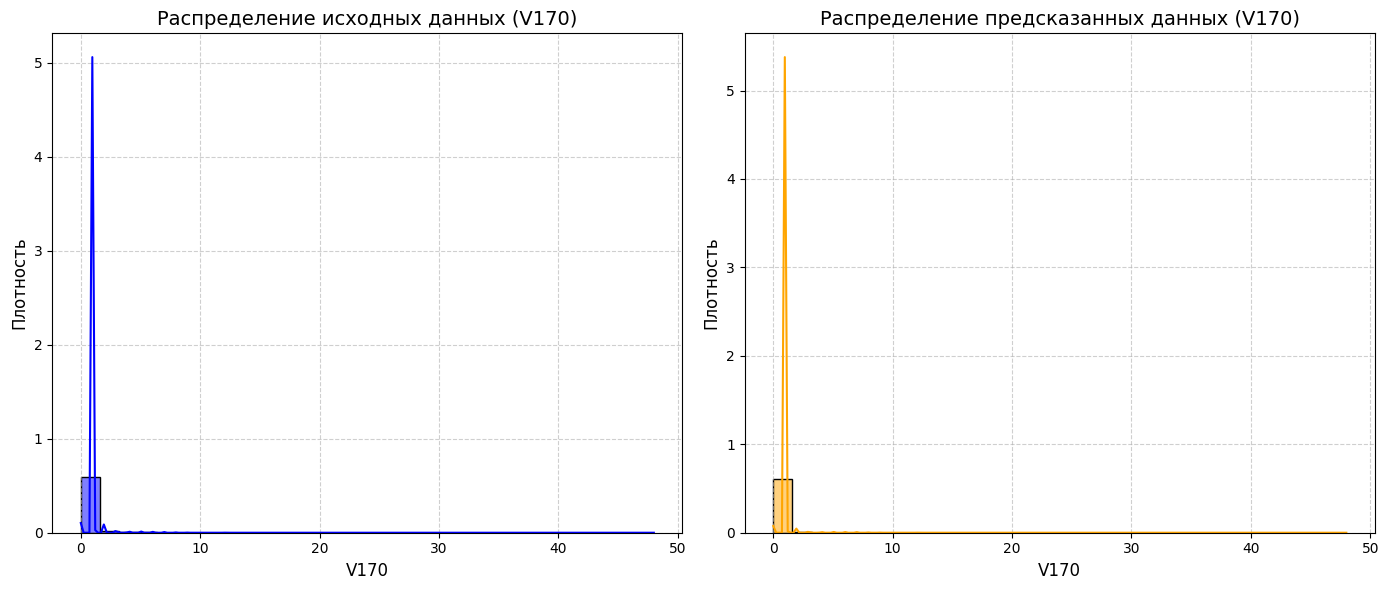

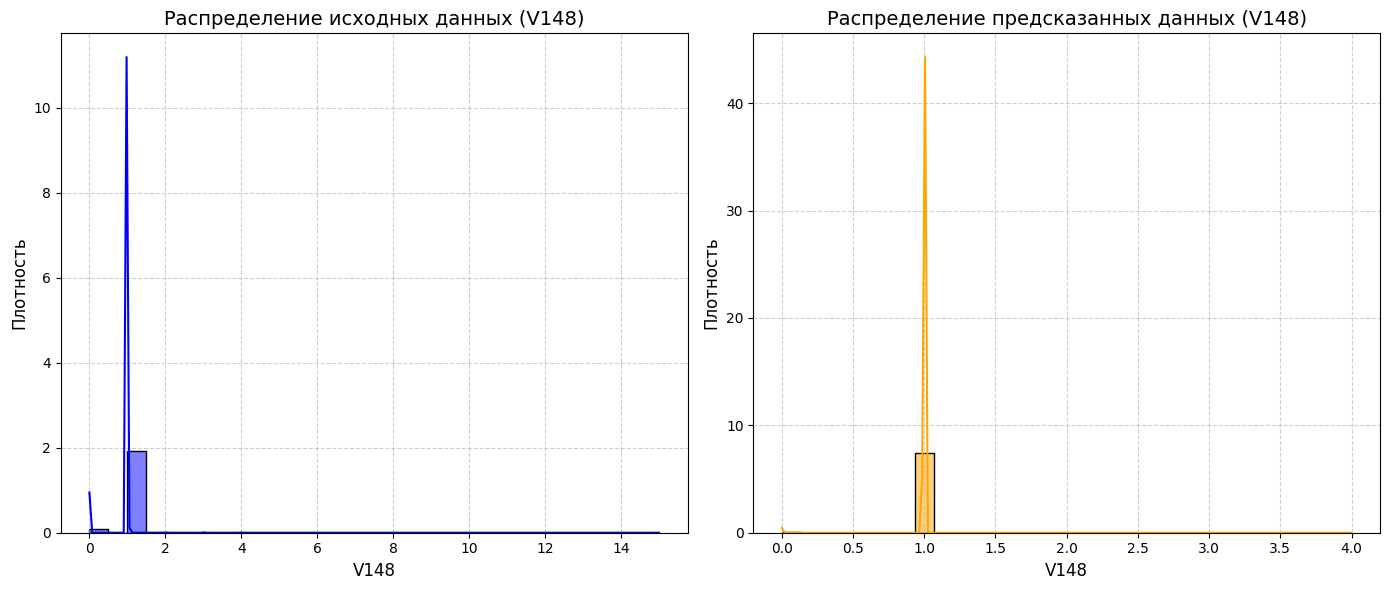

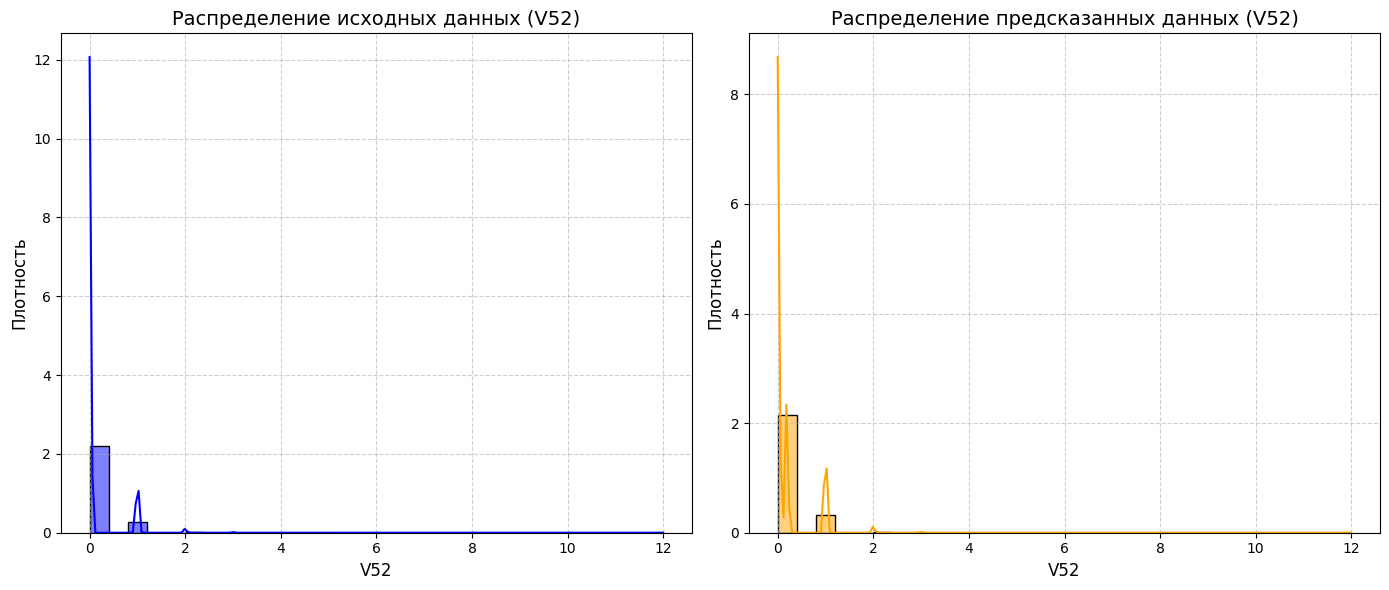

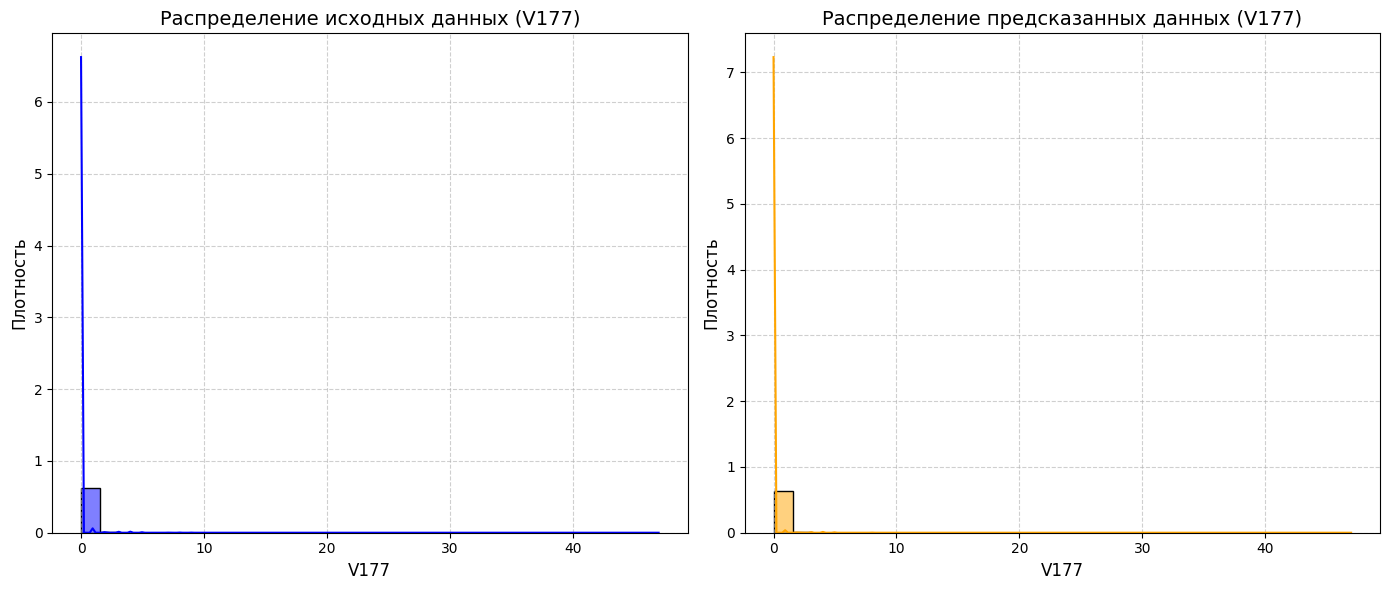

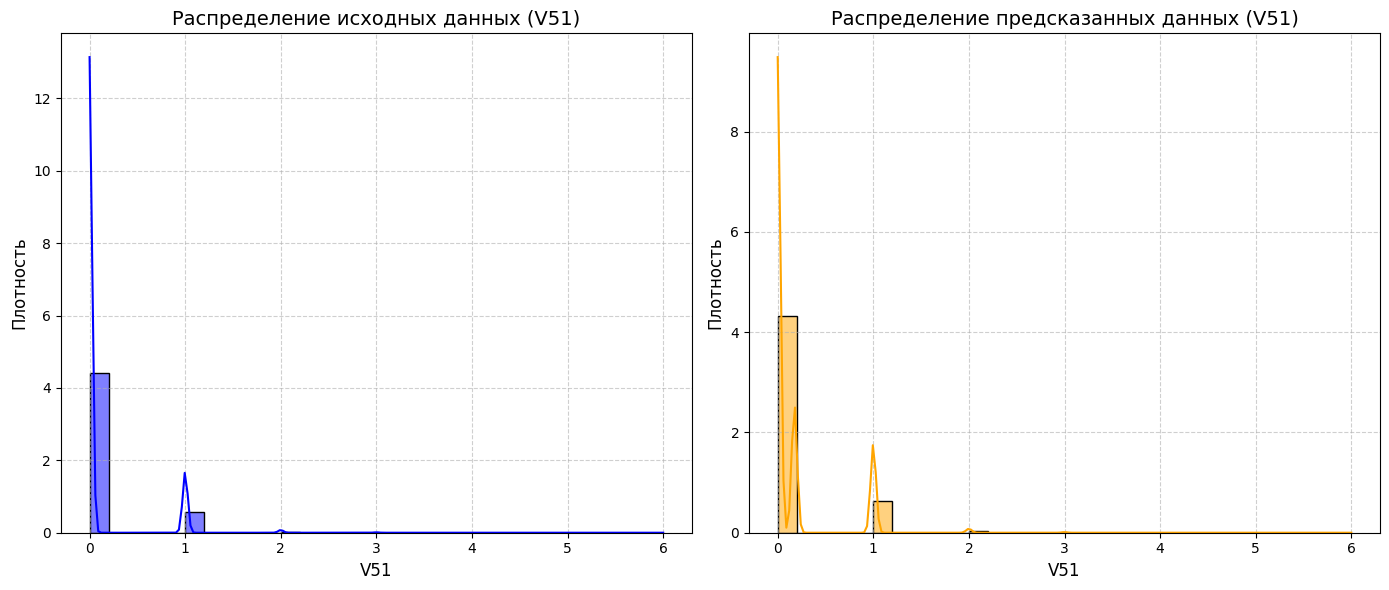

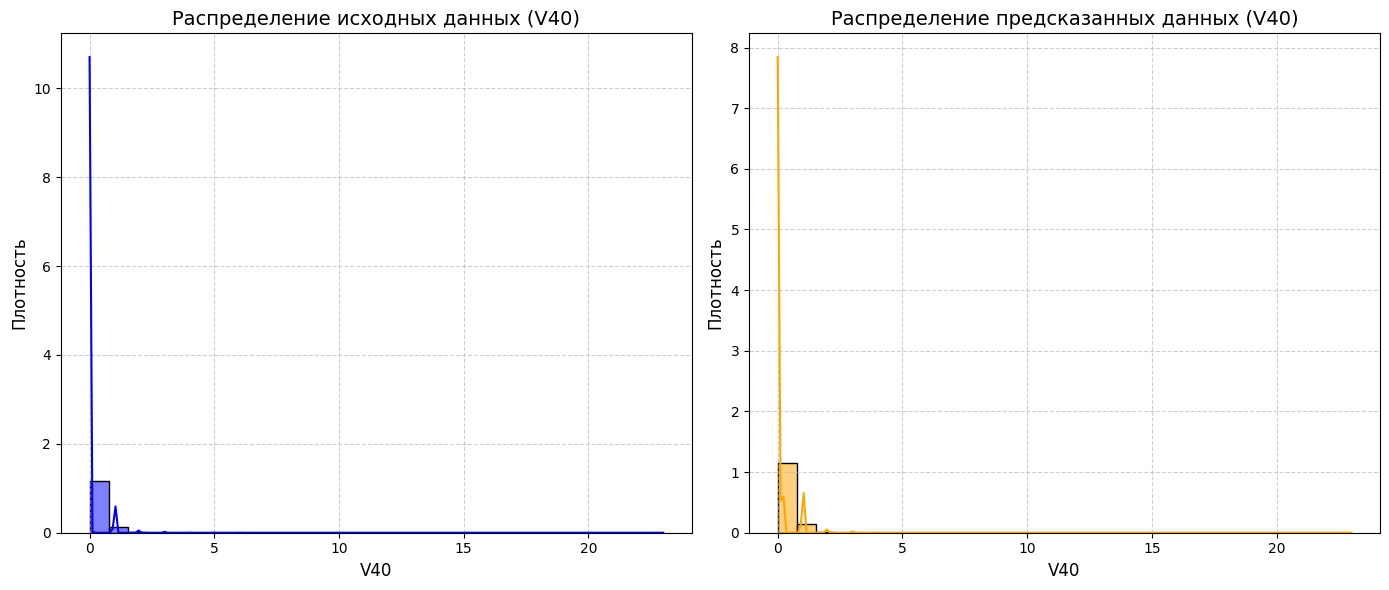

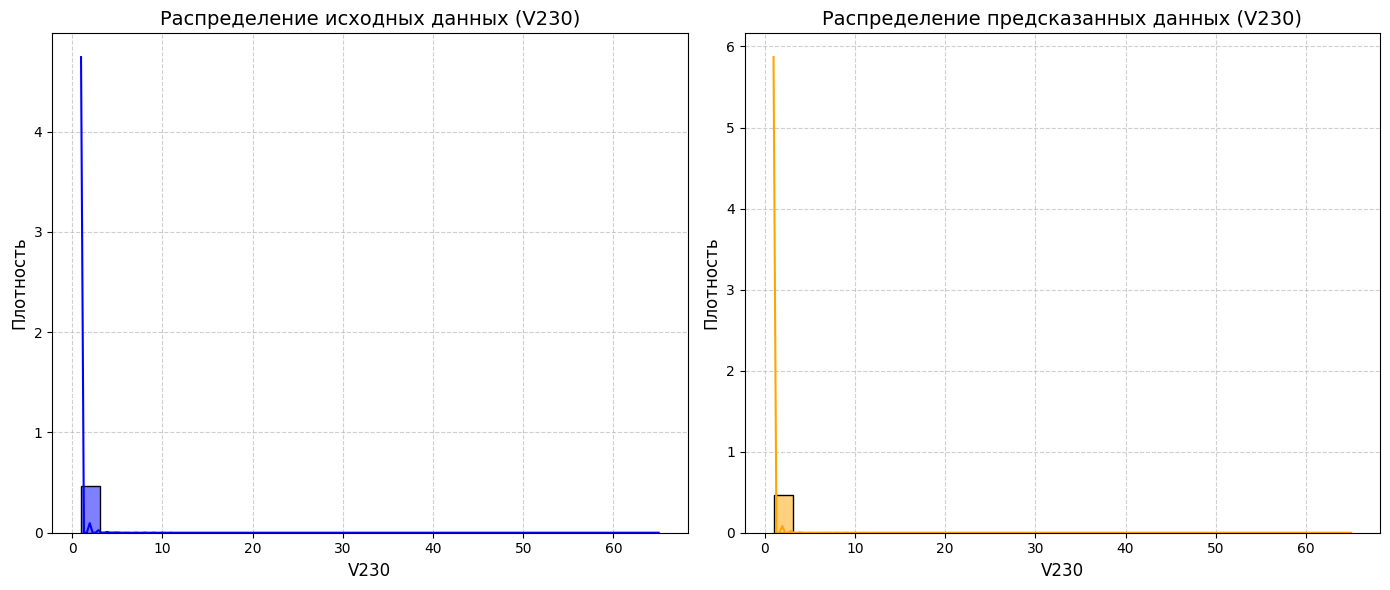

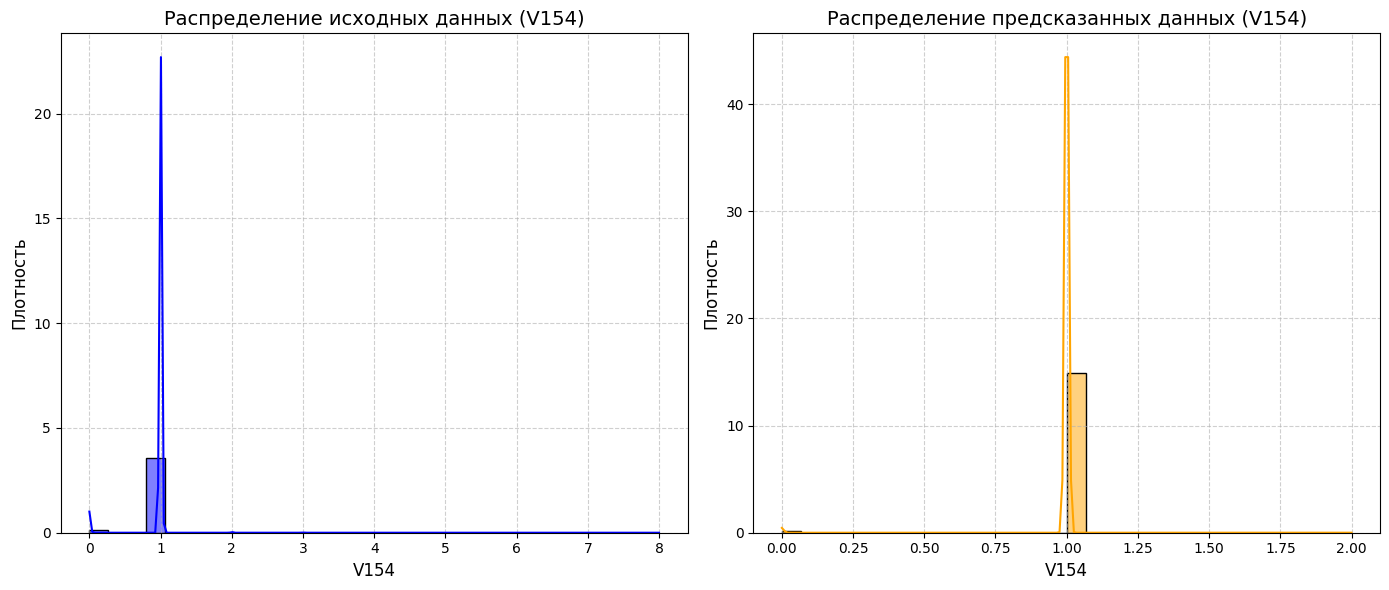

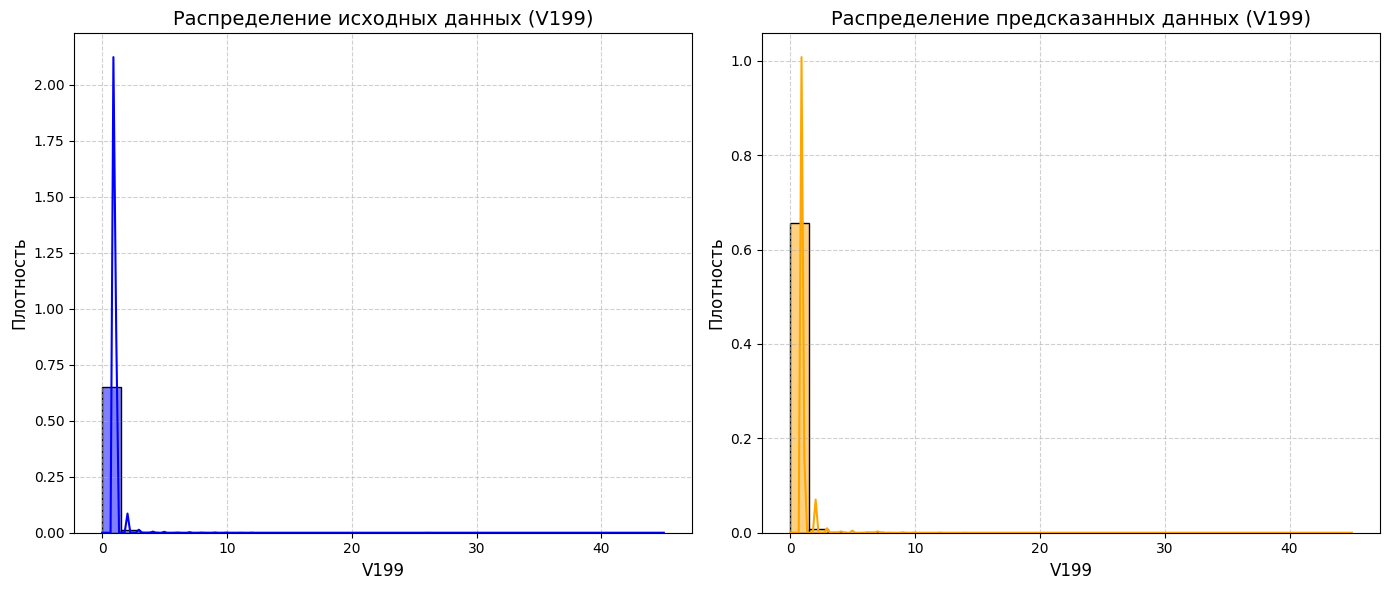

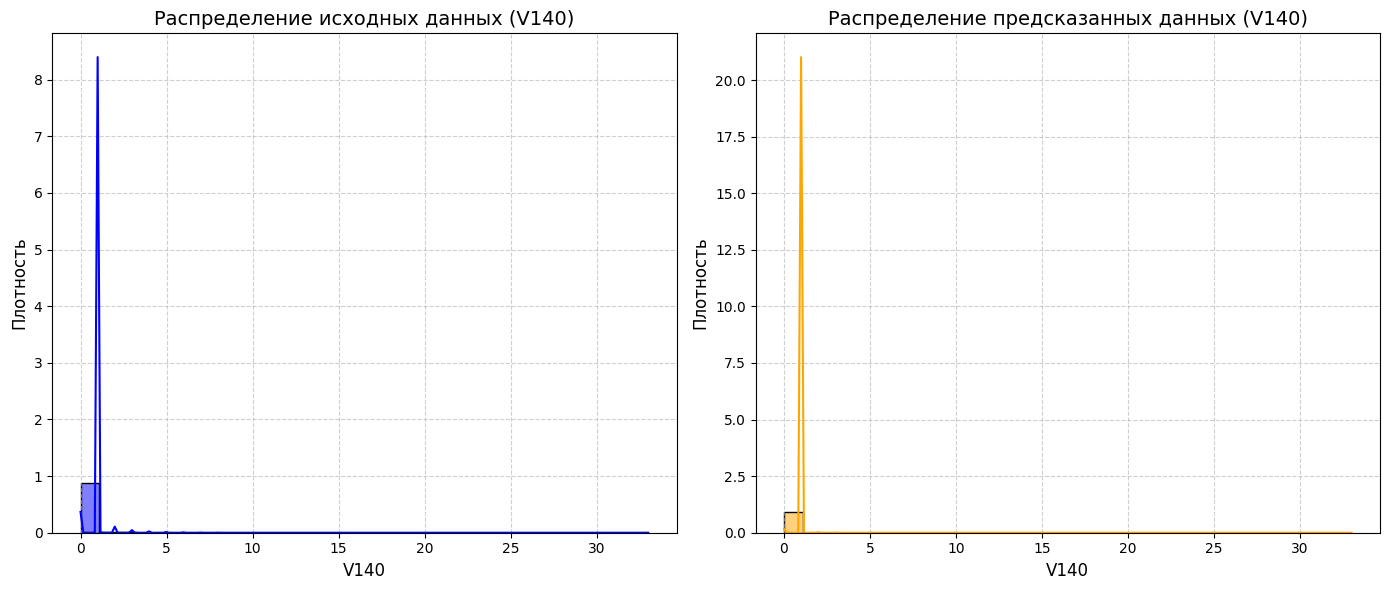

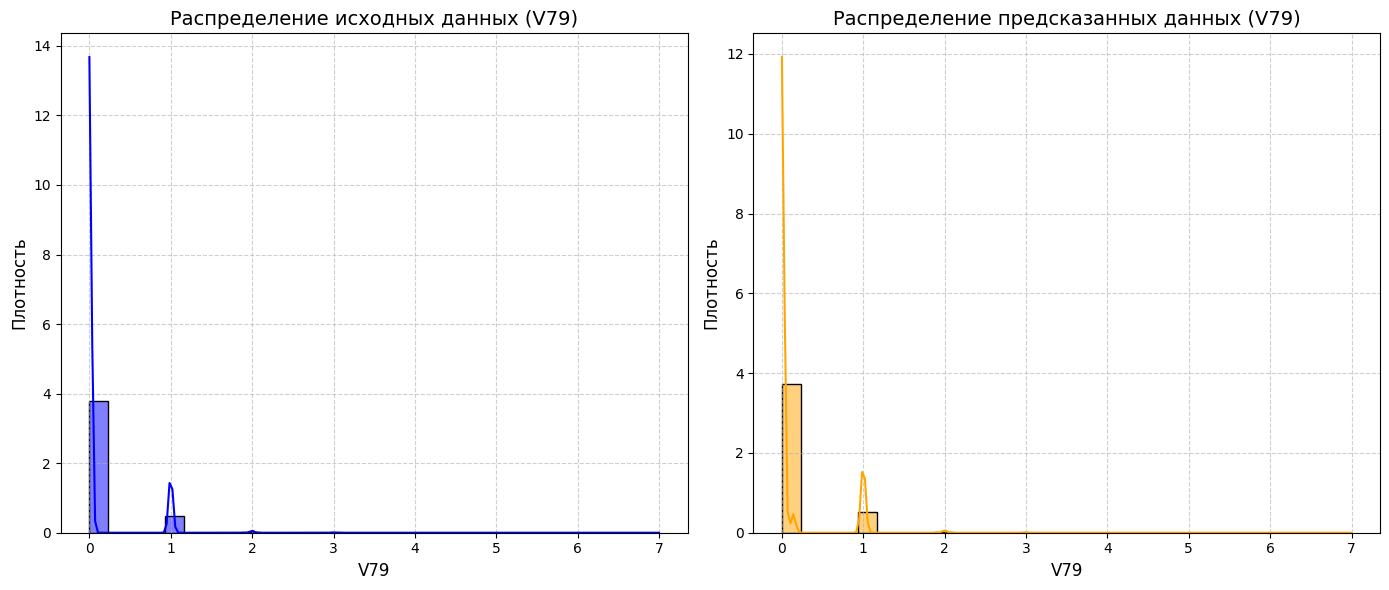

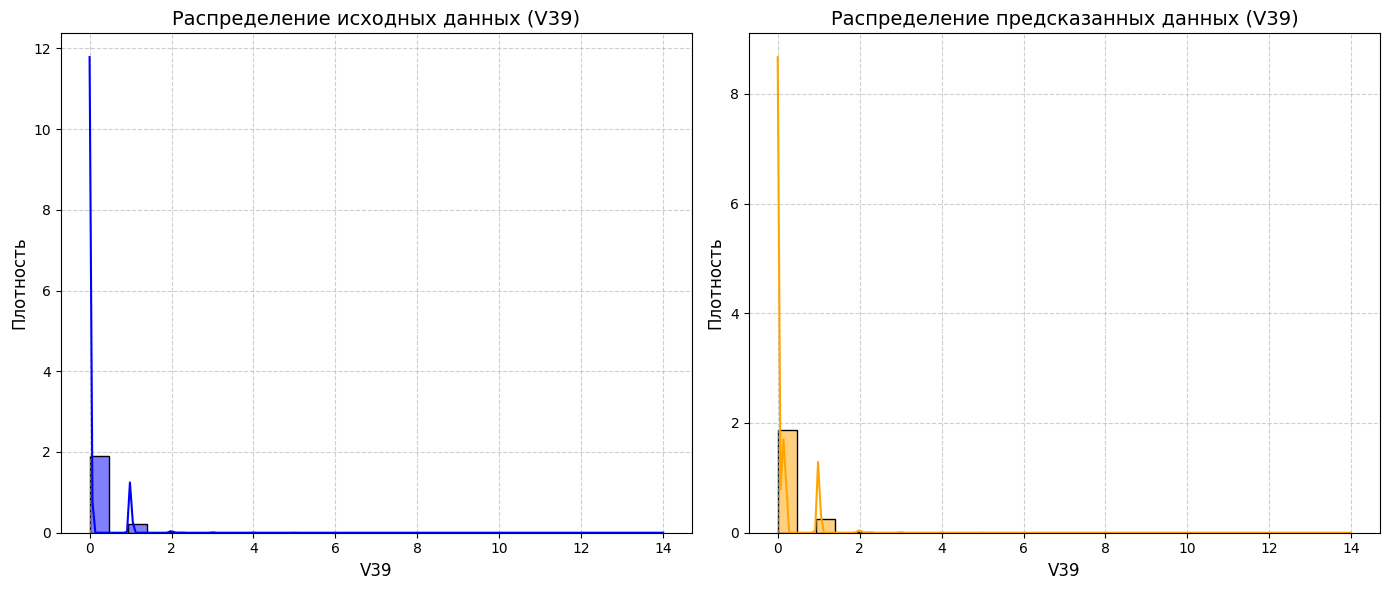

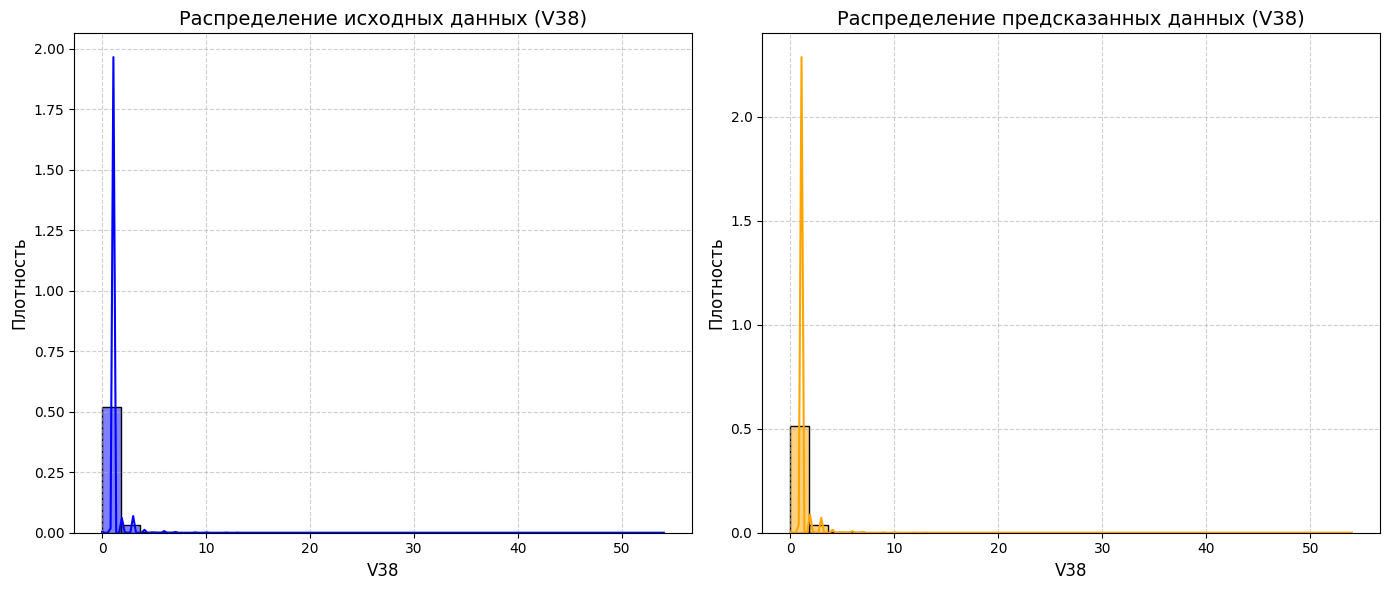

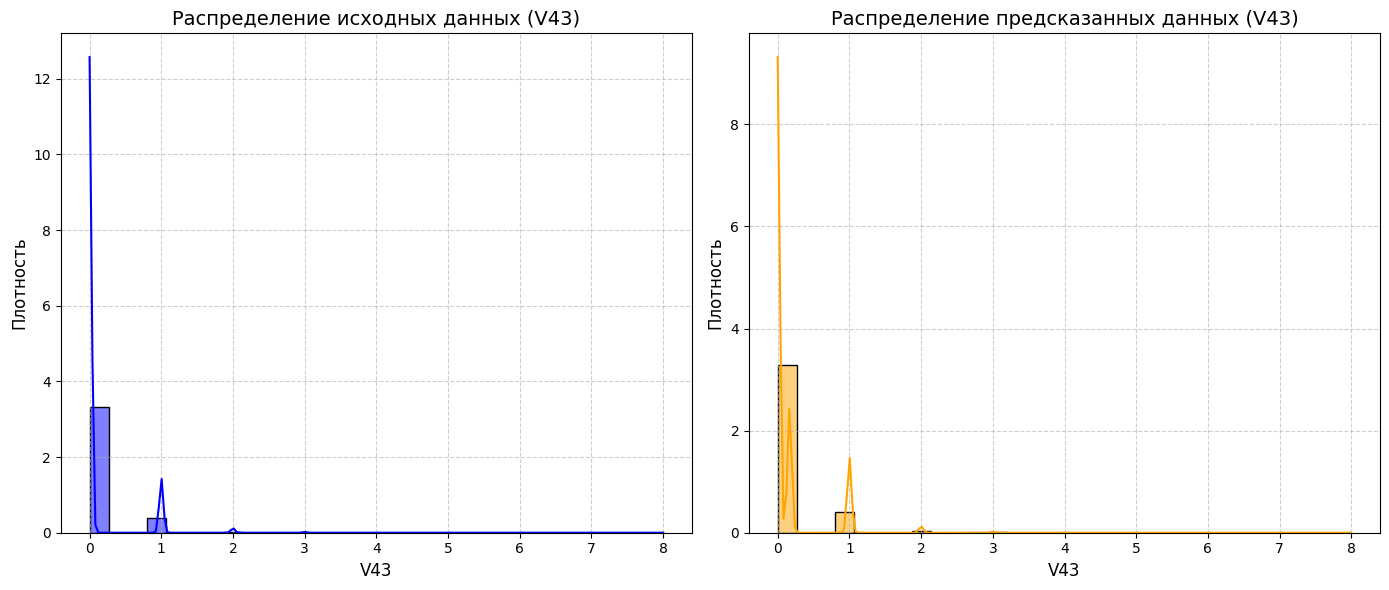

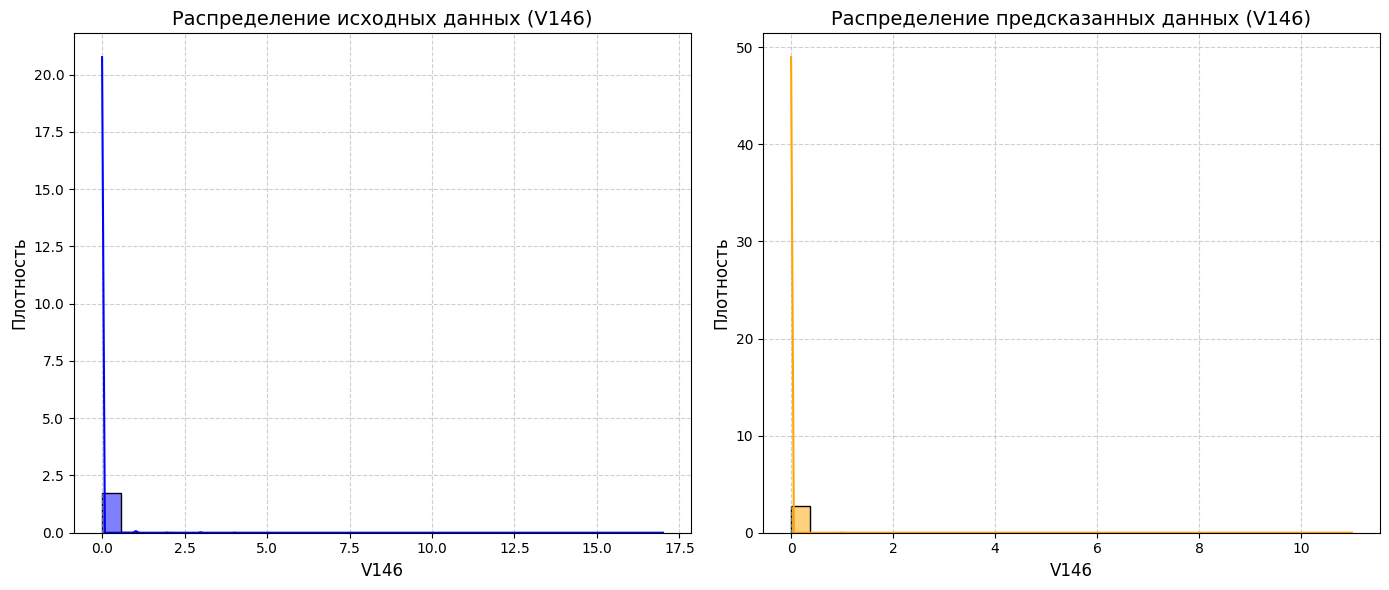

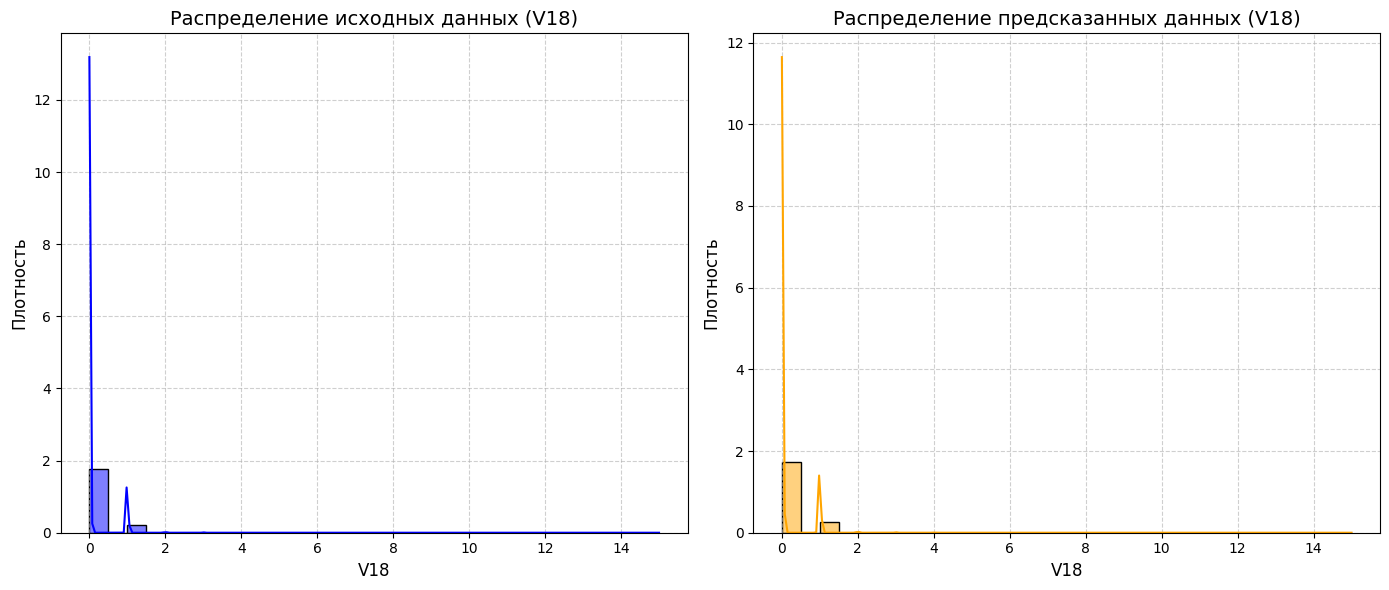

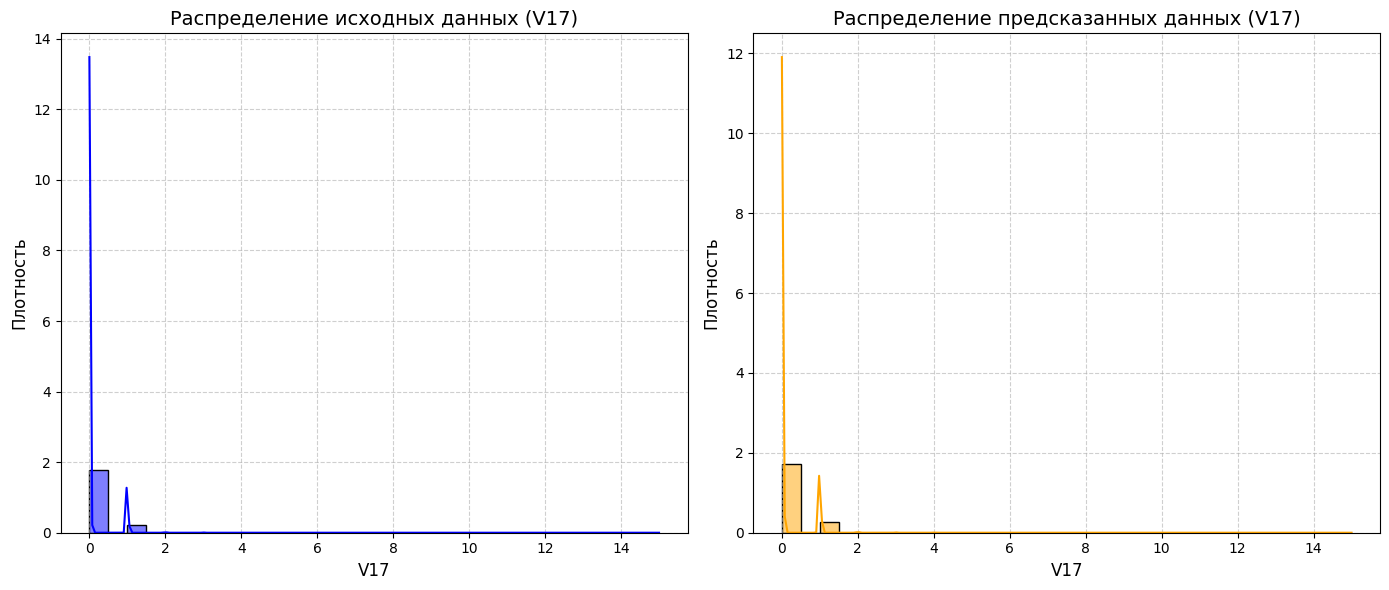

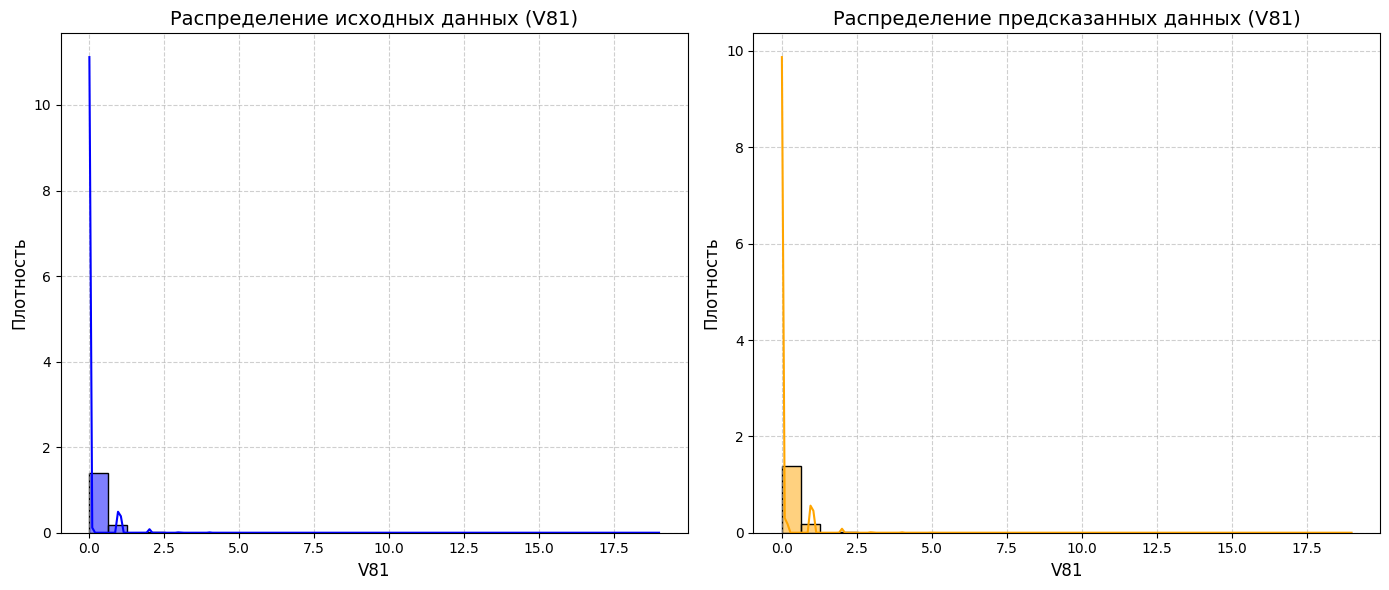

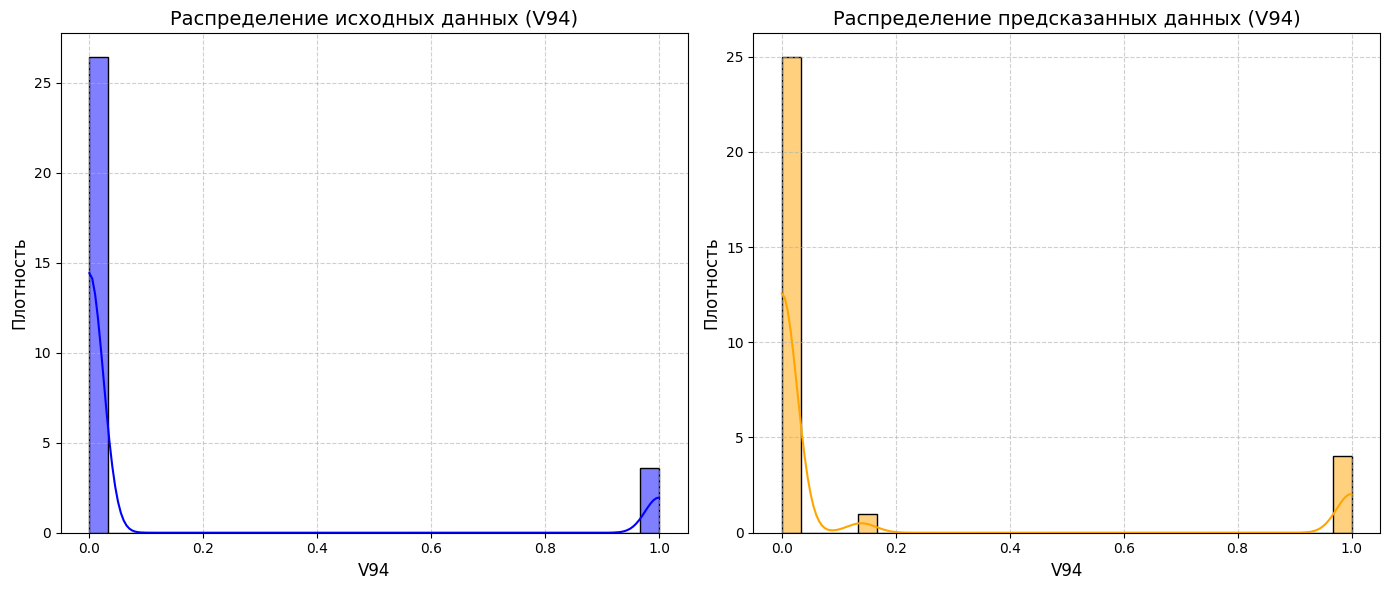

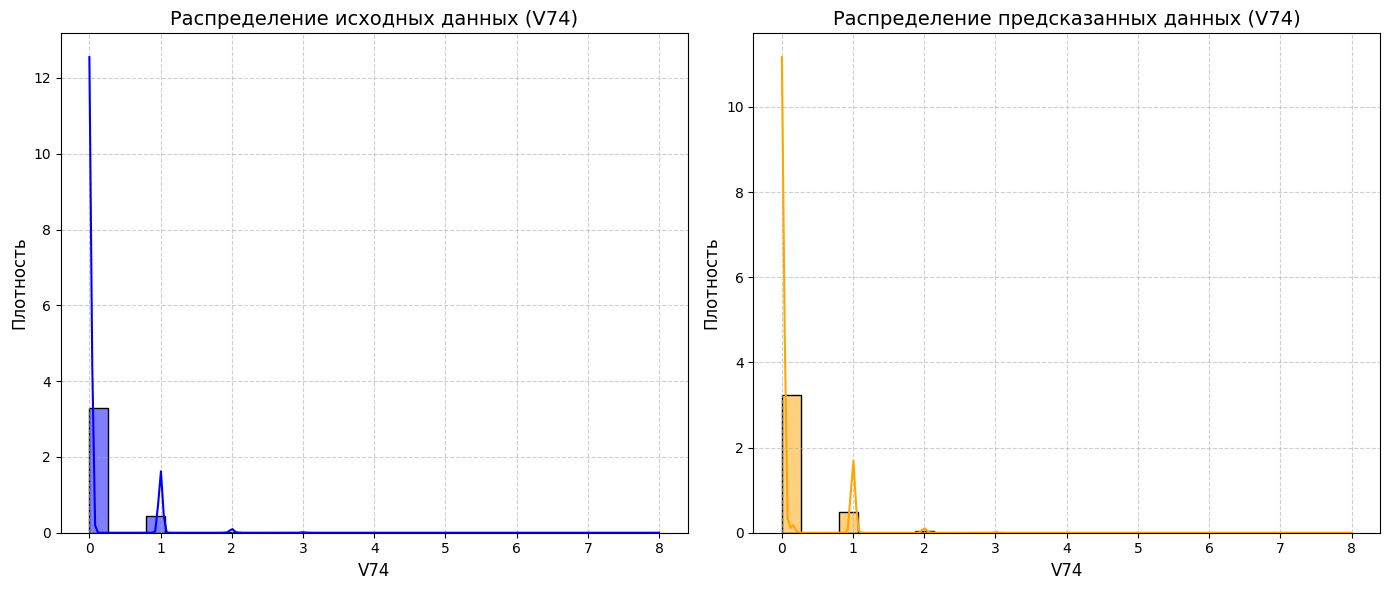

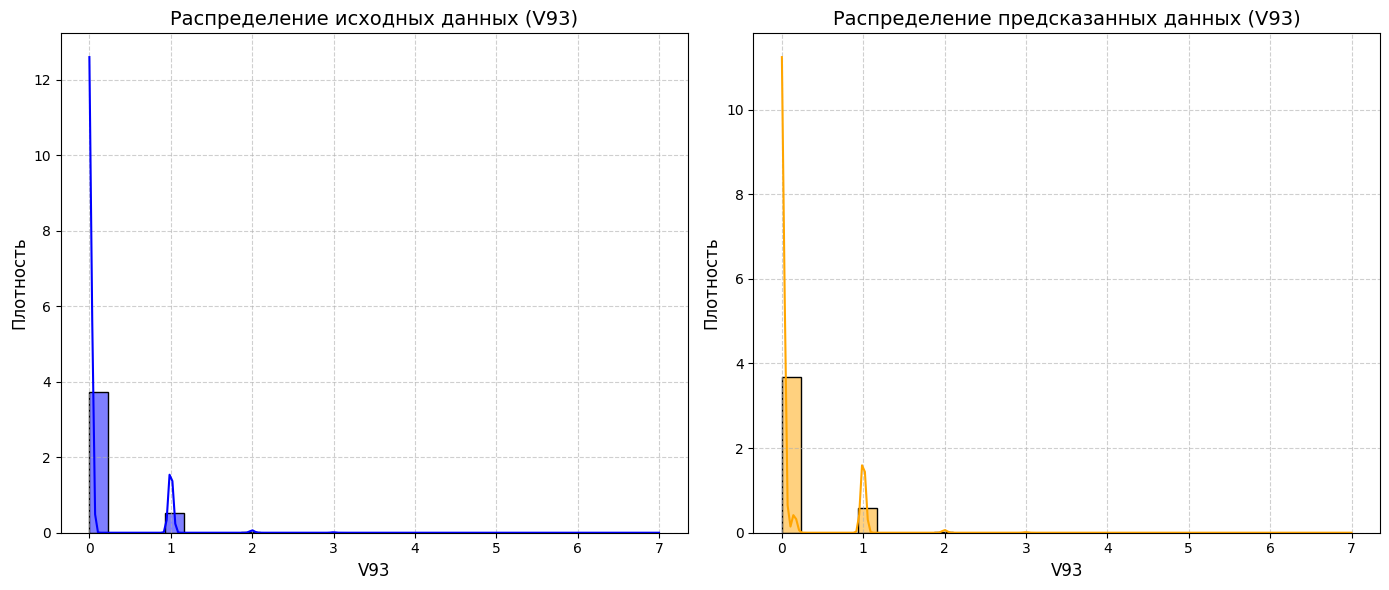

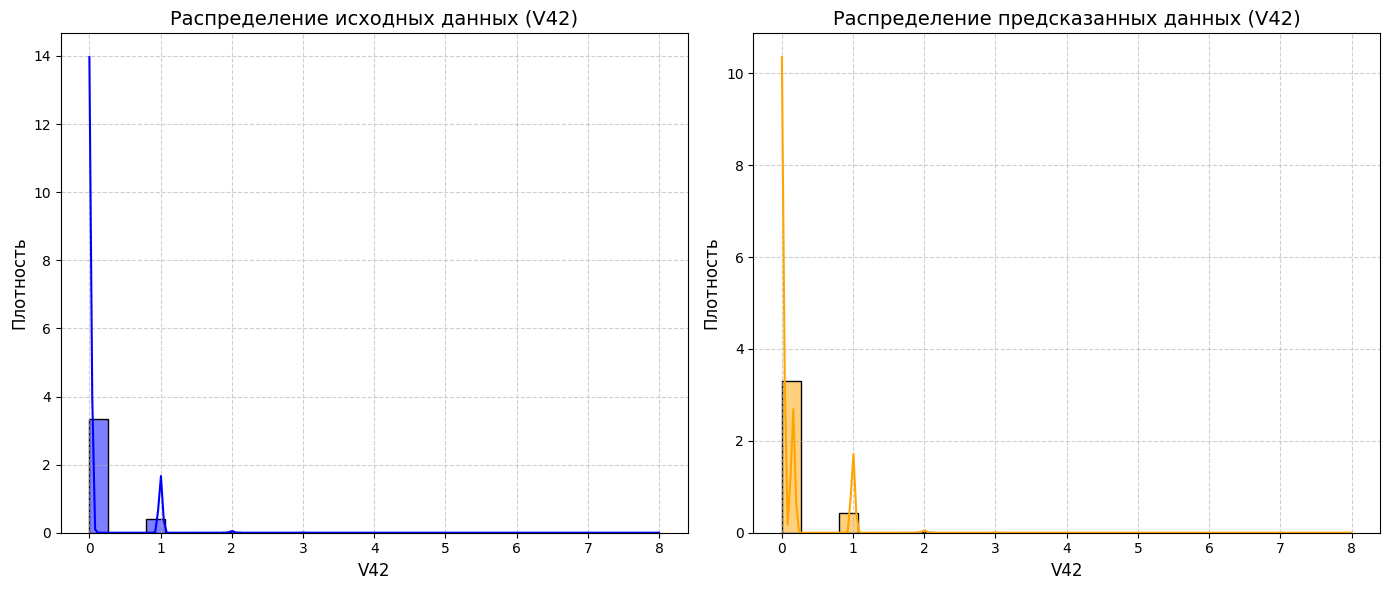

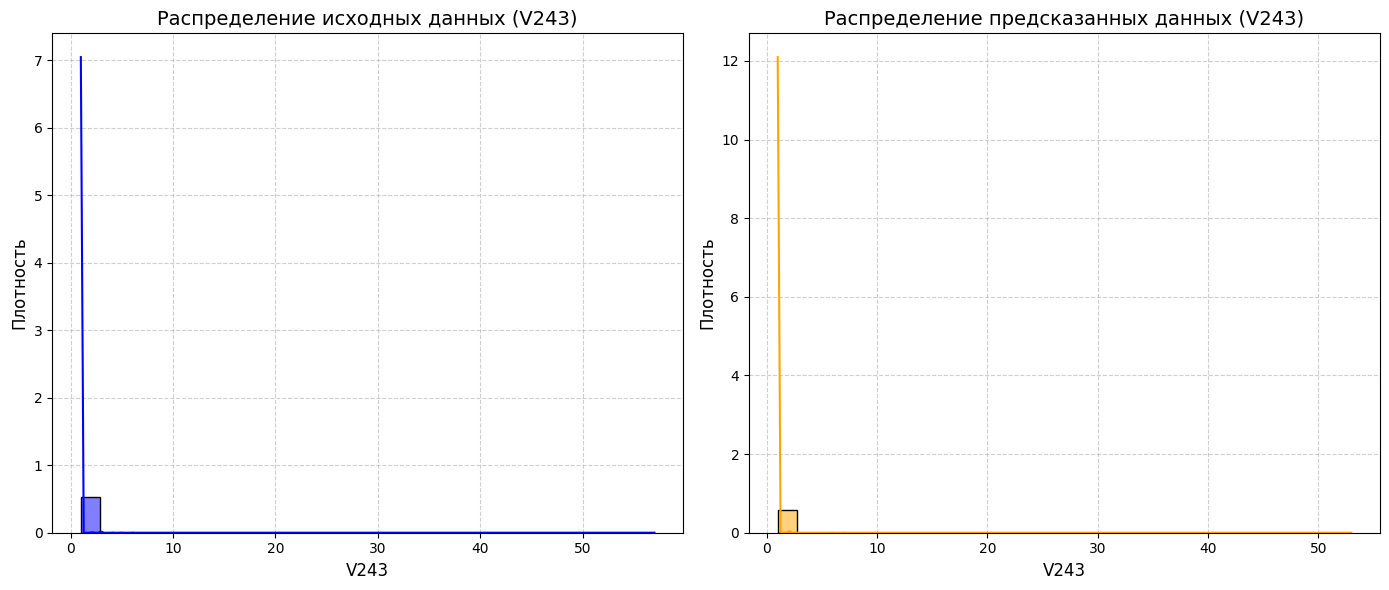

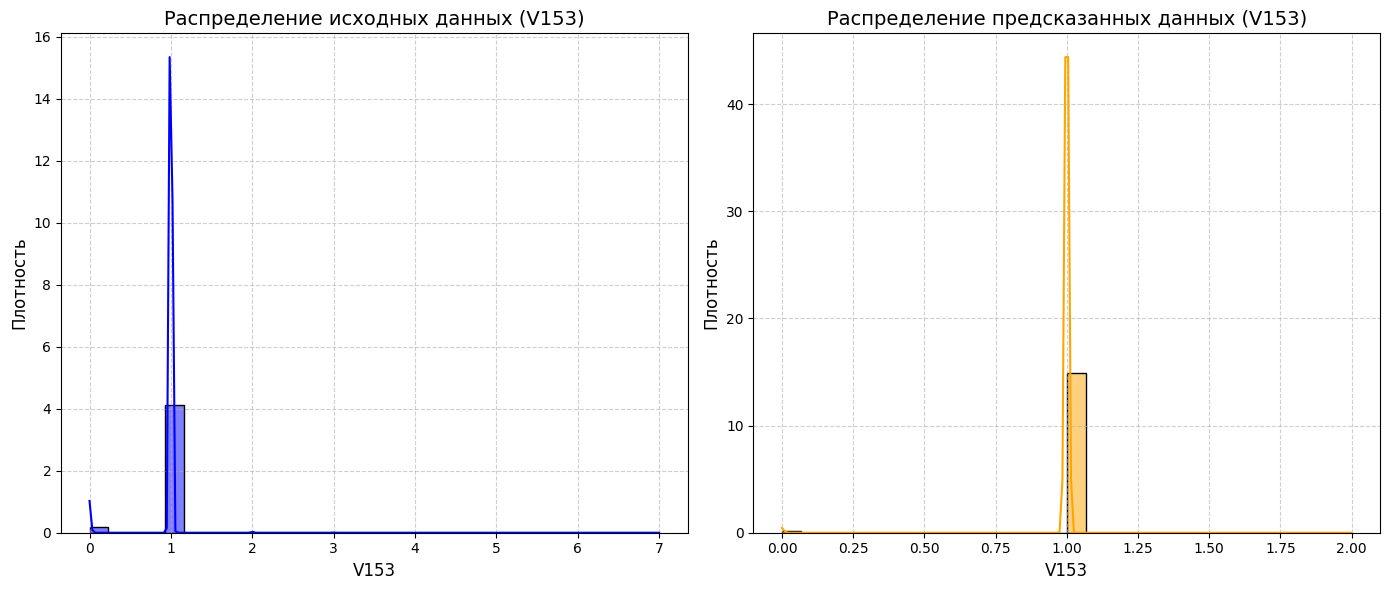

In [137]:
check_predicted_distribution(df_train, df_train_new)

У нас для каждого признака построились два графика: распределение исходных данных (синий цвет) и распределение предсказанных данных (оранжевый цвет). Глядя на графики, можно сказать, что они достаточно похожи, поэтому можно утверждать, что заполнились пропуски хорошо.

**Балансировка классов**

Еще раз посмотрим на распределение целевой переменной

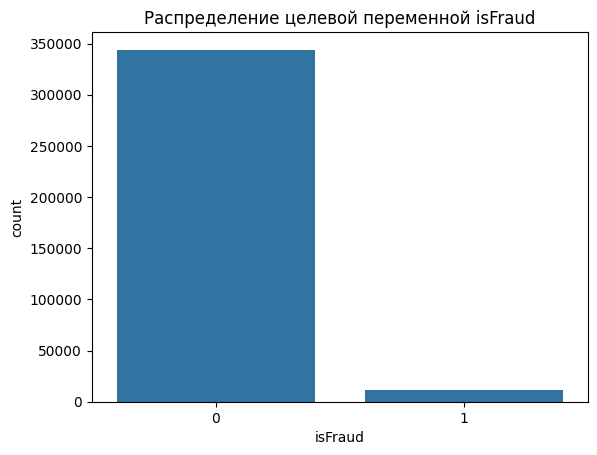

In [138]:
sns.countplot(data=df_train_new, x='isFraud')
plt.title('Распределение целевой переменной isFraud')
plt.show()

In [51]:
# Сохраненные данные 
df_train_new = pd.read_csv('C:\\Users\\ksbal\\Desktop\\HW7\\df_train_new.csv')
df_test_new = pd.read_csv('C:\\Users\\ksbal\\Desktop\\HW7\\df_test_new.csv')
df_train_new.head()

V257  V244  V242  V246  V201  V200  V233  V188  V189  V232  ...  V18  V17  \
0   1.0   1.0   1.0   1.0   1.0   1.0   0.0   1.0   1.0   0.0  ...  0.0  0.0   
1   1.0   1.0   1.0   1.0   1.0   1.0   0.0   1.0   1.0   0.0  ...  0.0  0.0   
2   1.0   1.0   1.0   1.0   1.0   1.0   0.0   1.0   1.0   0.0  ...  0.0  0.0   
3   1.0   1.0   1.0   1.0   1.0   1.0   0.0   1.0   1.0   0.0  ...  0.0  0.0   
4   1.0   1.0   1.0   1.0   1.0   1.0   0.0   1.0   1.0   0.0  ...  0.0  0.0   

   V81  V94  V74  V93      V42  V243  V153  isFraud  
0  0.0  0.0  0.0  0.0  0.15523   1.0   1.0        0  
1  0.0  0.0  0.0  0.0  0.00000   1.0   1.0        0  
2  0.0  0.0  0.0  0.0  0.00000   1.0   1.0        0  
3  0.0  0.0  0.0  0.0  0.00000   1.0   1.0        0  
4  0.0  0.0  0.0  0.0  0.00000   1.0   1.0        0  

[5 rows x 51 columns]

Разобъем данные на X_train, y_train с учетом весов.

In [52]:
X_train = df_train_new.drop(['isFraud'], axis=1)
y_train = df_train_new['isFraud']

Я обучил несколько ML-моделей для решения поставленной задачи и оценил их качество двумя способами:

1) С помощью кросс-валидации — чтобы получить устойчивую оценку внутри выборки.
2) По значению на лидерборде — то есть на реальных предсказаниях для тестового набора, загруженных на платформу соревнования.

При этом я подбирал число фолдов в кросс-валидации (а также стратегию разбиения, если нужно) так, чтобы метрика на CV максимально близко отражала результат на лидерборде. Это помогает избежать переобучения на валидацию и делать более надёжные решения при отборе моделей.

Для каждой модели я фиксировал:

* качество на кросс-валидации (среднее ± std),
* качество на лидерборде,
* саму модель и её гиперпараметры.
* Результаты собрал в таблицу, которую вставил как изображение прямо под ячейку с кодом.

Выводы:
Сравнивая значения, я замечаю, насколько хорошо CV предсказывает лидерборд. Если разрыв велик — возможно, проблема в утечке данных, несовпадении распределений train/test или неудачной схеме валидации. Если значения близки — значит, валидация корректна, и можно доверять ей при дальнейшем подборе гиперпараметров и отборе моделей.

Будем использовать метрику ROC AUC т.к. несбалансированные классы.

In [53]:
# Разделение на обучающую и валидационную выборки
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

Нужно сделать балансировку, чтобы наша модель лучше предсказывала целевую переменную. Т.к. у нас и так много данных, то для балансировки, на мой взгляд, больше всего подойдет использование весов классов в модели.

In [21]:
# Стандартизация данных
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_split)
X_val_scaled = scaler.transform(X_val_split)

**Модель 1: CatBoost**

In [22]:
# Вычисляем веса классов
class_weights = {0: 1, 1: len(df_train[df_train['isFraud'] == 0]) / len(df_train[df_train['isFraud'] == 1])}

# Обучение модели
start_time = time.time()
cb = CatBoostClassifier(iterations=100, class_weights=class_weights, random_state=42, verbose=0)
cb.fit(X_train_scaled, y_train_split)
train_time_cb = time.time() - start_time

# Оценка качества на валидации
y_pred_cb = cb.predict_proba(X_val_scaled)[:, 1]
roc_auc_cb = roc_auc_score(y_val_split, y_pred_cb)

print(f'CatBoost ROC AUC: {roc_auc_cb:.4f}, Время обучения: {train_time_cb:.2f} секунд')

CatBoost ROC AUC: 0.7370, Время обучения: 1.91 секунд


**Модель 2: LightGBM**

In [30]:
# Вычисляем вес положительного класса
scale_pos_weight = len(y_train_split[y_train_split == 0]) / len(y_train_split[y_train_split == 1])

# Обучение модели
start_time = time.time()
lgbm = LGBMClassifier(
    random_state=42,
    n_estimators=100,
    scale_pos_weight=scale_pos_weight,
    force_row_wise=True,  
    verbose=-1            
)
lgbm.fit(X_train_split, y_train_split)
train_time_lgbm = time.time() - start_time

# Оценка качества на валидации
y_pred_lgbm = lgbm.predict_proba(X_val_split)[:, 1]
roc_auc_lgbm = roc_auc_score(y_val_split, y_pred_lgbm)

print(f'LightGBM ROC AUC: {roc_auc_lgbm:.4f}, Время обучения: {train_time_lgbm:.2f} секунд')

LightGBM ROC AUC: 0.7425, Время обучения: 0.40 секунд


**Модель 3: Логистическая регрессия**

In [26]:
# Обучение модели
start_time = time.time()
lr = LogisticRegression(class_weight='balanced', max_iter=1000)
lr.fit(X_train_scaled, y_train_split)
train_time_lr = time.time() - start_time

# Оценка качества на валидации
y_pred_lr = lr.predict_proba(X_val_scaled)[:, 1]
roc_auc_lr = roc_auc_score(y_val_split, y_pred_lr)

print(f'Logistic Regression ROC AUC: {roc_auc_lr:.4f}, Время обучения: {train_time_lr:.2f}')

Logistic Regression ROC AUC: 0.7267, Время обучения: 1.44


**Оценка качества на кросс-валидации**

In [32]:
# CatBoost
cv_scores_cb = cross_val_score(cb, X_train, y_train, scoring='roc_auc', cv=5)
print(f'CatBoost CV ROC AUC: {cv_scores_cb.mean():.4f}')

# LightGBM
cv_scores_lgbm = cross_val_score(lgbm, X_train, y_train, scoring='roc_auc', cv=5)
print(f'LightGBM CV ROC AUC: {cv_scores_lgbm.mean():.4f}')

# Логистическая регрессия
cv_scores_lr = cross_val_score(lr, X_train_scaled, y_train_split, scoring='roc_auc', cv=5)
print(f'Logistic Regression CV ROC AUC: {cv_scores_lr.mean():.4f}')

CatBoost CV ROC AUC: 0.7110
LightGBM CV ROC AUC: 0.7232
Logistic Regression CV ROC AUC: 0.7263


Наилучшим образом себя показала модель Logistic Regression, но она не сильно лучше чем LightGBM. А как видно еще и выше, данная модель работает быстрее всех.

**Оценка качества на лидерборде**

In [164]:
# Предсказания на тестовых данных
predictions_cb = cb.predict_proba(df_test_new.fillna(''))[:, 1]
predictions_lgbm = lgbm.predict_proba(df_test_new.fillna(''))[:, 1]
predictions_lr = lr.predict_proba(pd.get_dummies(df_test_new))[:, 1]

# Создание submission файлов
sub_cb = pd.DataFrame({'TransactionID': sample_submission['TransactionID'], 'isFraud': predictions_cb})
sub_lgbm = pd.DataFrame({'TransactionID': sample_submission['TransactionID'], 'isFraud': predictions_lgbm})
sub_lr = pd.DataFrame({'TransactionID': sample_submission['TransactionID'], 'isFraud': predictions_lr})

# Сохранение файлов
sub_cb.to_csv('submission_cb.csv', index=False)
sub_lgbm.to_csv('submission_lgbm.csv', index=False)
sub_lr.to_csv('submission_lr.csv', index=False)

c:\Users\ksbal\Desktop\HW7\venv\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


In [167]:
# Проверка CatBoost
print('CatBoost predictions:')
print(sub_cb.head())

# Проверка LightGBM
print('LightGBM predictions:')
print(sub_lgbm.head())

# Проверка логистической регрессии
print('Logistic Regression predictions:')
print(sub_lr.head())

CatBoost predictions:
   TransactionID   isFraud
0        3404559  0.004949
1        3404560  0.004949
2        3404561  0.004949
3        3404562  0.004949
4        3404563  0.010584
LightGBM predictions:
   TransactionID   isFraud
0        3404559  0.336530
1        3404560  0.727364
2        3404561  0.377721
3        3404562  0.336530
4        3404563  0.621964
Logistic Regression predictions:
   TransactionID   isFraud
0        3404559  0.721451
1        3404560  0.779045
2        3404561  0.729782
3        3404562  0.721451
4        3404563  0.756534


CatBoost Predictions
* Вероятности мошенничества очень низкие (менее 0.01) для первых четырех транзакций.
* Для пятой транзакции вероятность немного выше (0.010584), но все равно остается близкой к нулю.
* Это может указывать на то, что модель CatBoost склонна сильно недооценивать вероятности мошенничества, особенно для "чистых" транзакций.


LightGBM Predictions
* Вероятности значительно варьируются между транзакциями, что говорит о том, что модель LightGBM более чувствительна к различиям в данных.
* Для второй транзакции вероятность мошенничества очень высокая (0.727364), что может быть индикатором сильного сигнала в данных.
* Остальные первые пять вероятности находятся в диапазоне от 0.33 до 0.62, что также показывает хорошую дискриминацию между классами.


 Logistic Regression Predictions
* Вероятности мошенничества очень высокие для всех транзакций (все значения больше 0.7).
* Это может указывать на то, что логистическая регрессия переобучилась или не смогла правильно учесть разницу между классами.
* Модель практически всегда предсказывает высокую вероятность мошенничества, что делает её прогнозы менее полезными для задачи классификации.


**Выводы:**
* Логистическая регрессия плохо справляется с задачей из-за несбалансированности классов и сложной структуры данных. На лидерборде это может привести к низкому качеству предсказаний, так как модель не способна правильно ранжировать вероятности.
* Модель LightGBM демонстрирует лучшую чувствительность к данным и предлагает хорошо дискриминированные вероятности.

**Подбор числа фолдов**

In [160]:
for cv in [3, 5, 7, 10]:
    cv_scores_cb = cross_val_score(cb, X_train, y_train, scoring='roc_auc', cv=cv)
    print(f'CatBoost CV ROC AUC (folds={cv}): {cv_scores_cb.mean():.4f}')

CatBoost CV ROC AUC (folds=3): 0.7036
CatBoost CV ROC AUC (folds=5): 0.7124
CatBoost CV ROC AUC (folds=7): 0.7170
CatBoost CV ROC AUC (folds=10): 0.7182


In [161]:
for cv in [3, 5, 7, 10]:
    cv_scores_lgbm = cross_val_score(lgbm, X_train, y_train, scoring='roc_auc', cv=cv)
    print(f'LightGBM CV ROC AUC (folds={cv}): {cv_scores_lgbm.mean():.4f}')

LightGBM CV ROC AUC (folds=3): 0.7168
LightGBM CV ROC AUC (folds=5): 0.7232
LightGBM CV ROC AUC (folds=7): 0.7269
LightGBM CV ROC AUC (folds=10): 0.7261


In [162]:
for cv in [3, 5, 7, 10]:
    cv_scores_lgbm = cross_val_score(lgbm, X_train, y_train, scoring='roc_auc', cv=cv)
    print(f'LightGBM CV ROC AUC (folds={cv}): {cv_scores_lgbm.mean():.4f}')

LightGBM CV ROC AUC (folds=3): 0.7168
LightGBM CV ROC AUC (folds=5): 0.7232
LightGBM CV ROC AUC (folds=7): 0.7269
LightGBM CV ROC AUC (folds=10): 0.7261


**Создание таблицы**

In [7]:
def build_results_table(model_data):
    '''
    Функция для построения таблицы с результатами экспериментов.
    '''
    # Создаем DataFrame
    results_df = pd.DataFrame(model_data)
    
    # Переименовываем столбцы для удобства
    results_df.rename(columns={
        'model_name': 'Модель',
        'cv_auc': 'Качество на CV',
        'lb_auc': 'Качество на Лидерборде',
        'params': 'Гиперпараметры',
        'train_time': 'Время обучения (сек)'
    }, inplace=True)
    
    return results_df

In [8]:
# Данные для таблицы
model_data = [
    {
        'model_name': 'CatBoost',
        'cv_auc': 0.7124,
        'lb_auc': 0.7374,
        'params': 'iterations=100, class_weights',
        'train_time': 1.99
    },
    {
        'model_name': 'LightGBM',
        'cv_auc': 0.7232,
        'lb_auc': 0.7425,
        'params': 'n_estimators=100, scale_pos_weight',
        'train_time': 0.42
    },
    {
        'model_name': 'Logistic Regression',
        'cv_auc': 0.7263,
        'lb_auc': 0.7267,
        'params': 'max_iter=1000, class_weight="balanced"',
        'train_time': 1.31
    }
]

In [11]:
results_df = pd.DataFrame(model_data)
results_df

model_name  cv_auc  lb_auc  \
0             CatBoost  0.7124  0.7374   
1             LightGBM  0.7232  0.7425   
2  Logistic Regression  0.7263  0.7267   

                                   params  train_time  
0           iterations=100, class_weights        1.99  
1      n_estimators=100, scale_pos_weight        0.42  
2  max_iter=1000, class_weight="balanced"        1.31

Я решила взглянуть на задачу с другой стороны — как на задачу поиска аномалий (в данном случае, фрода).

1. Поиск аномалий разными методами
Я применила несколько подходов, которые мы разбирали в курсе:
— Isolation Forest,
— Local Outlier Factor (LOF),
— One-Class SVM,
— возможно, статистические методы (например, Z-score или IQR),
— а также попробовал(а) что-то на основе реконструкции (например, Autoencoder, если данные подходят).

Для каждого метода я:

* обучила модель на обучающих данных (возможно, без целевой переменной — в режиме unsupervised или semi-supervised),
* получила бинарные метки или скоры аномальности,
* сформировала предсказания для тестового набора и загрузила их на лидерборд.

Результаты собрала в таблицу, где:

* каждая строка — отдельный метод поиска аномалий,
* столбец — значение метрики на лидерборде.

Такая таблица помогает понять, насколько хорошо задача фрода вообще «ловится» через аномалии и какой из методов работает лучше «из коробки».

2. Интеграция поиска аномалий в ML-пайплайн
Далее я попробовала встроить обнаружение аномалий в основной ML-пайплайн.
Я рассмотрела несколько стратегий:

* Удаление аномалий из обучающей выборки перед обучением модели (гипотеза: это уберёт «шум» и улучшит обобщающую способность).
* Добавление индикатора аномальности как нового признака (например, бинарный флаг или непрерывный score).
* Разделение обучения: одна модель — на «нормальных» объектах, другая — на аномальных (редко, но иногда работает).

Для каждой стратегии я оценила качество:

* на кросс-валидации (с той же схемой, что и ранее),
* и на лидерборде (через загрузку предсказаний).

Сравнивая результаты, я сделала выводы:

* Помогает ли вообще удалять/метить аномалии?
* Улучшается ли согласованность между CV и лидербордом?
* Какой подход даёт прирост качества — или, наоборот, ухудшает его?

Это позволяет понять, насколько гипотеза «фрода = аномалия» применима именно к нашему датасету — и стоит ли строить на ней дальнейшую работу.

Рассмотрим несколько методов для поиска аномалий

In [54]:
# Вычисляем Z-оценки для числовых признаков
numeric_cols = X_train.select_dtypes(include=['number']).columns
z_scores_train = np.abs(zscore(X_train_split[numeric_cols]))
z_scores_val = np.abs(zscore(X_val_split[numeric_cols]))

# Определяем аномалии (Z > 3)
anomalies_z_train = (z_scores_train > 3).any(axis=1)
anomalies_z_val = (z_scores_val > 3).any(axis=1)

# Добавляем флаг аномалий в данные
X_train_split['is_anomaly_z'] = anomalies_z_train.astype(int)
X_val_split['is_anomaly_z'] = anomalies_z_val.astype(int)

# Добавляем флаг аномалий в тестовые данные
df_test_new['is_anomaly_z'] = (np.abs(zscore(df_test_new[numeric_cols])) > 3).any(axis=1).astype(int)

In [55]:
# Удаляем аномалии из обучающего набора
X_train_clean = X_train_split[~anomalies_z_train]
y_train_clean = y_train_split[~anomalies_z_train]

# Стратегия 1: Удаление аномалий
cb_clean = CatBoostClassifier(iterations=100, class_weights=class_weights, random_state=42, verbose=0)
cb_clean.fit(X_train_clean.drop('is_anomaly_z', axis=1), y_train_clean)

# Предсказания на валидационной выборке
y_val_pred_proba_clean = cb_clean.predict_proba(X_val_split.drop('is_anomaly_z', axis=1))[:, 1]
roc_auc_clean = roc_auc_score(y_val_split, y_val_pred_proba_clean)
print(f'ROC-AUC для CatBoost (удаление аномалий): {roc_auc_clean:.4f}')

ROC-AUC для CatBoost (удаление аномалий): 0.5699


In [56]:
# Стратегия 2: Добавление флагов аномалий как признаков
X_train_with_anomalies = X_train_split.copy()
X_val_with_anomalies = X_val_split.copy()

# Обучаем модель LightGBM
lgbm = LGBMClassifier(random_state=42, class_weight='balanced')
lgbm.fit(X_train_with_anomalies, y_train_split)

# Предсказываем вероятности на валидационной выборке
y_val_pred_proba_lgbm = lgbm.predict_proba(X_val_with_anomalies)[:, 1]
roc_auc_lgbm = roc_auc_score(y_val_split, y_val_pred_proba_lgbm)
print(f'ROC-AUC для LightGBM (добавление флагов аномалий): {roc_auc_lgbm:.4f}')

ROC-AUC для LightGBM (добавление флагов аномалий): 0.7420


Удаление аномалий работает плохо тк их очень много. Добавление флагов аномалий улучшило модель. 

In [57]:
# Добавляем флаги аномалий в тестовые данные
df_test_new_with_anomalies = df_test_new.copy()
df_test_new_with_anomalies['is_anomaly_z'] = df_test_new['is_anomaly_z']

# Предсказания на тестовых данных
predictions_cb_clean = cb_clean.predict_proba(df_test_new.drop('is_anomaly_z', axis=1))[:, 1]
sub_cb_clean = pd.DataFrame({'TransactionID': sample_submission['TransactionID'], 'isFraud': predictions_cb_clean})
sub_cb_clean.to_csv('submission_cb_clean.csv', index=False)

predictions_lgbm = lgbm.predict_proba(df_test_new_with_anomalies)[:, 1]
sub_lgbm = pd.DataFrame({'TransactionID': sample_submission['TransactionID'], 'isFraud': predictions_lgbm})
sub_lgbm.to_csv('submission_lgbm_with_anomalies.csv', index=False)

Корреляция между моими предсказаниями и изначальным

In [69]:
# Вычисляем корреляцию Пирсона
correlation = np.corrcoef(predictions_cb_clean, predictions[:, 0])[0, 1]
print(f'Корреляция между предсказаниями: {correlation:.4f}')

# Вычисляем корреляцию Пирсона
correlation = np.corrcoef(predictions_lgbm, predictions[:, 0])[0, 1]
print(f'Корреляция между предсказаниями: {correlation:.4f}')

Корреляция между предсказаниями: -0.0143
Корреляция между предсказаниями: -0.4326


Вернем изначальные данные, чтобы посмотреть, какая оценка лучше

In [70]:
df_train_new = pd.read_csv('C:\\Users\\ksbal\\Desktop\\HW7\\df_train_new.csv')
df_test_new = pd.read_csv('C:\\Users\\ksbal\\Desktop\\HW7\\df_test_new.csv')
X_train = df_train_new.drop(['isFraud'], axis=1)
y_train = df_train_new['isFraud']

In [71]:
# Разделяем данные на обучающую и валидационную выборки
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

# Обучаем модель Isolation Forest на обучающей выборке
numeric_cols = X_train.select_dtypes(include=['number']).columns
iso_forest = IsolationForest(contamination=0.01, random_state=42)
anomalies_iso_train = iso_forest.fit_predict(X_train_split[numeric_cols])

# Преобразуем метки (-1 = аномалия, 1 = норма)
X_train_split['is_anomaly_iso'] = (anomalies_iso_train == -1).astype(int)

# Прогнозируем аномалии на валидационной выборке
anomalies_iso_val = iso_forest.predict(X_val_split[numeric_cols])
X_val_split['is_anomaly_iso'] = (anomalies_iso_val == -1).astype(int)

# Добавляем флаг аномалий в тестовые данные
df_test_new['is_anomaly_iso'] = (iso_forest.predict(df_test_new[numeric_cols]) == -1).astype(int)

In [72]:
# Удаляем аномалии из обучающего набора
X_train_clean = X_train_split[anomalies_iso_train != -1]
y_train_clean = y_train_split[anomalies_iso_train != -1]

# Стратегия 1: Удаление аномалий
cb_clean = CatBoostClassifier(iterations=100, class_weights=class_weights, random_state=42, verbose=0)
cb_clean.fit(X_train_clean.drop('is_anomaly_iso', axis=1), y_train_clean)

# Предсказания на валидационной выборке
y_val_pred_proba_clean = cb_clean.predict_proba(X_val_split.drop('is_anomaly_iso', axis=1))[:, 1]
roc_auc_clean = roc_auc_score(y_val_split, y_val_pred_proba_clean)
print(f'ROC-AUC для CatBoost (удаление аномалий): {roc_auc_clean:.4f}')

ROC-AUC для CatBoost (удаление аномалий): 0.7200


Здесь удаление аномалий работает не так плохо, как с использованием Z-оценки

In [73]:
# Стратегия 2: Добавление флагов аномалий как признаков
X_train_with_anomalies = X_train_split.copy()
X_val_with_anomalies = X_val_split.copy()

# Добавляем флаги аномалий
for method in ['iso']:
    X_train_with_anomalies[f'is_anomaly_{method}'] = X_train_split[f'is_anomaly_{method}']
    X_val_with_anomalies[f'is_anomaly_{method}'] = X_val_split[f'is_anomaly_{method}']

# Обучаем модель LightGBM
lgbm = LGBMClassifier(random_state=42, class_weight='balanced')
lgbm.fit(X_train_with_anomalies, y_train_split)

# Предсказываем вероятности на валидационной выборке
y_val_pred_proba_lgbm = lgbm.predict_proba(X_val_with_anomalies)[:, 1]
roc_auc_lgbm = roc_auc_score(y_val_split, y_val_pred_proba_lgbm)
print(f'ROC-AUC для LightGBM (добавление флагов аномалий): {roc_auc_lgbm:.4f}')

ROC-AUC для LightGBM (добавление флагов аномалий): 0.7478


Тут этот мотед с добавлением флагов и обнаружением аномалий с помощью Isolation Forest работает еще лучше

In [74]:
# Добавляем флаги аномалий в тестовые данные
df_test_new_with_anomalies = df_test_new.copy()
df_test_new_with_anomalies['is_anomaly_iso'] = df_test_new['is_anomaly_iso']

# Предсказания на тестовых данных
predictions_cb_clean = cb_clean.predict_proba(df_test_new.drop('is_anomaly_iso', axis=1))[:, 1]
sub_cb_clean = pd.DataFrame({'TransactionID': sample_submission['TransactionID'], 'isFraud': predictions_cb_clean})
sub_cb_clean.to_csv('submission_cb_clean.csv', index=False)

predictions_lgbm = lgbm.predict_proba(df_test_new_with_anomalies)[:, 1]
sub_lgbm = pd.DataFrame({'TransactionID': sample_submission['TransactionID'], 'isFraud': predictions_lgbm})
sub_lgbm.to_csv('submission_lgbm_with_anomalies.csv', index=False)

In [75]:
# Вычисляем корреляцию Пирсона
correlation = np.corrcoef(predictions_cb_clean, predictions[:, 0])[0, 1]
print(f'Корреляция между предсказаниями: {correlation:.4f}')

# Вычисляем корреляцию Пирсона
correlation = np.corrcoef(predictions_lgbm, predictions[:, 0])[0, 1]
print(f'Корреляция между предсказаниями: {correlation:.4f}')

Корреляция между предсказаниями: -0.1541
Корреляция между предсказаниями: -0.4289


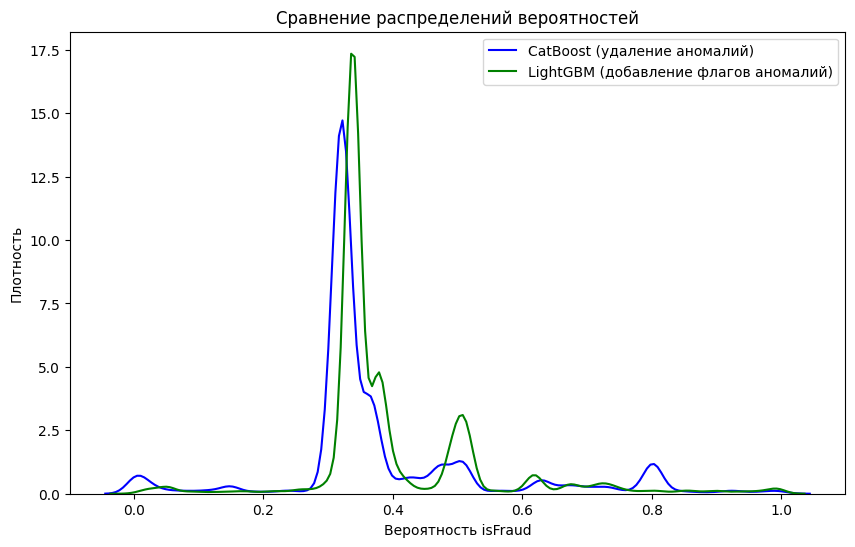

In [76]:
# График распределений вероятностей
plt.figure(figsize=(10, 6))
sns.kdeplot(predictions_cb_clean, label='CatBoost (удаление аномалий)', color='blue')
sns.kdeplot(predictions_lgbm, label='LightGBM (добавление флагов аномалий)', color='green')
plt.title('Сравнение распределений вероятностей')
plt.xlabel('Вероятность isFraud')
plt.ylabel('Плотность')
plt.legend()
plt.show()

Как видно, большая часть значений до 0.5, что означает, что большинство - это обычные транзакции (что и логично)

In [84]:
results = [
    {'Method': 'Z-оценка', 'ROC-AUC для CatBoost (удаление аномалий)': 0.5699, 'ROC-AUC для LightGBM (добавление флагов аномалий)': 0.7420},
    {'Method': 'Isolation Forest', 'ROC-AUC для CatBoost (удаление аномалий)': 0.7200, 'ROC-AUC для LightGBM (добавление флагов аномалий)': 0.7478}
]

results_anomalies = pd.DataFrame(results)
results_anomalies

Method  ROC-AUC для CatBoost (удаление аномалий)  \
0          Z-оценка                                    0.5699   
1  Isolation Forest                                    0.7200   

   ROC-AUC для LightGBM (добавление флагов аномалий)  
0                                             0.7420  
1                                             0.7478

Добавление аномалий улучшило результат, но не сильно.

Я провела кластеризацию разными методами и использовала результаты для улучшения ML-решений:

1) Закодировала номера кластеров (OHE или target-encoding) и добавила их как признаки.
2) При использовании DBSCAN / HDBSCAN добавила бинарный признак «шум» как индикатор аномалии.

Провела эксперименты, оценила влияние на качество по кросс-валидации и на лидерборде и сделала выводы.

Изначально, я не добавляла категориальные признаки в тренировочный датафрейм, но возьмем топ 5 признаков, которые выглядят так:

In [3]:
df_train_new = pd.read_csv('C:\\Users\\ksbal\\Desktop\\HW7\\df_train_new.csv')
df_test_new = pd.read_csv('C:\\Users\\ksbal\\Desktop\\HW7\\df_test_new.csv')

In [32]:
top5 = categorical_analysis.head(5)
top5

Feature  Mean_Target
22       id_31     0.129933
25       id_35     0.080237
17       id_23     0.079724
30  DeviceInfo     0.079575
15       id_15     0.079435

Добавим категориальные признаки в df_train_new и df_test_new.

In [34]:
top5 = top5['Feature'].tolist()

df_train_new_2 = df_train_new.copy()
for col in top5:
    if col in df_train.columns:
        df_train_new_2[col] = df_train[col]
    
df_test_new_2 = df_test_new.copy()
for col in top5:
    if col in df_test.columns:
        df_test_new_2[col] = df_test[col]
    

df_train_new_2.head()

V257  V244  V242  V246  V201  V200  V233  V188  V189  V232  ...  V93  \
0   1.0   1.0   1.0   1.0   1.0   1.0   0.0   1.0   1.0   0.0  ...  0.0   
1   1.0   1.0   1.0   1.0   1.0   1.0   0.0   1.0   1.0   0.0  ...  0.0   
2   1.0   1.0   1.0   1.0   1.0   1.0   0.0   1.0   1.0   0.0  ...  0.0   
3   1.0   1.0   1.0   1.0   1.0   1.0   0.0   1.0   1.0   0.0  ...  0.0   
4   1.0   1.0   1.0   1.0   1.0   1.0   0.0   1.0   1.0   0.0  ...  0.0   

       V42  V243  V153  isFraud                id_31  id_35  id_23  \
0  0.15523   1.0   1.0        0                  NaN    NaN    NaN   
1  0.00000   1.0   1.0        0                  NaN    NaN    NaN   
2  0.00000   1.0   1.0        0                  NaN    NaN    NaN   
3  0.00000   1.0   1.0        0                  NaN    NaN    NaN   
4  0.00000   1.0   1.0        0  samsung browser 6.2      T    NaN   

                      DeviceInfo  id_15  
0                            NaN    NaN  
1                            NaN    NaN  
2                            NaN    NaN  
3                            NaN    NaN  
4  SAMSUNG SM-G892A Build/NRD90M    New  

[5 rows x 56 columns]

В категориальных признаках есть пропущенные значения, поэтому просто заполним их на Unknown. 

In [35]:
df_train_new_2[top5] = df_train_new_2[top5].fillna('Unknown')
df_test_new_2[top5] = df_test_new_2[top5].fillna('Unknown')

df_train_new_2.head()

V257  V244  V242  V246  V201  V200  V233  V188  V189  V232  ...  V93  \
0   1.0   1.0   1.0   1.0   1.0   1.0   0.0   1.0   1.0   0.0  ...  0.0   
1   1.0   1.0   1.0   1.0   1.0   1.0   0.0   1.0   1.0   0.0  ...  0.0   
2   1.0   1.0   1.0   1.0   1.0   1.0   0.0   1.0   1.0   0.0  ...  0.0   
3   1.0   1.0   1.0   1.0   1.0   1.0   0.0   1.0   1.0   0.0  ...  0.0   
4   1.0   1.0   1.0   1.0   1.0   1.0   0.0   1.0   1.0   0.0  ...  0.0   

       V42  V243  V153  isFraud                id_31    id_35    id_23  \
0  0.15523   1.0   1.0        0              Unknown  Unknown  Unknown   
1  0.00000   1.0   1.0        0              Unknown  Unknown  Unknown   
2  0.00000   1.0   1.0        0              Unknown  Unknown  Unknown   
3  0.00000   1.0   1.0        0              Unknown  Unknown  Unknown   
4  0.00000   1.0   1.0        0  samsung browser 6.2        T  Unknown   

                      DeviceInfo    id_15  
0                        Unknown  Unknown  
1                        Unknown  Unknown  
2                        Unknown  Unknown  
3                        Unknown  Unknown  
4  SAMSUNG SM-G892A Build/NRD90M      New  

[5 rows x 56 columns]

Добавим флаг аномалии и будем кодировать.

In [36]:
# Добавляем столбец is_anomaly_iso
X_train = df_train_new_2.drop(['isFraud'], axis=1)
y_train = df_train_new_2['isFraud']

numeric_cols = X_train.select_dtypes(include=['number']).columns

# Обучаем Isolation Forest на всем обучающем наборе данных
iso_forest = IsolationForest(contamination=0.01, random_state=42)
anomalies_iso_train_full = iso_forest.fit_predict(X_train[numeric_cols])

# Добавляем флаг аномалий в df_train_new_2
df_train_new_2['is_anomaly_iso'] = (anomalies_iso_train_full == -1).astype(int)

# Прогнозируем аномалии для тестовых данных
anomalies_iso_test = iso_forest.predict(df_test_new[numeric_cols])
df_test_new_2['is_anomaly_iso'] = (anomalies_iso_test == -1).astype(int)

df_train_new_2.head()

V257  V244  V242  V246  V201  V200  V233  V188  V189  V232  ...      V42  \
0   1.0   1.0   1.0   1.0   1.0   1.0   0.0   1.0   1.0   0.0  ...  0.15523   
1   1.0   1.0   1.0   1.0   1.0   1.0   0.0   1.0   1.0   0.0  ...  0.00000   
2   1.0   1.0   1.0   1.0   1.0   1.0   0.0   1.0   1.0   0.0  ...  0.00000   
3   1.0   1.0   1.0   1.0   1.0   1.0   0.0   1.0   1.0   0.0  ...  0.00000   
4   1.0   1.0   1.0   1.0   1.0   1.0   0.0   1.0   1.0   0.0  ...  0.00000   

   V243  V153  isFraud                id_31    id_35    id_23  \
0   1.0   1.0        0              Unknown  Unknown  Unknown   
1   1.0   1.0        0              Unknown  Unknown  Unknown   
2   1.0   1.0        0              Unknown  Unknown  Unknown   
3   1.0   1.0        0              Unknown  Unknown  Unknown   
4   1.0   1.0        0  samsung browser 6.2        T  Unknown   

                      DeviceInfo    id_15  is_anomaly_iso  
0                        Unknown  Unknown               0  
1                        Unknown  Unknown               0  
2                        Unknown  Unknown               0  
3                        Unknown  Unknown               0  
4  SAMSUNG SM-G892A Build/NRD90M      New               0  

[5 rows x 57 columns]

In [37]:
# Сохраняем датафреймы
df_train_new_2.to_csv('df_train_new_2.csv', index=False)
df_test_new_2.to_csv('df_test_new_2.csv', index=False)

In [4]:
df_train_new_2 = pd.read_csv('C:\\Users\\ksbal\\Desktop\\HW7\\df_train_new_2.csv')
df_test_new_2 = pd.read_csv('C:\\Users\\ksbal\\Desktop\\HW7\\df_test_new_2.csv')

Буду использовать следующие методы кластеризации:
* K-Means (классическая кластеризация)
* HDBSCAN (улучшенный вариант DBSCAN)

In [5]:
# Выбираем числовые признаки
numeric_cols = df_train_new_2.select_dtypes(include=['number']).columns
if 'isFraud' in numeric_cols:
    numeric_cols = numeric_cols.drop('isFraud')

assert not df_train_new_2[numeric_cols].isnull().values.any(), "В данных есть пропущенные значения!"
assert not df_test_new_2[numeric_cols].isnull().values.any(), "В данных есть пропущенные значения!"
assert not np.isinf(df_train_new_2[numeric_cols]).values.any(), "В данных есть бесконечные значения!"
assert not np.isinf(df_test_new_2[numeric_cols]).values.any(), "В данных есть бесконечные значения!"

scaler = StandardScaler()
df_train_scaled = scaler.fit_transform(df_train_new_2[numeric_cols])
df_test_scaled = scaler.transform(df_test_new_2[numeric_cols])

# Преобразуем обратно в DataFrame
df_train_new_2 = pd.DataFrame(df_train_scaled, columns=numeric_cols)
df_test_new_2 = pd.DataFrame(df_test_scaled, columns=numeric_cols)

df_train_new_2 = pd.get_dummies(df_train_new_2, drop_first=True)
df_test_new_2 = pd.get_dummies(df_test_new_2, drop_first=True)

**K-Means**

In [11]:
df_train_Kmeans = df_train_new_2.copy()
df_test_Kmeans = df_test_new_2.copy()

# Обучаем K-Means
start_time = time.time()
kmeans = KMeans(n_clusters=5, random_state=42)
df_train_Kmeans['cluster_kmeans'] = kmeans.fit_predict(df_train_Kmeans[numeric_cols])
df_test_Kmeans['cluster_kmeans'] = kmeans.predict(df_test_Kmeans[numeric_cols])
end_time = time.time() - start_time

# Добавляем OHE-кодирование для кластеров
df_train_Kmeans = pd.get_dummies(df_train_Kmeans, columns=['cluster_kmeans'], prefix='cluster_kmeans', drop_first=True)
df_test_Kmeans = pd.get_dummies(df_test_Kmeans, columns=['cluster_kmeans'], prefix='cluster_kmeans', drop_first=True)

print(f'Время обучения и предсказания: {end_time:.2f} секунд')

Время обучения и предсказания: 0.36 секунд


In [44]:
# Сохраняем датафреймы
df_train_Kmeans.to_csv('df_train_Kmeans.csv', index=False)
df_test_Kmeans.to_csv('df_test_Kmeans.csv', index=False)

**HDBSCAN**

In [4]:
df_train_HDBSCAN = df_train_new_2.copy()
df_test_HDBSCAN = df_test_new_2.copy()

# Обучаем HDBSCAN
start_time = time.time()
hdbscan_clusterer = hdbscan.HDBSCAN(min_cluster_size=5, gen_min_span_tree=True)
df_train_HDBSCAN['cluster_hdbscan'] = hdbscan_clusterer.fit_predict(df_train_HDBSCAN[numeric_cols])
df_test_HDBSCAN['cluster_hdbscan'] = hdbscan_clusterer.fit_predict(df_test_HDBSCAN[numeric_cols])
end_time = time.time() - start_time

# Добавляем флаг шума
df_train_HDBSCAN['is_noise_hdbscan'] = (df_train_HDBSCAN['cluster_hdbscan'] == -1).astype(int)
df_test_HDBSCAN['is_noise_hdbscan'] = (df_test_HDBSCAN['cluster_hdbscan'] == -1).astype(int)

# Удаляем исходный столбец с кластерами 
df_train_HDBSCAN.drop('cluster_hdbscan', axis=1, inplace=True)
df_test_HDBSCAN.drop('cluster_hdbscan', axis=1, inplace=True)

print(f'Время обучения и предсказания: {end_time:.2f} секунд')

c:\Users\ksbal\Desktop\HW7\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\ksbal\Desktop\HW7\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\ksbal\Desktop\HW7\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\ksbal\Desktop\HW7\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Время обучения и предсказания: 5291.82 секунд


In [5]:
# Сохраняем датафреймы
df_train_HDBSCAN.to_csv('df_train_HDBSCAN.csv', index=False)
df_test_HDBSCAN.to_csv('df_test_HDBSCAN.csv', index=False)

**Обучение моделей**

In [15]:
# K-Means
y_train = df_train_new['isFraud']
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    df_train_Kmeans, y_train, test_size=0.2, random_state=42, stratify=y_train
)

In [16]:
# Обучаем модель LightGBM
lgbm = LGBMClassifier(random_state=42, class_weight='balanced')
lgbm.fit(X_train_split, y_train_split)

# Предсказываем вероятности на валидационной выборке
y_val_pred_proba_lgbm = lgbm.predict_proba(X_val_split)[:, 1]
roc_auc_lgbm = roc_auc_score(y_val_split, y_val_pred_proba_lgbm)
print(f'ROC-AUC для LightGBM: {roc_auc_lgbm:.4f}')

[LightGBM] [Info] Number of positive: 9458, number of negative: 275163
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009695 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1152
[LightGBM] [Info] Number of data points in the train set: 284621, number of used features: 55
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
ROC-AUC для LightGBM: 0.7477


In [17]:
# HDBSCAN
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    df_train_HDBSCAN, y_train, test_size=0.2, random_state=42, stratify=y_train
)

In [18]:
# Обучаем модель LightGBM
lgbm = LGBMClassifier(random_state=42, class_weight='balanced')
lgbm.fit(X_train_split, y_train_split)

# Предсказываем вероятности на валидационной выборке
y_val_pred_proba_lgbm = lgbm.predict_proba(X_val_split)[:, 1]
roc_auc_lgbm = roc_auc_score(y_val_split, y_val_pred_proba_lgbm)
print(f'ROC-AUC для LightGBM: {roc_auc_lgbm:.4f}')

[LightGBM] [Info] Number of positive: 9458, number of negative: 275163
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009561 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1146
[LightGBM] [Info] Number of data points in the train set: 284621, number of used features: 52
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
ROC-AUC для LightGBM: 0.7477


Все методы кластеризации (K-Means, HDBSCAN) показывают улучшение качества по сравнению с базовой моделью. Хотя в данном случае не особо правильно сравнивать тк базавоя модель обучалась только на чисовых признаках. В данном случае нетт метода кластеризации, который показал бы лучшее качество, но если смотреть на время работы, то можно сказать, что K-Means выигрывает.